In [ ]:
import h5py
import sys
import cv2
import numpy
import matplotlib
import skimage
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from random import randrange
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import glob
from tqdm import tqdm

In [ ]:
print('Python: {}'.format(sys.version))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))
print('Torch: {}'.format(torch.__version__))
print('Torchvision: {}'.format(torchvision.__version__))

Python: 3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) 
[GCC 7.3.0]
OpenCV: 4.4.0
NumPy: 1.19.2
Matplotlib: 3.3.3
Scikit-Image: 0.17.2
Torch: 1.7.0
Torchvision: 0.8.1


In [ ]:
# Prince
%cd /scratch/xz2643/cv/cv_project/SR_training_datasets/TrainingDatasets/

/scratch/xz2643/cv/cv_project/SR_training_datasets/TrainingDatasets


In [ ]:
class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, index):
        with h5py.File(self.h5_file, 'r') as f:
            return np.asarray([f['lr'][index] / 255.]), np.asarray([f['hr'][index] / 255.])

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
class EvalDataset(Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, index):
        with h5py.File(self.h5_file, 'r') as f:
            return np.asarray([f['lr']["{}".format(index)][:] / 255.]), np.asarray([f['hr']["{}".format(index)][:] / 255.])

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
train_dataset2 = TrainDataset("91-image_x2.h5")
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=64, shuffle=False, num_workers=8)
eval_dataset2 = EvalDataset("Set5_x2.h5")
eval_loader2 = torch.utils.data.DataLoader(eval_dataset2, batch_size=1, shuffle=False, num_workers=8)

In [ ]:
train_dataset3 = TrainDataset("91-image_x3.h5")
train_loader3 = torch.utils.data.DataLoader(train_dataset3, batch_size=64, shuffle=False, num_workers=8)
eval_dataset3 = EvalDataset("Set5_x3.h5")
eval_loader3 = torch.utils.data.DataLoader(eval_dataset3, batch_size=1, shuffle=False, num_workers=8)

In [ ]:
train_dataset4 = TrainDataset("91-image_x4.h5")
train_loader4 = torch.utils.data.DataLoader(train_dataset4, batch_size=64, shuffle=False, num_workers=8)
eval_dataset4 = EvalDataset("Set5_x4.h5")
eval_loader4 = torch.utils.data.DataLoader(eval_dataset4, batch_size=1, shuffle=False, num_workers=8)

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 9, 1, 4)
        self.conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 1, 5, 1, 2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.conv3(x)
      return x

In [ ]:
n_channels = 1
n_classes = 1

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(ConvBlock, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        block = []

        block.append(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(mid_channels))
        block.append(nn.ReLU(inplace=True))

        block.append(nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.ReLU(inplace=True))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.MaxPool2d(2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.down(x)
        return self.conv(x)

In [ ]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2, align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # padding
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.first = ConvBlock(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        self.last = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.first(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.last(out)
        return out

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(channels))
        block.append(nn.ReLU(inplace=True))

        block.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
        block.append(nn.BatchNorm2d(channels))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        out += x
        return out

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.down = nn.MaxPool2d(2)
        self.conv = nn.Sequential(
            ResBlock(in_channels),
            ResBlock(in_channels),
            ResBlock(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            ResBlock(out_channels)
        )

    def forward(self, x):
        x = self.down(x)
        return self.conv(x)

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()

        self.up = nn.PixelShuffle(2)
        self.conv = ResBlock(out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # padding
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class Res_UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Res_UNet, self).__init__()
        
        self.first = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.down1 = DownBlock(32, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)
        self.up1 = UpBlock(512, 384)
        self.up2 = UpBlock(384, 224)
        self.up3 = UpBlock(224, 120)
        self.up4 = UpBlock(120, 62)
        self.last = nn.Conv2d(62, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.first(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.up1(x5, x4)
        out = self.up2(out, x3)
        out = self.up3(out, x2)
        out = self.up4(out, x1)
        out = self.last(out)
        return out

In [ ]:
def psnr_color_scale(loss):
  return 10 * math.log10(255 / loss)

def psnr_gray_scale(loss):
  return 10 * math.log10(1 / loss)

In [ ]:
def train(train_loader, eval_loader, scale, model, model_name, training_loss_log, psnr_log):
  best_psnr = 0.0
  best_model = 0
  criterion = nn.MSELoss().to(device)
  if model_name == 'SRCNN':
      optimizer = torch.optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster
          [
              {"params": model.conv1.parameters()},  
              {"params": model.conv2.parameters()},
              {"params": model.conv3.parameters(), "lr": 0.00001},
          ], lr=0.0001,
      )
  else:
      optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)

  for epoch in tqdm(range(epochs)):
      model.train()
      epoch_loss = 0
      for iteration, images in enumerate(train_loader):         
          input, target = images[0].to(device), images[1].to(device)               
          optimizer.zero_grad()
          out = model(input)
          loss = criterion(out, target).to(device)
          loss.backward()      
          optimizer.step()
          epoch_loss += loss.item()
    
      training_loss_log.append(epoch_loss / len(train_loader))

      print(f"Epoch {epoch}. Training loss: {epoch_loss / len(train_loader)}\n")

      # Save model
      if bilinear:
          torch.save(model.state_dict(), f"checkpoint_{scale}_{epoch}_{model_name}_bilinear.pth")
      else:
          torch.save(model.state_dict(), f"checkpoint_{scale}_{epoch}_{model_name}.pth")
    
      # Test
      model.eval()
      avg_psnr = 0
      with torch.no_grad():
          for batch in eval_loader:
              input, target = batch[0].to(device), batch[1].to(device)

              out = model(input)
              loss = criterion(out, target).to(device)
              psnr = psnr_gray_scale(loss.item())
              avg_psnr += psnr
      
      avg_psnr /= len(eval_loader)
      psnr_log.append(avg_psnr)
      if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        best_model = epoch
        
      print(f"Average PSNR: {avg_psnr} dB.")
    
  print(best_model)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')

Tesla K80
Memory Usage:
Allocated: 0.0 MB
Cached:    0.0 MB


In [ ]:
epochs = 200
bilinear = False
SRCNN_2_loss_log = []
SRCNN_2_psnr_log = []
model = SRCNN().to(device)
train(train_loader2,eval_loader2,2,model,'SRCNN',SRCNN_2_loss_log,SRCNN_2_psnr_log)

SRCNN_3_loss_log = []
SRCNN_3_psnr_log = []
model = SRCNN().to(device)
train(train_loader3,eval_loader3,3,model,'SRCNN',SRCNN_3_loss_log,SRCNN_3_psnr_log)

SRCNN_4_loss_log = []
SRCNN_4_psnr_log = []
model = SRCNN().to(device)
train(train_loader4,eval_loader4,4,model,'SRCNN',SRCNN_4_loss_log,SRCNN_4_psnr_log)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.02152202307784919



  0%|          | 1/200 [00:11<39:25, 11.88s/it]

Average PSNR: 29.827488069709055 dB.
Epoch 1. Training loss: 0.001862224364862302



  1%|          | 2/200 [00:19<35:28, 10.75s/it]

Average PSNR: 32.37449805946479 dB.
Epoch 2. Training loss: 0.0013441229588267293



  2%|▏         | 3/200 [00:28<32:40,  9.95s/it]

Average PSNR: 33.32459613982497 dB.
Epoch 3. Training loss: 0.0011196229662868377



  2%|▏         | 4/200 [00:36<30:43,  9.40s/it]

Average PSNR: 33.9931015249954 dB.
Epoch 4. Training loss: 0.0009856032997229932



  2%|▎         | 5/200 [00:44<29:21,  9.03s/it]

Average PSNR: 34.272790170907975 dB.
Epoch 5. Training loss: 0.0009062777627354525



  3%|▎         | 6/200 [00:52<28:17,  8.75s/it]

Average PSNR: 34.45130193847094 dB.
Epoch 6. Training loss: 0.0008559207023712317



  4%|▎         | 7/200 [01:00<27:31,  8.56s/it]

Average PSNR: 34.596812094250765 dB.
Epoch 7. Training loss: 0.0008202196620293565



  4%|▍         | 8/200 [01:08<26:54,  8.41s/it]

Average PSNR: 34.71859329924429 dB.
Epoch 8. Training loss: 0.0007948809343626222



  4%|▍         | 9/200 [01:16<26:28,  8.32s/it]

Average PSNR: 34.810948139463314 dB.
Epoch 9. Training loss: 0.0007762756632253529



  5%|▌         | 10/200 [01:24<26:08,  8.26s/it]

Average PSNR: 34.87989294868819 dB.
Epoch 10. Training loss: 0.0007614215630897522



  6%|▌         | 11/200 [01:32<25:51,  8.21s/it]

Average PSNR: 34.9424091165166 dB.
Epoch 11. Training loss: 0.0007503248739804079



  6%|▌         | 12/200 [01:41<25:40,  8.19s/it]

Average PSNR: 34.98941393423339 dB.
Epoch 12. Training loss: 0.0007416760118988936



  6%|▋         | 13/200 [01:49<25:27,  8.17s/it]

Average PSNR: 35.031076120639305 dB.
Epoch 13. Training loss: 0.0007333859634496924



  7%|▋         | 14/200 [01:57<25:14,  8.14s/it]

Average PSNR: 35.0685089460989 dB.
Epoch 14. Training loss: 0.0007330966841237879



  8%|▊         | 15/200 [02:05<25:07,  8.15s/it]

Average PSNR: 35.099128552425476 dB.
Epoch 15. Training loss: 0.0007206250728795196



  8%|▊         | 16/200 [02:13<25:05,  8.18s/it]

Average PSNR: 35.125851617113526 dB.
Epoch 16. Training loss: 0.0007156405989819294



  8%|▊         | 17/200 [02:21<24:57,  8.19s/it]

Average PSNR: 35.15333349747431 dB.
Epoch 17. Training loss: 0.0007247954113803903



  9%|▉         | 18/200 [02:30<24:49,  8.18s/it]

Average PSNR: 35.18042993291177 dB.
Epoch 18. Training loss: 0.0007073544726928332



 10%|▉         | 19/200 [02:38<24:43,  8.20s/it]

Average PSNR: 35.20446218174419 dB.
Epoch 19. Training loss: 0.0007041404153482205



 10%|█         | 20/200 [02:46<24:37,  8.21s/it]

Average PSNR: 35.22474384126981 dB.
Epoch 20. Training loss: 0.0007039929828365145



 10%|█         | 21/200 [02:54<24:21,  8.17s/it]

Average PSNR: 35.24903788596414 dB.
Epoch 21. Training loss: 0.0006995071085712023



 11%|█         | 22/200 [03:02<24:12,  8.16s/it]

Average PSNR: 35.26853547320532 dB.
Epoch 22. Training loss: 0.0006981216031369775



 12%|█▏        | 23/200 [03:10<24:07,  8.18s/it]

Average PSNR: 35.289092218169586 dB.
Epoch 23. Training loss: 0.0006950019675277024



 12%|█▏        | 24/200 [03:19<24:00,  8.18s/it]

Average PSNR: 35.307438808404 dB.
Epoch 24. Training loss: 0.0006942085312970363



 12%|█▎        | 25/200 [03:27<23:47,  8.16s/it]

Average PSNR: 35.32440634522383 dB.
Epoch 25. Training loss: 0.0006911187805699944



 13%|█▎        | 26/200 [03:35<23:41,  8.17s/it]

Average PSNR: 35.33929673244462 dB.
Epoch 26. Training loss: 0.0006888044871823538



 14%|█▎        | 27/200 [03:43<23:34,  8.17s/it]

Average PSNR: 35.35349482693276 dB.
Epoch 27. Training loss: 0.000687241590459734



 14%|█▍        | 28/200 [03:51<23:24,  8.16s/it]

Average PSNR: 35.36691786664518 dB.
Epoch 28. Training loss: 0.0006851723865694475



 14%|█▍        | 29/200 [03:59<23:12,  8.14s/it]

Average PSNR: 35.38020063059014 dB.
Epoch 29. Training loss: 0.0006836239281839334



 15%|█▌        | 30/200 [04:08<23:04,  8.15s/it]

Average PSNR: 35.39235674773025 dB.
Epoch 30. Training loss: 0.0006819369491362729



 16%|█▌        | 31/200 [04:16<23:05,  8.20s/it]

Average PSNR: 35.4040264831895 dB.
Epoch 31. Training loss: 0.000680467007433666



 16%|█▌        | 32/200 [04:24<22:54,  8.18s/it]

Average PSNR: 35.41475080203636 dB.
Epoch 32. Training loss: 0.0006790242436229599



 16%|█▋        | 33/200 [04:32<22:48,  8.19s/it]

Average PSNR: 35.42473074334965 dB.
Epoch 33. Training loss: 0.0006775712367753381



 17%|█▋        | 34/200 [04:40<22:37,  8.18s/it]

Average PSNR: 35.43508024478326 dB.
Epoch 34. Training loss: 0.0006764410325760376



 18%|█▊        | 35/200 [04:49<22:27,  8.16s/it]

Average PSNR: 35.44404496553899 dB.
Epoch 35. Training loss: 0.0006749976304485398



 18%|█▊        | 36/200 [04:57<22:15,  8.14s/it]

Average PSNR: 35.45266744549032 dB.
Epoch 36. Training loss: 0.000673840837518991



 18%|█▊        | 37/200 [05:05<22:09,  8.15s/it]

Average PSNR: 35.46178221107344 dB.
Epoch 37. Training loss: 0.00067256006035725



 19%|█▉        | 38/200 [05:13<22:00,  8.15s/it]

Average PSNR: 35.4703094760042 dB.
Epoch 38. Training loss: 0.0006714454375734518



 20%|█▉        | 39/200 [05:21<21:49,  8.13s/it]

Average PSNR: 35.47855672138449 dB.
Epoch 39. Training loss: 0.0006701272092441843



 20%|██        | 40/200 [05:29<21:39,  8.12s/it]

Average PSNR: 35.487958675438016 dB.
Epoch 40. Training loss: 0.0006704948098044408



 20%|██        | 41/200 [05:37<21:32,  8.13s/it]

Average PSNR: 35.495504661585244 dB.
Epoch 41. Training loss: 0.0006673145933629457



 21%|██        | 42/200 [05:45<21:25,  8.14s/it]

Average PSNR: 35.501640177654565 dB.
Epoch 42. Training loss: 0.0006735961897709032



 22%|██▏       | 43/200 [05:54<21:17,  8.14s/it]

Average PSNR: 35.511981967862454 dB.
Epoch 43. Training loss: 0.000664251638486998



 22%|██▏       | 44/200 [06:02<21:09,  8.14s/it]

Average PSNR: 35.518437428907326 dB.
Epoch 44. Training loss: 0.0006643561926084817



 22%|██▎       | 45/200 [06:10<21:03,  8.15s/it]

Average PSNR: 35.524574554349535 dB.
Epoch 45. Training loss: 0.0006646383091571565



 23%|██▎       | 46/200 [06:18<20:59,  8.18s/it]

Average PSNR: 35.529949150005464 dB.
Epoch 46. Training loss: 0.0006658917138110402



 24%|██▎       | 47/200 [06:26<20:51,  8.18s/it]

Average PSNR: 35.53763206908974 dB.
Epoch 47. Training loss: 0.0006625301082022967



 24%|██▍       | 48/200 [06:34<20:43,  8.18s/it]

Average PSNR: 35.539412770465304 dB.
Epoch 48. Training loss: 0.0006622984210718996



 24%|██▍       | 49/200 [06:43<20:33,  8.17s/it]

Average PSNR: 35.54392408650195 dB.
Epoch 49. Training loss: 0.0006625917092065036



 25%|██▌       | 50/200 [06:51<20:22,  8.15s/it]

Average PSNR: 35.55171690214637 dB.
Epoch 50. Training loss: 0.0006603955493591411



 26%|██▌       | 51/200 [06:59<20:15,  8.16s/it]

Average PSNR: 35.5554227942857 dB.
Epoch 51. Training loss: 0.0006654677831687633



 26%|██▌       | 52/200 [07:07<20:07,  8.16s/it]

Average PSNR: 35.56390344453124 dB.
Epoch 52. Training loss: 0.0006575220739213531



 26%|██▋       | 53/200 [07:15<19:57,  8.15s/it]

Average PSNR: 35.567714216929744 dB.
Epoch 53. Training loss: 0.0006578304529594887



 27%|██▋       | 54/200 [07:23<19:48,  8.14s/it]

Average PSNR: 35.57040461721151 dB.
Epoch 54. Training loss: 0.0006585020848868348



 28%|██▊       | 55/200 [07:31<19:41,  8.15s/it]

Average PSNR: 35.57623861882135 dB.
Epoch 55. Training loss: 0.0006570909287004223



 28%|██▊       | 56/200 [07:40<19:32,  8.14s/it]

Average PSNR: 35.579467898489966 dB.
Epoch 56. Training loss: 0.0006589116705862402



 28%|██▊       | 57/200 [07:48<19:24,  8.14s/it]

Average PSNR: 35.589581644968106 dB.
Epoch 57. Training loss: 0.0006551949559637014



 29%|██▉       | 58/200 [07:56<19:16,  8.14s/it]

Average PSNR: 35.5906780197355 dB.
Epoch 58. Training loss: 0.0006600992152976135



 30%|██▉       | 59/200 [08:04<19:09,  8.15s/it]

Average PSNR: 35.59958786923686 dB.
Epoch 59. Training loss: 0.000652997583608761



 30%|███       | 60/200 [08:12<19:09,  8.21s/it]

Average PSNR: 35.60445431323395 dB.
Epoch 60. Training loss: 0.0006530622084998918



 30%|███       | 61/200 [08:21<18:58,  8.19s/it]

Average PSNR: 35.60316416810683 dB.
Epoch 61. Training loss: 0.0006543580030790532



 31%|███       | 62/200 [08:29<18:47,  8.17s/it]

Average PSNR: 35.61157935574973 dB.
Epoch 62. Training loss: 0.0006543259274865905



 32%|███▏      | 63/200 [08:37<18:39,  8.17s/it]

Average PSNR: 35.62090405680662 dB.
Epoch 63. Training loss: 0.0006519025869834856



 32%|███▏      | 64/200 [08:45<18:29,  8.16s/it]

Average PSNR: 35.6204523537089 dB.
Epoch 64. Training loss: 0.000653528397787322



 32%|███▎      | 65/200 [08:53<18:21,  8.16s/it]

Average PSNR: 35.63039346031685 dB.
Epoch 65. Training loss: 0.0006500000540376166



 33%|███▎      | 66/200 [09:01<18:11,  8.15s/it]

Average PSNR: 35.628337248350604 dB.
Epoch 66. Training loss: 0.0006528286549060588



 34%|███▎      | 67/200 [09:09<18:04,  8.15s/it]

Average PSNR: 35.63972018975535 dB.
Epoch 67. Training loss: 0.0006485903457402535



 34%|███▍      | 68/200 [09:18<17:55,  8.15s/it]

Average PSNR: 35.63857679800794 dB.
Epoch 68. Training loss: 0.0006515536282910543



 34%|███▍      | 69/200 [09:26<17:45,  8.13s/it]

Average PSNR: 35.64894084638941 dB.
Epoch 69. Training loss: 0.0006479815040278396



 35%|███▌      | 70/200 [09:34<17:34,  8.11s/it]

Average PSNR: 35.646997321816585 dB.
Epoch 70. Training loss: 0.0006522010496285345



 36%|███▌      | 71/200 [09:42<17:24,  8.10s/it]

Average PSNR: 35.6543954728246 dB.
Epoch 71. Training loss: 0.0006461480403051382



 36%|███▌      | 72/200 [09:50<17:18,  8.11s/it]

Average PSNR: 35.66024978741843 dB.
Epoch 72. Training loss: 0.0006479017243511179



 36%|███▋      | 73/200 [09:58<17:10,  8.11s/it]

Average PSNR: 35.66305681337782 dB.
Epoch 73. Training loss: 0.000646624549933882



 37%|███▋      | 74/200 [10:06<17:04,  8.13s/it]

Average PSNR: 35.66482044055473 dB.
Epoch 74. Training loss: 0.0006469289838597664



 38%|███▊      | 75/200 [10:15<17:03,  8.19s/it]

Average PSNR: 35.66917950245915 dB.
Epoch 75. Training loss: 0.0006462436235845312



 38%|███▊      | 76/200 [10:23<16:54,  8.18s/it]

Average PSNR: 35.672873605587895 dB.
Epoch 76. Training loss: 0.0006450404604998215



 38%|███▊      | 77/200 [10:31<16:46,  8.18s/it]

Average PSNR: 35.67475309426577 dB.
Epoch 77. Training loss: 0.0006453877898497299



 39%|███▉      | 78/200 [10:39<16:38,  8.18s/it]

Average PSNR: 35.67810988105416 dB.
Epoch 78. Training loss: 0.0006447184175367803



 40%|███▉      | 79/200 [10:47<16:27,  8.16s/it]

Average PSNR: 35.68108913893265 dB.
Epoch 79. Training loss: 0.0006435459680032985



 40%|████      | 80/200 [10:55<16:22,  8.18s/it]

Average PSNR: 35.68225815546349 dB.
Epoch 80. Training loss: 0.0006439362167422836



 40%|████      | 81/200 [11:04<16:12,  8.17s/it]

Average PSNR: 35.68613366799529 dB.
Epoch 81. Training loss: 0.000642742253384745



 41%|████      | 82/200 [11:12<16:02,  8.15s/it]

Average PSNR: 35.687655076456295 dB.
Epoch 82. Training loss: 0.0006431589533479252



 42%|████▏     | 83/200 [11:20<15:56,  8.17s/it]

Average PSNR: 35.69035334248665 dB.
Epoch 83. Training loss: 0.0006405164933932807



 42%|████▏     | 84/200 [11:28<15:46,  8.16s/it]

Average PSNR: 35.68944596888185 dB.
Epoch 84. Training loss: 0.0006447221543296677



 42%|████▎     | 85/200 [11:36<15:39,  8.17s/it]

Average PSNR: 35.69444554379371 dB.
Epoch 85. Training loss: 0.0006392863123074297



 43%|████▎     | 86/200 [11:44<15:32,  8.18s/it]

Average PSNR: 35.69607605609259 dB.
Epoch 86. Training loss: 0.0006418183574574927



 44%|████▎     | 87/200 [11:53<15:21,  8.16s/it]

Average PSNR: 35.69879885914709 dB.
Epoch 87. Training loss: 0.0006387037851086342



 44%|████▍     | 88/200 [12:01<15:11,  8.14s/it]

Average PSNR: 35.69767183748455 dB.
Epoch 88. Training loss: 0.0006421714369988248



 44%|████▍     | 89/200 [12:09<15:02,  8.13s/it]

Average PSNR: 35.702518828029774 dB.
Epoch 89. Training loss: 0.0006376728284023461



 45%|████▌     | 90/200 [12:17<14:56,  8.15s/it]

Average PSNR: 35.70298069791026 dB.
Epoch 90. Training loss: 0.0006403676367984828



 46%|████▌     | 91/200 [12:25<14:47,  8.14s/it]

Average PSNR: 35.70679757077458 dB.
Epoch 91. Training loss: 0.000637082351912273



 46%|████▌     | 92/200 [12:33<14:38,  8.14s/it]

Average PSNR: 35.706783830615855 dB.
Epoch 92. Training loss: 0.000641747978185429



 46%|████▋     | 93/200 [12:41<14:31,  8.14s/it]

Average PSNR: 35.711850136101475 dB.
Epoch 93. Training loss: 0.0006360022878536001



 47%|████▋     | 94/200 [12:49<14:22,  8.14s/it]

Average PSNR: 35.712789791208166 dB.
Epoch 94. Training loss: 0.0006367313604275903



 48%|████▊     | 95/200 [12:58<14:13,  8.13s/it]

Average PSNR: 35.71366446801787 dB.
Epoch 95. Training loss: 0.000639094570470706



 48%|████▊     | 96/200 [13:06<14:05,  8.13s/it]

Average PSNR: 35.71614775948687 dB.
Epoch 96. Training loss: 0.0006349452177619507



 48%|████▊     | 97/200 [13:14<13:56,  8.12s/it]

Average PSNR: 35.71827774056447 dB.
Epoch 97. Training loss: 0.000638407542876904



 49%|████▉     | 98/200 [13:22<13:50,  8.14s/it]

Average PSNR: 35.720079121975665 dB.
Epoch 98. Training loss: 0.0006342294327782771



 50%|████▉     | 99/200 [13:30<13:42,  8.14s/it]

Average PSNR: 35.72193942261755 dB.
Epoch 99. Training loss: 0.000637407510247329



 50%|█████     | 100/200 [13:38<13:35,  8.16s/it]

Average PSNR: 35.723804524990946 dB.
Epoch 100. Training loss: 0.0006335046123704345



 50%|█████     | 101/200 [13:46<13:26,  8.14s/it]

Average PSNR: 35.726578636019404 dB.
Epoch 101. Training loss: 0.0006369343204280387



 51%|█████     | 102/200 [13:55<13:16,  8.13s/it]

Average PSNR: 35.73008956914735 dB.
Epoch 102. Training loss: 0.000632830896724437



 52%|█████▏    | 103/200 [14:03<13:07,  8.12s/it]

Average PSNR: 35.73120550334686 dB.
Epoch 103. Training loss: 0.0006356602663518936



 52%|█████▏    | 104/200 [14:11<13:04,  8.17s/it]

Average PSNR: 35.732834436674196 dB.
Epoch 104. Training loss: 0.0006321637718020629



 52%|█████▎    | 105/200 [14:19<12:55,  8.16s/it]

Average PSNR: 35.73461453456343 dB.
Epoch 105. Training loss: 0.0006359714299393122



 53%|█████▎    | 106/200 [14:27<12:45,  8.14s/it]

Average PSNR: 35.736984739473016 dB.
Epoch 106. Training loss: 0.0006315356592810475



 54%|█████▎    | 107/200 [14:35<12:39,  8.16s/it]

Average PSNR: 35.73853339126937 dB.
Epoch 107. Training loss: 0.0006329661496914414



 54%|█████▍    | 108/200 [14:44<12:31,  8.16s/it]

Average PSNR: 35.740388305570846 dB.
Epoch 108. Training loss: 0.0006316819341147132



 55%|█████▍    | 109/200 [14:52<12:19,  8.13s/it]

Average PSNR: 35.74105665161039 dB.
Epoch 109. Training loss: 0.0006347458822225134



 55%|█████▌    | 110/200 [15:00<12:11,  8.13s/it]

Average PSNR: 35.74348143850668 dB.
Epoch 110. Training loss: 0.0006304116501354015



 56%|█████▌    | 111/200 [15:08<12:02,  8.12s/it]

Average PSNR: 35.74457551658279 dB.
Epoch 111. Training loss: 0.0006315124470777212



 56%|█████▌    | 112/200 [15:16<11:54,  8.11s/it]

Average PSNR: 35.746254120717516 dB.
Epoch 112. Training loss: 0.0006313481676907217



 56%|█████▋    | 113/200 [15:24<11:45,  8.11s/it]

Average PSNR: 35.748183520182295 dB.
Epoch 113. Training loss: 0.0006307331199948076



 57%|█████▋    | 114/200 [15:32<11:41,  8.15s/it]

Average PSNR: 35.749148911213794 dB.
Epoch 114. Training loss: 0.0006315760044554119



 57%|█████▊    | 115/200 [15:40<11:33,  8.16s/it]

Average PSNR: 35.75193228279038 dB.
Epoch 115. Training loss: 0.0006291858450342536



 58%|█████▊    | 116/200 [15:49<11:26,  8.17s/it]

Average PSNR: 35.75206147269236 dB.
Epoch 116. Training loss: 0.0006347764645731646



 58%|█████▊    | 117/200 [15:57<11:16,  8.15s/it]

Average PSNR: 35.75667713020424 dB.
Epoch 117. Training loss: 0.0006284147929424812



 59%|█████▉    | 118/200 [16:05<11:06,  8.13s/it]

Average PSNR: 35.75453455128544 dB.
Epoch 118. Training loss: 0.0006281981406610445



 60%|█████▉    | 119/200 [16:13<11:03,  8.19s/it]

Average PSNR: 35.75632865862694 dB.
Epoch 119. Training loss: 0.000629936149425305



 60%|██████    | 120/200 [16:21<10:52,  8.15s/it]

Average PSNR: 35.758270260791406 dB.
Epoch 120. Training loss: 0.000627979324126924



 60%|██████    | 121/200 [16:29<10:44,  8.16s/it]

Average PSNR: 35.75901349552963 dB.
Epoch 121. Training loss: 0.0006329676127369681



 61%|██████    | 122/200 [16:38<10:36,  8.16s/it]

Average PSNR: 35.76543532664807 dB.
Epoch 122. Training loss: 0.0006270085860353215



 62%|██████▏   | 123/200 [16:46<10:25,  8.13s/it]

Average PSNR: 35.76415402873759 dB.
Epoch 123. Training loss: 0.0006268052076726134



 62%|██████▏   | 124/200 [16:54<10:16,  8.11s/it]

Average PSNR: 35.765534202033976 dB.
Epoch 124. Training loss: 0.0006285958486884417



 62%|██████▎   | 125/200 [17:02<10:09,  8.12s/it]

Average PSNR: 35.76686058387764 dB.
Epoch 125. Training loss: 0.0006265452430791761



 63%|██████▎   | 126/200 [17:10<10:01,  8.13s/it]

Average PSNR: 35.76928632769684 dB.
Epoch 126. Training loss: 0.0006303448045551868



 64%|██████▎   | 127/200 [17:18<09:53,  8.13s/it]

Average PSNR: 35.774319709223576 dB.
Epoch 127. Training loss: 0.0006255898551262627



 64%|██████▍   | 128/200 [17:26<09:44,  8.12s/it]

Average PSNR: 35.77393427348411 dB.
Epoch 128. Training loss: 0.0006257793750382624



 64%|██████▍   | 129/200 [17:34<09:38,  8.15s/it]

Average PSNR: 35.775288527889735 dB.
Epoch 129. Training loss: 0.0006285304128409244



 65%|██████▌   | 130/200 [17:43<09:29,  8.13s/it]

Average PSNR: 35.77933344811762 dB.
Epoch 130. Training loss: 0.0006249421084760508



 66%|██████▌   | 131/200 [17:51<09:19,  8.11s/it]

Average PSNR: 35.77975310572737 dB.
Epoch 131. Training loss: 0.0006258416914780479



 66%|██████▌   | 132/200 [17:59<09:10,  8.10s/it]

Average PSNR: 35.78158151493981 dB.
Epoch 132. Training loss: 0.0006257531173587825



 66%|██████▋   | 133/200 [18:07<09:03,  8.11s/it]

Average PSNR: 35.782884321293736 dB.
Epoch 133. Training loss: 0.0006251880999747189



 67%|██████▋   | 134/200 [18:15<08:59,  8.18s/it]

Average PSNR: 35.784583159620546 dB.
Epoch 134. Training loss: 0.000627761390762539



 68%|██████▊   | 135/200 [18:23<08:50,  8.16s/it]

Average PSNR: 35.7908298336304 dB.
Epoch 135. Training loss: 0.0006236421917221945



 68%|██████▊   | 136/200 [18:31<08:41,  8.15s/it]

Average PSNR: 35.790864955759076 dB.
Epoch 136. Training loss: 0.0006239210534412326



 68%|██████▊   | 137/200 [18:39<08:33,  8.15s/it]

Average PSNR: 35.79294734581488 dB.
Epoch 137. Training loss: 0.0006262639502940581



 69%|██████▉   | 138/200 [18:48<08:24,  8.13s/it]

Average PSNR: 35.79707459767867 dB.
Epoch 138. Training loss: 0.0006229827410047474



 70%|██████▉   | 139/200 [18:56<08:21,  8.21s/it]

Average PSNR: 35.79840646045668 dB.
Epoch 139. Training loss: 0.0006238911197697792



 70%|███████   | 140/200 [19:04<08:11,  8.19s/it]

Average PSNR: 35.79944873096027 dB.
Epoch 140. Training loss: 0.0006242928337951923



 70%|███████   | 141/200 [19:12<08:02,  8.18s/it]

Average PSNR: 35.80105985233069 dB.
Epoch 141. Training loss: 0.0006229095017775396



 71%|███████   | 142/200 [19:20<07:52,  8.15s/it]

Average PSNR: 35.80219918902153 dB.
Epoch 142. Training loss: 0.0006253552560908086



 72%|███████▏  | 143/200 [19:28<07:44,  8.14s/it]

Average PSNR: 35.80818000228977 dB.
Epoch 143. Training loss: 0.0006218724782218795



 72%|███████▏  | 144/200 [19:37<07:35,  8.13s/it]

Average PSNR: 35.80730966791975 dB.
Epoch 144. Training loss: 0.0006223097639161762



 72%|███████▎  | 145/200 [19:45<07:25,  8.11s/it]

Average PSNR: 35.80681847714022 dB.
Epoch 145. Training loss: 0.0006249228903385943



 73%|███████▎  | 146/200 [19:53<07:17,  8.10s/it]

Average PSNR: 35.81089644913776 dB.
Epoch 146. Training loss: 0.0006211052338158527



 74%|███████▎  | 147/200 [20:01<07:09,  8.10s/it]

Average PSNR: 35.81136639523959 dB.
Epoch 147. Training loss: 0.0006213893759338529



 74%|███████▍  | 148/200 [20:09<07:01,  8.11s/it]

Average PSNR: 35.810796291680965 dB.
Epoch 148. Training loss: 0.0006250608418585781



 74%|███████▍  | 149/200 [20:17<06:54,  8.12s/it]

Average PSNR: 35.820857903535284 dB.
Epoch 149. Training loss: 0.0006203318991628408



 75%|███████▌  | 150/200 [20:25<06:45,  8.10s/it]

Average PSNR: 35.81776971057381 dB.
Epoch 150. Training loss: 0.0006202622274935647



 76%|███████▌  | 151/200 [20:33<06:37,  8.12s/it]

Average PSNR: 35.81822221147986 dB.
Epoch 151. Training loss: 0.0006232552581735966



 76%|███████▌  | 152/200 [20:41<06:29,  8.11s/it]

Average PSNR: 35.822326111651655 dB.
Epoch 152. Training loss: 0.0006196081434100264



 76%|███████▋  | 153/200 [20:49<06:20,  8.10s/it]

Average PSNR: 35.82294506438329 dB.
Epoch 153. Training loss: 0.0006199379551601403



 77%|███████▋  | 154/200 [20:58<06:12,  8.09s/it]

Average PSNR: 35.823933250163485 dB.
Epoch 154. Training loss: 0.0006237189905048411



 78%|███████▊  | 155/200 [21:06<06:03,  8.09s/it]

Average PSNR: 35.8332245028693 dB.
Epoch 155. Training loss: 0.0006189239257836305



 78%|███████▊  | 156/200 [21:14<05:55,  8.08s/it]

Average PSNR: 35.83030854290414 dB.
Epoch 156. Training loss: 0.0006187509927268967



 78%|███████▊  | 157/200 [21:22<05:48,  8.10s/it]

Average PSNR: 35.83099256535618 dB.
Epoch 157. Training loss: 0.0006206166237445821



 79%|███████▉  | 158/200 [21:30<05:40,  8.11s/it]

Average PSNR: 35.834118571610915 dB.
Epoch 158. Training loss: 0.0006183775745082101



 80%|███████▉  | 159/200 [21:38<05:32,  8.12s/it]

Average PSNR: 35.8345493490715 dB.
Epoch 159. Training loss: 0.0006220076780457561



 80%|████████  | 160/200 [21:46<05:24,  8.11s/it]

Average PSNR: 35.845649107563325 dB.
Epoch 160. Training loss: 0.0006177011006644115



 80%|████████  | 161/200 [21:54<05:16,  8.11s/it]

Average PSNR: 35.84140533890504 dB.
Epoch 161. Training loss: 0.0006176701163171021



 81%|████████  | 162/200 [22:02<05:08,  8.12s/it]

Average PSNR: 35.842278966841185 dB.
Epoch 162. Training loss: 0.0006211136262564351



 82%|████████▏ | 163/200 [22:11<05:02,  8.18s/it]

Average PSNR: 35.8495292126464 dB.
Epoch 163. Training loss: 0.000616965577402466



 82%|████████▏ | 164/200 [22:19<04:53,  8.14s/it]

Average PSNR: 35.84672923818954 dB.
Epoch 164. Training loss: 0.0006170760847898961



 82%|████████▎ | 165/200 [22:27<04:44,  8.13s/it]

Average PSNR: 35.847687427221985 dB.
Epoch 165. Training loss: 0.0006210888593580927



 83%|████████▎ | 166/200 [22:35<04:36,  8.14s/it]

Average PSNR: 35.854456945374544 dB.
Epoch 166. Training loss: 0.0006162838476709852



 84%|████████▎ | 167/200 [22:43<04:28,  8.14s/it]

Average PSNR: 35.85309406209573 dB.
Epoch 167. Training loss: 0.0006161924119101656



 84%|████████▍ | 168/200 [22:51<04:19,  8.11s/it]

Average PSNR: 35.854419650944195 dB.
Epoch 168. Training loss: 0.0006169631358679165



 84%|████████▍ | 169/200 [22:59<04:10,  8.10s/it]

Average PSNR: 35.85711000072765 dB.
Epoch 169. Training loss: 0.0006183545728356719



 85%|████████▌ | 170/200 [23:07<04:03,  8.10s/it]

Average PSNR: 35.85880403342209 dB.
Epoch 170. Training loss: 0.0006155296891436687



 86%|████████▌ | 171/200 [23:16<03:54,  8.10s/it]

Average PSNR: 35.8603696534322 dB.
Epoch 171. Training loss: 0.0006160169216141861



 86%|████████▌ | 172/200 [23:24<03:46,  8.09s/it]

Average PSNR: 35.86119682430657 dB.
Epoch 172. Training loss: 0.0006190866984905703



 86%|████████▋ | 173/200 [23:32<03:39,  8.11s/it]

Average PSNR: 35.86748705537438 dB.
Epoch 173. Training loss: 0.0006148214415058564



 87%|████████▋ | 174/200 [23:40<03:31,  8.13s/it]

Average PSNR: 35.86692451396774 dB.
Epoch 174. Training loss: 0.0006146939451021038



 88%|████████▊ | 175/200 [23:48<03:22,  8.11s/it]

Average PSNR: 35.867087331770584 dB.
Epoch 175. Training loss: 0.0006172001510781321



 88%|████████▊ | 176/200 [23:56<03:14,  8.11s/it]

Average PSNR: 35.870250578449124 dB.
Epoch 176. Training loss: 0.0006142536243099689



 88%|████████▊ | 177/200 [24:04<03:06,  8.11s/it]

Average PSNR: 35.870915702992285 dB.
Epoch 177. Training loss: 0.0006146153885446154



 89%|████████▉ | 178/200 [24:12<02:59,  8.16s/it]

Average PSNR: 35.87082221401676 dB.
Epoch 178. Training loss: 0.0006185309270614641



 90%|████████▉ | 179/200 [24:21<02:50,  8.13s/it]

Average PSNR: 35.879845935797505 dB.
Epoch 179. Training loss: 0.0006134114089882159



 90%|█████████ | 180/200 [24:29<02:42,  8.12s/it]

Average PSNR: 35.87717254370646 dB.
Epoch 180. Training loss: 0.0006134806770751841



 90%|█████████ | 181/200 [24:37<02:34,  8.13s/it]

Average PSNR: 35.87805250462332 dB.
Epoch 181. Training loss: 0.0006138524274131672



 91%|█████████ | 182/200 [24:45<02:27,  8.17s/it]

Average PSNR: 35.879157611680384 dB.
Epoch 182. Training loss: 0.0006156845685025357



 92%|█████████▏| 183/200 [24:53<02:18,  8.14s/it]

Average PSNR: 35.88556405494543 dB.
Epoch 183. Training loss: 0.0006127275683115774



 92%|█████████▏| 184/200 [25:01<02:10,  8.13s/it]

Average PSNR: 35.882581776413396 dB.
Epoch 184. Training loss: 0.0006132174963705987



 92%|█████████▎| 185/200 [25:09<02:01,  8.12s/it]

Average PSNR: 35.8867997278223 dB.
Epoch 185. Training loss: 0.0006175937831639237



 93%|█████████▎| 186/200 [25:17<01:53,  8.10s/it]

Average PSNR: 35.89327566552929 dB.
Epoch 186. Training loss: 0.0006120425229919712



 94%|█████████▎| 187/200 [25:26<01:45,  8.12s/it]

Average PSNR: 35.89142210166384 dB.
Epoch 187. Training loss: 0.0006120772628788956



 94%|█████████▍| 188/200 [25:34<01:37,  8.12s/it]

Average PSNR: 35.89426698896524 dB.
Epoch 188. Training loss: 0.0006118415819796067



 94%|█████████▍| 189/200 [25:42<01:29,  8.11s/it]

Average PSNR: 35.892606125158935 dB.
Epoch 189. Training loss: 0.0006169525978365271



 95%|█████████▌| 190/200 [25:50<01:21,  8.11s/it]

Average PSNR: 35.90192364045518 dB.
Epoch 190. Training loss: 0.000611185180227803



 96%|█████████▌| 191/200 [25:58<01:12,  8.10s/it]

Average PSNR: 35.90013849384293 dB.
Epoch 191. Training loss: 0.0006111842251257868



 96%|█████████▌| 192/200 [26:06<01:04,  8.10s/it]

Average PSNR: 35.903096687798666 dB.
Epoch 192. Training loss: 0.0006110106429072662



 96%|█████████▋| 193/200 [26:14<00:57,  8.16s/it]

Average PSNR: 35.901143588446445 dB.
Epoch 193. Training loss: 0.0006160038611642051



 97%|█████████▋| 194/200 [26:22<00:48,  8.14s/it]

Average PSNR: 35.90853811264937 dB.
Epoch 194. Training loss: 0.0006103964756234361



 98%|█████████▊| 195/200 [26:31<00:40,  8.14s/it]

Average PSNR: 35.90872428067719 dB.
Epoch 195. Training loss: 0.0006103994931730644



 98%|█████████▊| 196/200 [26:39<00:32,  8.13s/it]

Average PSNR: 35.910020047990365 dB.
Epoch 196. Training loss: 0.000610145969801413



 98%|█████████▊| 197/200 [26:47<00:24,  8.12s/it]

Average PSNR: 35.90848143382085 dB.
Epoch 197. Training loss: 0.000614481847522405



 99%|█████████▉| 198/200 [26:55<00:16,  8.11s/it]

Average PSNR: 35.91491895836996 dB.
Epoch 198. Training loss: 0.0006095931801467091



100%|█████████▉| 199/200 [27:03<00:08,  8.12s/it]

Average PSNR: 35.91486326373279 dB.
Epoch 199. Training loss: 0.0006096096069521204



  0%|          | 0/200 [00:00<?, ?it/s]

Average PSNR: 35.91505989508182 dB.
199
Epoch 0. Training loss: 0.025852349811445987



  0%|          | 1/200 [00:09<30:33,  9.21s/it]

Average PSNR: 29.350800467010778 dB.
Epoch 1. Training loss: 0.0023571567231896796



  1%|          | 2/200 [00:17<29:16,  8.87s/it]

Average PSNR: 30.709246401302572 dB.
Epoch 2. Training loss: 0.001970022638350159



  2%|▏         | 3/200 [00:25<28:22,  8.64s/it]

Average PSNR: 31.150975675803473 dB.
Epoch 3. Training loss: 0.0017845852133986126



  2%|▏         | 4/200 [00:33<27:42,  8.48s/it]

Average PSNR: 31.438998398366017 dB.
Epoch 4. Training loss: 0.0016722470684550914



  2%|▎         | 5/200 [00:41<27:11,  8.37s/it]

Average PSNR: 31.58656817474681 dB.
Epoch 5. Training loss: 0.001603694671603452



  3%|▎         | 6/200 [00:49<26:49,  8.30s/it]

Average PSNR: 31.664440343563523 dB.
Epoch 6. Training loss: 0.001560070339376032



  4%|▎         | 7/200 [00:57<26:35,  8.27s/it]

Average PSNR: 31.677633098003092 dB.
Epoch 7. Training loss: 0.0015306778893174947



  4%|▍         | 8/200 [01:06<26:22,  8.24s/it]

Average PSNR: 31.688623838430175 dB.
Epoch 8. Training loss: 0.0015079609072512412



  4%|▍         | 9/200 [01:14<26:09,  8.22s/it]

Average PSNR: 31.743758527389183 dB.
Epoch 9. Training loss: 0.0014910493344955258



  5%|▌         | 10/200 [01:22<26:01,  8.22s/it]

Average PSNR: 31.826397674619635 dB.
Epoch 10. Training loss: 0.001476989316625799



  6%|▌         | 11/200 [01:30<25:45,  8.17s/it]

Average PSNR: 31.877754138771145 dB.
Epoch 11. Training loss: 0.0014651403899515784



  6%|▌         | 12/200 [01:38<25:34,  8.16s/it]

Average PSNR: 31.90576620421907 dB.
Epoch 12. Training loss: 0.0014556597335174221



  6%|▋         | 13/200 [01:46<25:24,  8.15s/it]

Average PSNR: 31.926318556016106 dB.
Epoch 13. Training loss: 0.0014477225643622128



  7%|▋         | 14/200 [01:54<25:16,  8.16s/it]

Average PSNR: 31.946761039423382 dB.
Epoch 14. Training loss: 0.0014405578221216573



  8%|▊         | 15/200 [02:03<25:06,  8.14s/it]

Average PSNR: 31.963541143202555 dB.
Epoch 15. Training loss: 0.0014338832974721703



  8%|▊         | 16/200 [02:11<24:58,  8.14s/it]

Average PSNR: 31.973426719988982 dB.
Epoch 16. Training loss: 0.0014283557860229241



  8%|▊         | 17/200 [02:19<24:46,  8.12s/it]

Average PSNR: 31.977873545483117 dB.
Epoch 17. Training loss: 0.0014231016032825114



  9%|▉         | 18/200 [02:27<24:36,  8.11s/it]

Average PSNR: 31.991756959397406 dB.
Epoch 18. Training loss: 0.0014196789890019855



 10%|▉         | 19/200 [02:35<24:30,  8.12s/it]

Average PSNR: 32.007422510332994 dB.
Epoch 19. Training loss: 0.0014140827478891155



 10%|█         | 20/200 [02:43<24:23,  8.13s/it]

Average PSNR: 32.02110900280104 dB.
Epoch 20. Training loss: 0.0014111449519710647



 10%|█         | 21/200 [02:51<24:12,  8.12s/it]

Average PSNR: 32.035272113565625 dB.
Epoch 21. Training loss: 0.0014072366846884991



 11%|█         | 22/200 [03:00<24:18,  8.20s/it]

Average PSNR: 32.04932522514669 dB.
Epoch 22. Training loss: 0.0014035279611391948



 12%|█▏        | 23/200 [03:08<24:05,  8.17s/it]

Average PSNR: 32.062650270250984 dB.
Epoch 23. Training loss: 0.0014001841058767209



 12%|█▏        | 24/200 [03:16<23:54,  8.15s/it]

Average PSNR: 32.074574307404006 dB.
Epoch 24. Training loss: 0.0013968397702308465



 12%|█▎        | 25/200 [03:24<23:46,  8.15s/it]

Average PSNR: 32.084803489407435 dB.
Epoch 25. Training loss: 0.001394141948149112



 13%|█▎        | 26/200 [03:32<23:33,  8.13s/it]

Average PSNR: 32.09666400681789 dB.
Epoch 26. Training loss: 0.0013911126968371703



 14%|█▎        | 27/200 [03:40<23:25,  8.12s/it]

Average PSNR: 32.11190377044095 dB.
Epoch 27. Training loss: 0.0013859782411068595



 14%|█▍        | 28/200 [03:48<23:16,  8.12s/it]

Average PSNR: 32.13738696900499 dB.
Epoch 28. Training loss: 0.0013843128149905201



 14%|█▍        | 29/200 [03:56<23:06,  8.11s/it]

Average PSNR: 32.156777775346704 dB.
Epoch 29. Training loss: 0.0013797067705015426



 15%|█▌        | 30/200 [04:05<22:57,  8.10s/it]

Average PSNR: 32.15637978802512 dB.
Epoch 30. Training loss: 0.0013787396996473003



 16%|█▌        | 31/200 [04:13<22:45,  8.08s/it]

Average PSNR: 32.15424858728545 dB.
Epoch 31. Training loss: 0.0013745484567572919



 16%|█▌        | 32/200 [04:21<22:38,  8.08s/it]

Average PSNR: 32.11998761209436 dB.
Epoch 32. Training loss: 0.0013784934543184656



 16%|█▋        | 33/200 [04:29<22:26,  8.06s/it]

Average PSNR: 32.11503098403594 dB.
Epoch 33. Training loss: 0.0013706596903601655



 17%|█▋        | 34/200 [04:37<22:22,  8.08s/it]

Average PSNR: 32.101670961196234 dB.
Epoch 34. Training loss: 0.001369088222556499



 18%|█▊        | 35/200 [04:45<22:12,  8.08s/it]

Average PSNR: 32.10700459699607 dB.
Epoch 35. Training loss: 0.0013665844933669375



 18%|█▊        | 36/200 [04:53<22:05,  8.08s/it]

Average PSNR: 32.12636893896618 dB.
Epoch 36. Training loss: 0.0013643750610897673



 18%|█▊        | 37/200 [05:01<22:09,  8.15s/it]

Average PSNR: 32.1402282404297 dB.
Epoch 37. Training loss: 0.0013634831456972828



 19%|█▉        | 38/200 [05:09<22:04,  8.18s/it]

Average PSNR: 32.15180709083632 dB.
Epoch 38. Training loss: 0.0013610398829705286



 20%|█▉        | 39/200 [05:18<21:53,  8.16s/it]

Average PSNR: 32.155702695876286 dB.
Epoch 39. Training loss: 0.001361709303674557



 20%|██        | 40/200 [05:26<21:45,  8.16s/it]

Average PSNR: 32.158700435735526 dB.
Epoch 40. Training loss: 0.0013573233074928486



 20%|██        | 41/200 [05:34<21:32,  8.13s/it]

Average PSNR: 32.164680810613866 dB.
Epoch 41. Training loss: 0.0013556526201464506



 21%|██        | 42/200 [05:42<21:25,  8.14s/it]

Average PSNR: 32.16808717350453 dB.
Epoch 42. Training loss: 0.0013546060994304907



 22%|██▏       | 43/200 [05:50<21:14,  8.12s/it]

Average PSNR: 32.171848586046295 dB.
Epoch 43. Training loss: 0.0013531155831972613



 22%|██▏       | 44/200 [05:58<21:08,  8.13s/it]

Average PSNR: 32.17437634505867 dB.
Epoch 44. Training loss: 0.0013516244108407256



 22%|██▎       | 45/200 [06:06<20:57,  8.12s/it]

Average PSNR: 32.17929253027456 dB.
Epoch 45. Training loss: 0.0013502360017799496



 23%|██▎       | 46/200 [06:14<20:50,  8.12s/it]

Average PSNR: 32.1840027469377 dB.
Epoch 46. Training loss: 0.0013488851661897878



 24%|██▎       | 47/200 [06:22<20:41,  8.11s/it]

Average PSNR: 32.189128246703575 dB.
Epoch 47. Training loss: 0.001347619847971752



 24%|██▍       | 48/200 [06:31<20:33,  8.11s/it]

Average PSNR: 32.19153412990154 dB.
Epoch 48. Training loss: 0.0013463870773246962



 24%|██▍       | 49/200 [06:39<20:25,  8.12s/it]

Average PSNR: 32.19514161789506 dB.
Epoch 49. Training loss: 0.0013451826270980821



 25%|██▌       | 50/200 [06:47<20:18,  8.12s/it]

Average PSNR: 32.19851054392748 dB.
Epoch 50. Training loss: 0.0013439886002445305



 26%|██▌       | 51/200 [06:55<20:08,  8.11s/it]

Average PSNR: 32.20298012860742 dB.
Epoch 51. Training loss: 0.001342792767155776



 26%|██▌       | 52/200 [07:03<20:13,  8.20s/it]

Average PSNR: 32.207557649168166 dB.
Epoch 52. Training loss: 0.001341647793372415



 26%|██▋       | 53/200 [07:12<20:03,  8.18s/it]

Average PSNR: 32.21216703465516 dB.
Epoch 53. Training loss: 0.001340588474225737



 27%|██▋       | 54/200 [07:20<19:52,  8.17s/it]

Average PSNR: 32.21702730410718 dB.
Epoch 54. Training loss: 0.001339508220404475



 28%|██▊       | 55/200 [07:28<19:44,  8.17s/it]

Average PSNR: 32.221244981064174 dB.
Epoch 55. Training loss: 0.0013385104970577274



 28%|██▊       | 56/200 [07:36<19:34,  8.15s/it]

Average PSNR: 32.22432565601408 dB.
Epoch 56. Training loss: 0.0013375258317997758



 28%|██▊       | 57/200 [07:44<19:26,  8.16s/it]

Average PSNR: 32.227543042857334 dB.
Epoch 57. Training loss: 0.0013365530997080039



 29%|██▉       | 58/200 [07:52<19:19,  8.17s/it]

Average PSNR: 32.23012173655788 dB.
Epoch 58. Training loss: 0.0013355972479761828



 30%|██▉       | 59/200 [08:00<19:07,  8.14s/it]

Average PSNR: 32.23286137760143 dB.
Epoch 59. Training loss: 0.0013346508435009058



 30%|███       | 60/200 [08:08<18:58,  8.13s/it]

Average PSNR: 32.23571669912682 dB.
Epoch 60. Training loss: 0.001333744502820385



 30%|███       | 61/200 [08:17<18:50,  8.13s/it]

Average PSNR: 32.24034435337534 dB.
Epoch 61. Training loss: 0.0013328355567938954



 31%|███       | 62/200 [08:25<18:42,  8.13s/it]

Average PSNR: 32.24231512597481 dB.
Epoch 62. Training loss: 0.0013319712809347602



 32%|███▏      | 63/200 [08:33<18:31,  8.11s/it]

Average PSNR: 32.24492368561746 dB.
Epoch 63. Training loss: 0.0013311279145502915



 32%|███▏      | 64/200 [08:41<18:23,  8.11s/it]

Average PSNR: 32.24682093111205 dB.
Epoch 64. Training loss: 0.0013302930339428628



 32%|███▎      | 65/200 [08:49<18:16,  8.12s/it]

Average PSNR: 32.2488853886902 dB.
Epoch 65. Training loss: 0.0013294498892091671



 33%|███▎      | 66/200 [08:57<18:07,  8.11s/it]

Average PSNR: 32.25136348034791 dB.
Epoch 66. Training loss: 0.0013286423266313703



 34%|███▎      | 67/200 [09:05<18:01,  8.13s/it]

Average PSNR: 32.25432188355451 dB.
Epoch 67. Training loss: 0.0013278641140326546



 34%|███▍      | 68/200 [09:13<17:53,  8.13s/it]

Average PSNR: 32.25706429207401 dB.
Epoch 68. Training loss: 0.0013270620251130938



 34%|███▍      | 69/200 [09:22<17:44,  8.13s/it]

Average PSNR: 32.260452450775325 dB.
Epoch 69. Training loss: 0.0013263116451903629



 35%|███▌      | 70/200 [09:30<17:36,  8.12s/it]

Average PSNR: 32.26332138246108 dB.
Epoch 70. Training loss: 0.0013255220211669427



 36%|███▌      | 71/200 [09:38<17:27,  8.12s/it]

Average PSNR: 32.26585761532827 dB.
Epoch 71. Training loss: 0.0013247623207850575



 36%|███▌      | 72/200 [09:46<17:18,  8.11s/it]

Average PSNR: 32.2684923138538 dB.
Epoch 72. Training loss: 0.0013240146954505254



 36%|███▋      | 73/200 [09:54<17:11,  8.12s/it]

Average PSNR: 32.27078248282615 dB.
Epoch 73. Training loss: 0.0013233126222804612



 37%|███▋      | 74/200 [10:02<17:03,  8.12s/it]

Average PSNR: 32.273388210097146 dB.
Epoch 74. Training loss: 0.0013226368953103687



 38%|███▊      | 75/200 [10:12<18:14,  8.76s/it]

Average PSNR: 32.27511799141182 dB.
Epoch 75. Training loss: 0.0013219504394833671



 38%|███▊      | 76/200 [10:21<17:43,  8.58s/it]

Average PSNR: 32.27677650541973 dB.
Epoch 76. Training loss: 0.0013212911478697005



 38%|███▊      | 77/200 [10:29<17:19,  8.45s/it]

Average PSNR: 32.27859107953809 dB.
Epoch 77. Training loss: 0.0013207314913367889



 39%|███▉      | 78/200 [10:37<16:58,  8.35s/it]

Average PSNR: 32.279489976584436 dB.
Epoch 78. Training loss: 0.0013209175014059428



 40%|███▉      | 79/200 [10:45<16:41,  8.28s/it]

Average PSNR: 32.28404890989593 dB.
Epoch 79. Training loss: 0.0013197653608468813



 40%|████      | 80/200 [10:53<16:27,  8.23s/it]

Average PSNR: 32.290655493520774 dB.
Epoch 80. Training loss: 0.0013188657944339323



 40%|████      | 81/200 [11:01<16:21,  8.25s/it]

Average PSNR: 32.29283660075593 dB.
Epoch 81. Training loss: 0.0013181534892144511



 41%|████      | 82/200 [11:09<16:07,  8.20s/it]

Average PSNR: 32.294566136357744 dB.
Epoch 82. Training loss: 0.0013175150935340854



 42%|████▏     | 83/200 [11:18<15:55,  8.17s/it]

Average PSNR: 32.29510616755644 dB.
Epoch 83. Training loss: 0.0013168935904998267



 42%|████▏     | 84/200 [11:26<15:45,  8.15s/it]

Average PSNR: 32.29485842987585 dB.
Epoch 84. Training loss: 0.0013163206078590723



 42%|████▎     | 85/200 [11:34<15:39,  8.17s/it]

Average PSNR: 32.29667818470208 dB.
Epoch 85. Training loss: 0.001315715396608725



 43%|████▎     | 86/200 [11:42<15:29,  8.16s/it]

Average PSNR: 32.29788758253674 dB.
Epoch 86. Training loss: 0.0013151005316624923



 44%|████▎     | 87/200 [11:50<15:18,  8.13s/it]

Average PSNR: 32.29992794793533 dB.
Epoch 87. Training loss: 0.00131448497677677



 44%|████▍     | 88/200 [11:58<15:08,  8.12s/it]

Average PSNR: 32.30157457505685 dB.
Epoch 88. Training loss: 0.001313861593279776



 44%|████▍     | 89/200 [12:06<15:01,  8.12s/it]

Average PSNR: 32.30259329296245 dB.
Epoch 89. Training loss: 0.0013132789689420834



 45%|████▌     | 90/200 [12:14<14:56,  8.15s/it]

Average PSNR: 32.304362573181294 dB.
Epoch 90. Training loss: 0.0013126987373094348



 46%|████▌     | 91/200 [12:23<14:44,  8.12s/it]

Average PSNR: 32.30537314858704 dB.
Epoch 91. Training loss: 0.0013121346865342563



 46%|████▌     | 92/200 [12:31<14:36,  8.11s/it]

Average PSNR: 32.30707859423369 dB.
Epoch 92. Training loss: 0.0013115242197980275



 46%|████▋     | 93/200 [12:39<14:27,  8.11s/it]

Average PSNR: 32.3086151532247 dB.
Epoch 93. Training loss: 0.0013109832737624287



 47%|████▋     | 94/200 [12:47<14:18,  8.10s/it]

Average PSNR: 32.3121406181109 dB.
Epoch 94. Training loss: 0.0013104200688598723



 48%|████▊     | 95/200 [12:55<14:10,  8.10s/it]

Average PSNR: 32.31230123388209 dB.
Epoch 95. Training loss: 0.0013098481683688898



 48%|████▊     | 96/200 [13:03<14:10,  8.18s/it]

Average PSNR: 32.31476943915541 dB.
Epoch 96. Training loss: 0.001309308391964752



 48%|████▊     | 97/200 [13:11<14:02,  8.18s/it]

Average PSNR: 32.31671129919101 dB.
Epoch 97. Training loss: 0.0013087585853658343



 49%|████▉     | 98/200 [13:20<13:52,  8.16s/it]

Average PSNR: 32.31982656004645 dB.
Epoch 98. Training loss: 0.0013082068776570557



 50%|████▉     | 99/200 [13:28<13:41,  8.14s/it]

Average PSNR: 32.32213434719133 dB.
Epoch 99. Training loss: 0.0013076729627175675



 50%|█████     | 100/200 [13:36<13:32,  8.12s/it]

Average PSNR: 32.32483714414387 dB.
Epoch 100. Training loss: 0.0013071432354108074



 50%|█████     | 101/200 [13:44<13:22,  8.10s/it]

Average PSNR: 32.3276241397888 dB.
Epoch 101. Training loss: 0.0013066266963410033



 51%|█████     | 102/200 [13:52<13:13,  8.10s/it]

Average PSNR: 32.33039244448629 dB.
Epoch 102. Training loss: 0.0013060970152216815



 52%|█████▏    | 103/200 [14:00<13:05,  8.09s/it]

Average PSNR: 32.33059080068779 dB.
Epoch 103. Training loss: 0.0013056087029528702



 52%|█████▏    | 104/200 [14:08<13:03,  8.16s/it]

Average PSNR: 32.33365038929604 dB.
Epoch 104. Training loss: 0.0013050628044580046



 52%|█████▎    | 105/200 [14:16<12:51,  8.12s/it]

Average PSNR: 32.33574400922993 dB.
Epoch 105. Training loss: 0.0013045707222006872



 53%|█████▎    | 106/200 [14:24<12:41,  8.10s/it]

Average PSNR: 32.33850507917233 dB.
Epoch 106. Training loss: 0.0013040477235910274



 54%|█████▎    | 107/200 [14:32<12:32,  8.10s/it]

Average PSNR: 32.34052407281049 dB.
Epoch 107. Training loss: 0.001303539957432655



 54%|█████▍    | 108/200 [14:41<12:24,  8.09s/it]

Average PSNR: 32.343318609920956 dB.
Epoch 108. Training loss: 0.0013030536422120988



 55%|█████▍    | 109/200 [14:49<12:16,  8.09s/it]

Average PSNR: 32.346509599133434 dB.
Epoch 109. Training loss: 0.0013025655227348893



 55%|█████▌    | 110/200 [14:57<12:09,  8.10s/it]

Average PSNR: 32.34902851508362 dB.
Epoch 110. Training loss: 0.0013020764472989681



 56%|█████▌    | 111/200 [15:05<12:05,  8.15s/it]

Average PSNR: 32.35006708349908 dB.
Epoch 111. Training loss: 0.001301611097101398



 56%|█████▌    | 112/200 [15:13<11:56,  8.14s/it]

Average PSNR: 32.35321670385748 dB.
Epoch 112. Training loss: 0.0013011311664591866



 56%|█████▋    | 113/200 [15:21<11:46,  8.12s/it]

Average PSNR: 32.355748126086766 dB.
Epoch 113. Training loss: 0.0013006427802713261



 57%|█████▋    | 114/200 [15:29<11:37,  8.11s/it]

Average PSNR: 32.35911082935259 dB.
Epoch 114. Training loss: 0.0013001350799582425



 57%|█████▊    | 115/200 [15:37<11:27,  8.09s/it]

Average PSNR: 32.36355745551852 dB.
Epoch 115. Training loss: 0.0012996458271761734



 58%|█████▊    | 116/200 [15:45<11:19,  8.09s/it]

Average PSNR: 32.36621220200258 dB.
Epoch 116. Training loss: 0.0012991724242274146



 58%|█████▊    | 117/200 [15:53<11:11,  8.09s/it]

Average PSNR: 32.36916594070495 dB.
Epoch 117. Training loss: 0.0012986931632286004



 59%|█████▉    | 118/200 [16:02<11:04,  8.11s/it]

Average PSNR: 32.370808989921265 dB.
Epoch 118. Training loss: 0.0012982315047178929



 60%|█████▉    | 119/200 [16:10<10:56,  8.11s/it]

Average PSNR: 32.37229550927656 dB.
Epoch 119. Training loss: 0.0012977585204132685



 60%|██████    | 120/200 [16:18<10:48,  8.10s/it]

Average PSNR: 32.375056279003616 dB.
Epoch 120. Training loss: 0.0012973217954711065



 60%|██████    | 121/200 [16:26<10:40,  8.10s/it]

Average PSNR: 32.37680258437415 dB.
Epoch 121. Training loss: 0.001296889161776509



 61%|██████    | 122/200 [16:34<10:31,  8.10s/it]

Average PSNR: 32.37903340972613 dB.
Epoch 122. Training loss: 0.001296455770669616



 62%|██████▏   | 123/200 [16:42<10:23,  8.09s/it]

Average PSNR: 32.381712835515366 dB.
Epoch 123. Training loss: 0.0012960064975513835



 62%|██████▏   | 124/200 [16:50<10:15,  8.10s/it]

Average PSNR: 32.384005152290214 dB.
Epoch 124. Training loss: 0.0012955484721475698



 62%|██████▎   | 125/200 [16:59<10:12,  8.17s/it]

Average PSNR: 32.386480676506245 dB.
Epoch 125. Training loss: 0.0012951067201994878



 63%|██████▎   | 126/200 [17:07<10:03,  8.16s/it]

Average PSNR: 32.38925914039639 dB.
Epoch 126. Training loss: 0.0012946707316927376



 64%|██████▎   | 127/200 [17:15<09:54,  8.14s/it]

Average PSNR: 32.392855360607626 dB.
Epoch 127. Training loss: 0.0012942240310935657



 64%|██████▍   | 128/200 [17:23<09:45,  8.13s/it]

Average PSNR: 32.39553750799426 dB.
Epoch 128. Training loss: 0.0012937638908114056



 64%|██████▍   | 129/200 [17:31<09:37,  8.13s/it]

Average PSNR: 32.39775052563208 dB.
Epoch 129. Training loss: 0.0012933210380343388



 65%|██████▌   | 130/200 [17:39<09:29,  8.13s/it]

Average PSNR: 32.40080353092445 dB.
Epoch 130. Training loss: 0.0012928747641424239



 66%|██████▌   | 131/200 [17:47<09:19,  8.11s/it]

Average PSNR: 32.40477786301351 dB.
Epoch 131. Training loss: 0.0012924337276635073



 66%|██████▌   | 132/200 [17:55<09:11,  8.11s/it]

Average PSNR: 32.407768365716514 dB.
Epoch 132. Training loss: 0.001292005662121456



 66%|██████▋   | 133/200 [18:03<09:02,  8.10s/it]

Average PSNR: 32.40952829879829 dB.
Epoch 133. Training loss: 0.0012915843446896962



 67%|██████▋   | 134/200 [18:11<08:53,  8.08s/it]

Average PSNR: 32.41132156373793 dB.
Epoch 134. Training loss: 0.0012911564401228883



 68%|██████▊   | 135/200 [18:20<08:46,  8.09s/it]

Average PSNR: 32.41407320808634 dB.
Epoch 135. Training loss: 0.001290734324229242



 68%|██████▊   | 136/200 [18:28<08:37,  8.09s/it]

Average PSNR: 32.41674675183241 dB.
Epoch 136. Training loss: 0.0012903167029945874



 68%|██████▊   | 137/200 [18:36<08:29,  8.08s/it]

Average PSNR: 32.41830784259089 dB.
Epoch 137. Training loss: 0.0012898876353914846



 69%|██████▉   | 138/200 [18:44<08:21,  8.09s/it]

Average PSNR: 32.421050817653224 dB.
Epoch 138. Training loss: 0.0012894735289336766



 70%|██████▉   | 139/200 [18:52<08:13,  8.09s/it]

Average PSNR: 32.423825413713345 dB.
Epoch 139. Training loss: 0.0012890607757933474



 70%|███████   | 140/200 [19:00<08:10,  8.18s/it]

Average PSNR: 32.42667477357973 dB.
Epoch 140. Training loss: 0.001288645170286161



 70%|███████   | 141/200 [19:08<08:02,  8.18s/it]

Average PSNR: 32.42855511607503 dB.
Epoch 141. Training loss: 0.0012882661499745622



 71%|███████   | 142/200 [19:17<07:52,  8.14s/it]

Average PSNR: 32.43081847084259 dB.
Epoch 142. Training loss: 0.00128788759028214



 72%|███████▏  | 143/200 [19:25<07:43,  8.12s/it]

Average PSNR: 32.4333449892826 dB.
Epoch 143. Training loss: 0.0012874736368534638



 72%|███████▏  | 144/200 [19:33<07:34,  8.11s/it]

Average PSNR: 32.43527195531225 dB.
Epoch 144. Training loss: 0.0012870731843896354



 72%|███████▎  | 145/200 [19:41<07:25,  8.09s/it]

Average PSNR: 32.43827626977094 dB.
Epoch 145. Training loss: 0.0012866899008242814



 73%|███████▎  | 146/200 [19:49<07:17,  8.09s/it]

Average PSNR: 32.4402860566053 dB.
Epoch 146. Training loss: 0.0012862999356002547



 74%|███████▎  | 147/200 [19:57<07:09,  8.10s/it]

Average PSNR: 32.4429076332392 dB.
Epoch 147. Training loss: 0.0012859115506099756



 74%|███████▍  | 148/200 [20:05<07:01,  8.10s/it]

Average PSNR: 32.44487277097532 dB.
Epoch 148. Training loss: 0.0012855083939258714



 74%|███████▍  | 149/200 [20:13<06:53,  8.11s/it]

Average PSNR: 32.44793551284444 dB.
Epoch 149. Training loss: 0.0012851112712125637



 75%|███████▌  | 150/200 [20:21<06:45,  8.12s/it]

Average PSNR: 32.4499420223971 dB.
Epoch 150. Training loss: 0.0012847196909599686



 76%|███████▌  | 151/200 [20:29<06:37,  8.11s/it]

Average PSNR: 32.45152205476507 dB.
Epoch 151. Training loss: 0.0012843410792189197



 76%|███████▌  | 152/200 [20:38<06:29,  8.11s/it]

Average PSNR: 32.453149732650985 dB.
Epoch 152. Training loss: 0.0012839566087576612



 76%|███████▋  | 153/200 [20:46<06:21,  8.11s/it]

Average PSNR: 32.45506025500638 dB.
Epoch 153. Training loss: 0.0012836112460154361



 77%|███████▋  | 154/200 [20:54<06:12,  8.10s/it]

Average PSNR: 32.45701623261524 dB.
Epoch 154. Training loss: 0.0012832573399586638



 78%|███████▊  | 155/200 [21:02<06:07,  8.17s/it]

Average PSNR: 32.45920171284829 dB.
Epoch 155. Training loss: 0.001282899496896119



 78%|███████▊  | 156/200 [21:10<05:59,  8.17s/it]

Average PSNR: 32.460420454073414 dB.
Epoch 156. Training loss: 0.0012825570206986046



 78%|███████▊  | 157/200 [21:18<05:50,  8.14s/it]

Average PSNR: 32.46364979766187 dB.
Epoch 157. Training loss: 0.0012821717099067913



 79%|███████▉  | 158/200 [21:26<05:40,  8.12s/it]

Average PSNR: 32.46454623083334 dB.
Epoch 158. Training loss: 0.0012818178205719567



 80%|███████▉  | 159/200 [21:34<05:32,  8.12s/it]

Average PSNR: 32.4660238730531 dB.
Epoch 159. Training loss: 0.0012814492044861637



 80%|████████  | 160/200 [21:43<05:24,  8.11s/it]

Average PSNR: 32.46781151170174 dB.
Epoch 160. Training loss: 0.0012811197359882478



 80%|████████  | 161/200 [21:51<05:15,  8.09s/it]

Average PSNR: 32.47044292636083 dB.
Epoch 161. Training loss: 0.001280766951769256



 81%|████████  | 162/200 [21:59<05:07,  8.08s/it]

Average PSNR: 32.47296585976194 dB.
Epoch 162. Training loss: 0.0012804124962713104



 82%|████████▏ | 163/200 [22:07<04:59,  8.08s/it]

Average PSNR: 32.47545080631608 dB.
Epoch 163. Training loss: 0.0012800776000898495



 82%|████████▏ | 164/200 [22:15<04:51,  8.09s/it]

Average PSNR: 32.477056136900856 dB.
Epoch 164. Training loss: 0.0012797031643761632



 82%|████████▎ | 165/200 [22:23<04:43,  8.10s/it]

Average PSNR: 32.47927724069241 dB.
Epoch 165. Training loss: 0.0012793733489618647



 83%|████████▎ | 166/200 [22:31<04:35,  8.09s/it]

Average PSNR: 32.4813263258098 dB.
Epoch 166. Training loss: 0.0012790381825594224



 84%|████████▎ | 167/200 [22:39<04:26,  8.09s/it]

Average PSNR: 32.483842161940004 dB.
Epoch 167. Training loss: 0.0012787117392323573



 84%|████████▍ | 168/200 [22:47<04:18,  8.08s/it]

Average PSNR: 32.48519063140084 dB.
Epoch 168. Training loss: 0.0012783835370489124



 84%|████████▍ | 169/200 [22:55<04:10,  8.09s/it]

Average PSNR: 32.487637193318925 dB.
Epoch 169. Training loss: 0.0012780341137053712



 85%|████████▌ | 170/200 [23:04<04:05,  8.19s/it]

Average PSNR: 32.49005592326337 dB.
Epoch 170. Training loss: 0.0012777159715438777



 86%|████████▌ | 171/200 [23:12<03:56,  8.17s/it]

Average PSNR: 32.49171513214061 dB.
Epoch 171. Training loss: 0.001277399766255066



 86%|████████▌ | 172/200 [23:20<03:48,  8.15s/it]

Average PSNR: 32.49467017299544 dB.
Epoch 172. Training loss: 0.0012770384528692227



 86%|████████▋ | 173/200 [23:28<03:39,  8.14s/it]

Average PSNR: 32.49669174630206 dB.
Epoch 173. Training loss: 0.0012767184505410858



 87%|████████▋ | 174/200 [23:36<03:31,  8.13s/it]

Average PSNR: 32.49862417764586 dB.
Epoch 174. Training loss: 0.0012763983587420727



 88%|████████▊ | 175/200 [23:44<03:23,  8.13s/it]

Average PSNR: 32.50087538452437 dB.
Epoch 175. Training loss: 0.0012760967846594073



 88%|████████▊ | 176/200 [23:52<03:15,  8.14s/it]

Average PSNR: 32.50372030198987 dB.
Epoch 176. Training loss: 0.0012757867600838415



 88%|████████▊ | 177/200 [24:01<03:07,  8.15s/it]

Average PSNR: 32.505837127228666 dB.
Epoch 177. Training loss: 0.0012754630447196506



 89%|████████▉ | 178/200 [24:09<02:59,  8.15s/it]

Average PSNR: 32.50782346037478 dB.
Epoch 178. Training loss: 0.0012751379832820265



 90%|████████▉ | 179/200 [24:17<02:51,  8.16s/it]

Average PSNR: 32.50991395789781 dB.
Epoch 179. Training loss: 0.0012748313021898195



 90%|█████████ | 180/200 [24:25<02:43,  8.15s/it]

Average PSNR: 32.511768785232505 dB.
Epoch 180. Training loss: 0.0012745044394527297



 90%|█████████ | 181/200 [24:33<02:34,  8.15s/it]

Average PSNR: 32.51415258802159 dB.
Epoch 181. Training loss: 0.0012741858955711495



 91%|█████████ | 182/200 [24:41<02:26,  8.15s/it]

Average PSNR: 32.51580007400282 dB.
Epoch 182. Training loss: 0.001273860411170621



 92%|█████████▏| 183/200 [24:49<02:18,  8.13s/it]

Average PSNR: 32.51774428169162 dB.
Epoch 183. Training loss: 0.0012735514253869277



 92%|█████████▏| 184/200 [24:58<02:10,  8.13s/it]

Average PSNR: 32.52043897048258 dB.
Epoch 184. Training loss: 0.0012732377401005058



 92%|█████████▎| 185/200 [25:06<02:02,  8.15s/it]

Average PSNR: 32.52307098364095 dB.
Epoch 185. Training loss: 0.001272908092373628



 93%|█████████▎| 186/200 [25:14<01:55,  8.25s/it]

Average PSNR: 32.52541704737657 dB.
Epoch 186. Training loss: 0.0012726041974732312



 94%|█████████▎| 187/200 [25:22<01:46,  8.21s/it]

Average PSNR: 32.527824338812216 dB.
Epoch 187. Training loss: 0.0012722664183105767



 94%|█████████▍| 188/200 [25:30<01:37,  8.16s/it]

Average PSNR: 32.52916987861369 dB.
Epoch 188. Training loss: 0.0012719761093250238



 94%|█████████▍| 189/200 [25:39<01:29,  8.16s/it]

Average PSNR: 32.53072942812163 dB.
Epoch 189. Training loss: 0.0012716727063176562



 95%|█████████▌| 190/200 [25:47<01:23,  8.35s/it]

Average PSNR: 32.532944990273144 dB.
Epoch 190. Training loss: 0.0012713821416204878



 96%|█████████▌| 191/200 [25:56<01:14,  8.28s/it]

Average PSNR: 32.534616003500915 dB.
Epoch 191. Training loss: 0.001271090851689053



 96%|█████████▌| 192/200 [26:04<01:05,  8.23s/it]

Average PSNR: 32.53662500254565 dB.
Epoch 192. Training loss: 0.00127077382014292



 96%|█████████▋| 193/200 [26:12<00:57,  8.18s/it]

Average PSNR: 32.538298611899464 dB.
Epoch 193. Training loss: 0.001270488421120361



 97%|█████████▋| 194/200 [26:20<00:48,  8.16s/it]

Average PSNR: 32.54019098288875 dB.
Epoch 194. Training loss: 0.0012701865706895921



 98%|█████████▊| 195/200 [26:28<00:40,  8.13s/it]

Average PSNR: 32.542161255033285 dB.
Epoch 195. Training loss: 0.0012699007072290427



 98%|█████████▊| 196/200 [26:36<00:32,  8.12s/it]

Average PSNR: 32.545028812078584 dB.
Epoch 196. Training loss: 0.0012696028393106937



 98%|█████████▊| 197/200 [26:44<00:24,  8.10s/it]

Average PSNR: 32.546887326244175 dB.
Epoch 197. Training loss: 0.0012693190969938987



 99%|█████████▉| 198/200 [26:52<00:16,  8.10s/it]

Average PSNR: 32.549005442152236 dB.
Epoch 198. Training loss: 0.0012690358564309702



100%|█████████▉| 199/200 [27:01<00:08,  8.18s/it]

Average PSNR: 32.54994295241944 dB.
Epoch 199. Training loss: 0.0012687821137064956



  0%|          | 0/200 [00:00<?, ?it/s]

Average PSNR: 32.55199363206094 dB.
199
Epoch 0. Training loss: 0.01788681857113773



  0%|          | 1/200 [00:09<32:51,  9.91s/it]

Average PSNR: 27.02641618875591 dB.
Epoch 1. Training loss: 0.0030674178551341738



  1%|          | 2/200 [00:17<30:50,  9.35s/it]

Average PSNR: 28.570853720412067 dB.
Epoch 2. Training loss: 0.002637477877807238



  2%|▏         | 3/200 [00:25<29:23,  8.95s/it]

Average PSNR: 28.75271949030299 dB.
Epoch 3. Training loss: 0.0024746517605377673



  2%|▏         | 4/200 [00:33<28:19,  8.67s/it]

Average PSNR: 28.900563939540888 dB.
Epoch 4. Training loss: 0.0023809712967539035



  2%|▎         | 5/200 [00:42<27:33,  8.48s/it]

Average PSNR: 28.974823037538755 dB.
Epoch 5. Training loss: 0.0023163429046113896



  3%|▎         | 6/200 [00:50<27:00,  8.35s/it]

Average PSNR: 29.022369946468928 dB.
Epoch 6. Training loss: 0.00227209537379994



  4%|▎         | 7/200 [00:58<26:30,  8.24s/it]

Average PSNR: 29.06102519623564 dB.
Epoch 7. Training loss: 0.002241023845378824



  4%|▍         | 8/200 [01:06<26:09,  8.18s/it]

Average PSNR: 29.08606217048372 dB.
Epoch 8. Training loss: 0.0022185704009353097



  4%|▍         | 9/200 [01:14<25:51,  8.12s/it]

Average PSNR: 29.114797966097818 dB.
Epoch 9. Training loss: 0.0022002082325364844



  5%|▌         | 10/200 [01:22<25:38,  8.10s/it]

Average PSNR: 29.139137682782422 dB.
Epoch 10. Training loss: 0.002185791886492347



  6%|▌         | 11/200 [01:30<25:29,  8.09s/it]

Average PSNR: 29.147705954835896 dB.
Epoch 11. Training loss: 0.0021736571406991674



  6%|▌         | 12/200 [01:38<25:21,  8.09s/it]

Average PSNR: 29.142620253116178 dB.
Epoch 12. Training loss: 0.002164659560738265



  6%|▋         | 13/200 [01:46<25:12,  8.09s/it]

Average PSNR: 29.15671118582393 dB.
Epoch 13. Training loss: 0.002155867701074924



  7%|▋         | 14/200 [01:54<25:15,  8.15s/it]

Average PSNR: 29.173567239577217 dB.
Epoch 14. Training loss: 0.0021478206983475898



  8%|▊         | 15/200 [02:02<25:02,  8.12s/it]

Average PSNR: 29.191055137662932 dB.
Epoch 15. Training loss: 0.002140100792759949



  8%|▊         | 16/200 [02:10<24:50,  8.10s/it]

Average PSNR: 29.213720568565673 dB.
Epoch 16. Training loss: 0.0021326103670134405



  8%|▊         | 17/200 [02:18<24:37,  8.07s/it]

Average PSNR: 29.240094314124057 dB.
Epoch 17. Training loss: 0.0021257531233915385



  9%|▉         | 18/200 [02:26<24:26,  8.06s/it]

Average PSNR: 29.261808273375333 dB.
Epoch 18. Training loss: 0.002118910924935047



 10%|▉         | 19/200 [02:34<24:18,  8.06s/it]

Average PSNR: 29.28336422299555 dB.
Epoch 19. Training loss: 0.0021123413799745043



 10%|█         | 20/200 [02:42<24:08,  8.05s/it]

Average PSNR: 29.30478964638727 dB.
Epoch 20. Training loss: 0.0021059580246996085



 10%|█         | 21/200 [02:50<24:00,  8.05s/it]

Average PSNR: 29.32598827487327 dB.
Epoch 21. Training loss: 0.0020992402950898523



 11%|█         | 22/200 [02:58<23:53,  8.05s/it]

Average PSNR: 29.34507906124419 dB.
Epoch 22. Training loss: 0.0020924300469421916



 12%|█▏        | 23/200 [03:07<23:46,  8.06s/it]

Average PSNR: 29.360174127552067 dB.
Epoch 23. Training loss: 0.002087015650978331



 12%|█▏        | 24/200 [03:15<23:40,  8.07s/it]

Average PSNR: 29.374741273213896 dB.
Epoch 24. Training loss: 0.0020824158891521345



 12%|█▎        | 25/200 [03:23<23:31,  8.07s/it]

Average PSNR: 29.388456861749567 dB.
Epoch 25. Training loss: 0.002077783340538027



 13%|█▎        | 26/200 [03:31<23:22,  8.06s/it]

Average PSNR: 29.40282264847923 dB.
Epoch 26. Training loss: 0.0020730000144733416



 14%|█▎        | 27/200 [03:39<23:14,  8.06s/it]

Average PSNR: 29.415663456656794 dB.
Epoch 27. Training loss: 0.002068261383784132



 14%|█▍        | 28/200 [03:47<23:07,  8.06s/it]

Average PSNR: 29.426802478698345 dB.
Epoch 28. Training loss: 0.002063781348267219



 14%|█▍        | 29/200 [03:55<23:15,  8.16s/it]

Average PSNR: 29.439846088257895 dB.
Epoch 29. Training loss: 0.0020595140086215186



 15%|█▌        | 30/200 [04:03<23:04,  8.15s/it]

Average PSNR: 29.453107944737347 dB.
Epoch 30. Training loss: 0.002055449207162121



 16%|█▌        | 31/200 [04:11<22:53,  8.13s/it]

Average PSNR: 29.46634945817264 dB.
Epoch 31. Training loss: 0.0020516228307683095



 16%|█▌        | 32/200 [04:20<22:40,  8.10s/it]

Average PSNR: 29.477306080387127 dB.
Epoch 32. Training loss: 0.002048129577564705



 16%|█▋        | 33/200 [04:28<22:29,  8.08s/it]

Average PSNR: 29.48797367438151 dB.
Epoch 33. Training loss: 0.0020448531506504913



 17%|█▋        | 34/200 [04:36<22:22,  8.09s/it]

Average PSNR: 29.497680417610844 dB.
Epoch 34. Training loss: 0.0020417576973497885



 18%|█▊        | 35/200 [04:44<22:14,  8.09s/it]

Average PSNR: 29.506123882240683 dB.
Epoch 35. Training loss: 0.0020388388802530244



 18%|█▊        | 36/200 [04:52<22:03,  8.07s/it]

Average PSNR: 29.516101377962105 dB.
Epoch 36. Training loss: 0.0020361562301358686



 18%|█▊        | 37/200 [05:00<21:54,  8.07s/it]

Average PSNR: 29.524732680737674 dB.
Epoch 37. Training loss: 0.0020336136010434833



 19%|█▉        | 38/200 [05:08<21:48,  8.08s/it]

Average PSNR: 29.531884573388744 dB.
Epoch 38. Training loss: 0.002031208084406477



 20%|█▉        | 39/200 [05:16<21:42,  8.09s/it]

Average PSNR: 29.538417874832675 dB.
Epoch 39. Training loss: 0.002029002014207217



 20%|██        | 40/200 [05:24<21:36,  8.10s/it]

Average PSNR: 29.545722436526773 dB.
Epoch 40. Training loss: 0.002026929074551506



 20%|██        | 41/200 [05:32<21:26,  8.09s/it]

Average PSNR: 29.552133920858473 dB.
Epoch 41. Training loss: 0.002025047504529835



 21%|██        | 42/200 [05:40<21:15,  8.07s/it]

Average PSNR: 29.559064395841837 dB.
Epoch 42. Training loss: 0.0020229614727058937



 22%|██▏       | 43/200 [05:48<21:11,  8.10s/it]

Average PSNR: 29.56441869057206 dB.
Epoch 43. Training loss: 0.0020212347876155767



 22%|██▏       | 44/200 [05:57<21:06,  8.12s/it]

Average PSNR: 29.569463261122245 dB.
Epoch 44. Training loss: 0.0020195242852685067



 22%|██▎       | 45/200 [06:05<20:59,  8.12s/it]

Average PSNR: 29.573401939297337 dB.
Epoch 45. Training loss: 0.002017768691486356



 23%|██▎       | 46/200 [06:13<20:50,  8.12s/it]

Average PSNR: 29.578344758017295 dB.
Epoch 46. Training loss: 0.002016341099537748



 24%|██▎       | 47/200 [06:21<20:37,  8.09s/it]

Average PSNR: 29.58204607411351 dB.
Epoch 47. Training loss: 0.00201468506321706



 24%|██▍       | 48/200 [06:29<20:28,  8.08s/it]

Average PSNR: 29.586344096587982 dB.
Epoch 48. Training loss: 0.002013383763532043



 24%|██▍       | 49/200 [06:37<20:21,  8.09s/it]

Average PSNR: 29.590836599905323 dB.
Epoch 49. Training loss: 0.0020116786717769555



 25%|██▌       | 50/200 [06:45<20:13,  8.09s/it]

Average PSNR: 29.59455178449041 dB.
Epoch 50. Training loss: 0.0020107762297078397



 26%|██▌       | 51/200 [06:53<20:04,  8.08s/it]

Average PSNR: 29.599073128142265 dB.
Epoch 51. Training loss: 0.0020088338894159135



 26%|██▌       | 52/200 [07:01<19:56,  8.08s/it]

Average PSNR: 29.60305718340813 dB.
Epoch 52. Training loss: 0.0020082600624838237



 26%|██▋       | 53/200 [07:09<19:49,  8.09s/it]

Average PSNR: 29.608372891579545 dB.
Epoch 53. Training loss: 0.0020062263124053814



 27%|██▋       | 54/200 [07:17<19:40,  8.08s/it]

Average PSNR: 29.613107093708727 dB.
Epoch 54. Training loss: 0.002005736939785722



 28%|██▊       | 55/200 [07:25<19:29,  8.06s/it]

Average PSNR: 29.61602476203375 dB.
Epoch 55. Training loss: 0.002004030050741081



 28%|██▊       | 56/200 [07:34<19:21,  8.07s/it]

Average PSNR: 29.6205613455435 dB.
Epoch 56. Training loss: 0.002003160417405103



 28%|██▊       | 57/200 [07:42<19:15,  8.08s/it]

Average PSNR: 29.623931536875613 dB.
Epoch 57. Training loss: 0.0020016725650580385



 29%|██▉       | 58/200 [07:50<19:19,  8.16s/it]

Average PSNR: 29.627928351837767 dB.
Epoch 58. Training loss: 0.002000727769447616



 30%|██▉       | 59/200 [07:58<19:09,  8.15s/it]

Average PSNR: 29.631324465744513 dB.
Epoch 59. Training loss: 0.0019994776910212736



 30%|███       | 60/200 [08:06<18:59,  8.14s/it]

Average PSNR: 29.6343502638333 dB.
Epoch 60. Training loss: 0.0019984468858144718



 30%|███       | 61/200 [08:14<18:47,  8.11s/it]

Average PSNR: 29.6380331431617 dB.
Epoch 61. Training loss: 0.001997316317285682



 31%|███       | 62/200 [08:22<18:37,  8.10s/it]

Average PSNR: 29.64133433391453 dB.
Epoch 62. Training loss: 0.0019963075420995893



 32%|███▏      | 63/200 [08:30<18:27,  8.08s/it]

Average PSNR: 29.644097482708343 dB.
Epoch 63. Training loss: 0.001995262532985972



 32%|███▏      | 64/200 [08:38<18:18,  8.08s/it]

Average PSNR: 29.647996842211718 dB.
Epoch 64. Training loss: 0.0019942898029579113



 32%|███▎      | 65/200 [08:46<18:07,  8.06s/it]

Average PSNR: 29.650951021136045 dB.
Epoch 65. Training loss: 0.0019932845248509597



 33%|███▎      | 66/200 [08:55<17:59,  8.06s/it]

Average PSNR: 29.653498869606864 dB.
Epoch 66. Training loss: 0.001992318403174062



 34%|███▎      | 67/200 [09:03<17:53,  8.07s/it]

Average PSNR: 29.656101484263182 dB.
Epoch 67. Training loss: 0.0019913108634391713



 34%|███▍      | 68/200 [09:11<17:45,  8.07s/it]

Average PSNR: 29.658505643530255 dB.
Epoch 68. Training loss: 0.0019903296229304593



 34%|███▍      | 69/200 [09:19<17:36,  8.06s/it]

Average PSNR: 29.661314047608624 dB.
Epoch 69. Training loss: 0.0019893957687279994



 35%|███▌      | 70/200 [09:27<17:25,  8.05s/it]

Average PSNR: 29.66345437128616 dB.
Epoch 70. Training loss: 0.0019885036032662256



 36%|███▌      | 71/200 [09:35<17:17,  8.04s/it]

Average PSNR: 29.665825406980776 dB.
Epoch 71. Training loss: 0.0019875884631361377



 36%|███▌      | 72/200 [09:43<17:11,  8.06s/it]

Average PSNR: 29.66779432425691 dB.
Epoch 72. Training loss: 0.001986723463955715



 36%|███▋      | 73/200 [09:51<17:14,  8.15s/it]

Average PSNR: 29.67088090813403 dB.
Epoch 73. Training loss: 0.0019858645281337593



 37%|███▋      | 74/200 [09:59<17:05,  8.14s/it]

Average PSNR: 29.67411895931581 dB.
Epoch 74. Training loss: 0.001984978132591722



 38%|███▊      | 75/200 [10:07<16:56,  8.13s/it]

Average PSNR: 29.676750499848556 dB.
Epoch 75. Training loss: 0.001984069870001892



 38%|███▊      | 76/200 [10:16<16:46,  8.12s/it]

Average PSNR: 29.67929475417343 dB.
Epoch 76. Training loss: 0.00198326733608046



 38%|███▊      | 77/200 [10:24<16:37,  8.11s/it]

Average PSNR: 29.681158688196103 dB.
Epoch 77. Training loss: 0.001982460070588855



 39%|███▉      | 78/200 [10:32<16:27,  8.10s/it]

Average PSNR: 29.682774116985634 dB.
Epoch 78. Training loss: 0.0019816434513309786



 40%|███▉      | 79/200 [10:40<16:24,  8.13s/it]

Average PSNR: 29.68559261283566 dB.
Epoch 79. Training loss: 0.0019808520779817274



 40%|████      | 80/200 [10:48<16:20,  8.17s/it]

Average PSNR: 29.687932157245218 dB.
Epoch 80. Training loss: 0.001980045450523327



 40%|████      | 81/200 [10:59<17:55,  9.04s/it]

Average PSNR: 29.690369027131112 dB.
Epoch 81. Training loss: 0.0019792950980095916



 41%|████      | 82/200 [11:07<17:14,  8.77s/it]

Average PSNR: 29.692455619243994 dB.
Epoch 82. Training loss: 0.0019785227515562156



 42%|████▏     | 83/200 [11:15<16:40,  8.55s/it]

Average PSNR: 29.69392917568059 dB.
Epoch 83. Training loss: 0.0019777745826085693



 42%|████▏     | 84/200 [11:24<16:19,  8.44s/it]

Average PSNR: 29.69586010275743 dB.
Epoch 84. Training loss: 0.0019770659662679364



 42%|████▎     | 85/200 [11:32<15:59,  8.35s/it]

Average PSNR: 29.696698582098122 dB.
Epoch 85. Training loss: 0.001976334308804531



 43%|████▎     | 86/200 [11:40<15:41,  8.26s/it]

Average PSNR: 29.69822463395898 dB.
Epoch 86. Training loss: 0.0019755922887238564



 44%|████▎     | 87/200 [11:48<15:27,  8.21s/it]

Average PSNR: 29.700177076776487 dB.
Epoch 87. Training loss: 0.00197485402163973



 44%|████▍     | 88/200 [11:56<15:20,  8.22s/it]

Average PSNR: 29.70261160201656 dB.
Epoch 88. Training loss: 0.0019741960902492817



 44%|████▍     | 89/200 [12:04<15:06,  8.17s/it]

Average PSNR: 29.704774026225515 dB.
Epoch 89. Training loss: 0.0019734485635489207



 45%|████▌     | 90/200 [12:12<14:54,  8.13s/it]

Average PSNR: 29.706813159930334 dB.
Epoch 90. Training loss: 0.001972748038393211



 46%|████▌     | 91/200 [12:20<14:41,  8.09s/it]

Average PSNR: 29.70849366066228 dB.
Epoch 91. Training loss: 0.001972012564028587



 46%|████▌     | 92/200 [12:28<14:34,  8.10s/it]

Average PSNR: 29.71069104734803 dB.
Epoch 92. Training loss: 0.001971290554997069



 46%|████▋     | 93/200 [12:36<14:27,  8.11s/it]

Average PSNR: 29.712106848102643 dB.
Epoch 93. Training loss: 0.001970619970428279



 47%|████▋     | 94/200 [12:45<14:18,  8.10s/it]

Average PSNR: 29.714911614919124 dB.
Epoch 94. Training loss: 0.0019698597877010698



 48%|████▊     | 95/200 [12:53<14:09,  8.09s/it]

Average PSNR: 29.717210613106893 dB.
Epoch 95. Training loss: 0.0019691680455757024



 48%|████▊     | 96/200 [13:01<14:01,  8.09s/it]

Average PSNR: 29.71881251311641 dB.
Epoch 96. Training loss: 0.0019684797829583587



 48%|████▊     | 97/200 [13:09<13:52,  8.08s/it]

Average PSNR: 29.721243367083833 dB.
Epoch 97. Training loss: 0.001967758708449983



 49%|████▉     | 98/200 [13:17<13:43,  8.07s/it]

Average PSNR: 29.722964074636213 dB.
Epoch 98. Training loss: 0.001967102410170626



 50%|████▉     | 99/200 [13:25<13:35,  8.07s/it]

Average PSNR: 29.725096284884813 dB.
Epoch 99. Training loss: 0.001966468942512692



 50%|█████     | 100/200 [13:33<13:26,  8.07s/it]

Average PSNR: 29.7273286352084 dB.
Epoch 100. Training loss: 0.0019657839294852444



 50%|█████     | 101/200 [13:41<13:18,  8.06s/it]

Average PSNR: 29.728953780606396 dB.
Epoch 101. Training loss: 0.001965075072429902



 51%|█████     | 102/200 [13:49<13:14,  8.11s/it]

Average PSNR: 29.730517604261088 dB.
Epoch 102. Training loss: 0.001964477240481353



 52%|█████▏    | 103/200 [13:57<13:04,  8.09s/it]

Average PSNR: 29.732868513096967 dB.
Epoch 103. Training loss: 0.00196384874948241



 52%|█████▏    | 104/200 [14:05<12:55,  8.08s/it]

Average PSNR: 29.734803495030953 dB.
Epoch 104. Training loss: 0.0019632803851408615



 52%|█████▎    | 105/200 [14:13<12:45,  8.06s/it]

Average PSNR: 29.73729815460242 dB.
Epoch 105. Training loss: 0.001962634101160973



 53%|█████▎    | 106/200 [14:21<12:35,  8.03s/it]

Average PSNR: 29.738986668159498 dB.
Epoch 106. Training loss: 0.0019620258763177823



 54%|█████▎    | 107/200 [14:29<12:26,  8.02s/it]

Average PSNR: 29.741473775559843 dB.
Epoch 107. Training loss: 0.0019614312268005476



 54%|█████▍    | 108/200 [14:37<12:19,  8.04s/it]

Average PSNR: 29.74381416204368 dB.
Epoch 108. Training loss: 0.0019608449322483716



 55%|█████▍    | 109/200 [14:45<12:12,  8.05s/it]

Average PSNR: 29.745826135362005 dB.
Epoch 109. Training loss: 0.0019602462016870513



 55%|█████▌    | 110/200 [14:54<12:04,  8.05s/it]

Average PSNR: 29.748134927701336 dB.
Epoch 110. Training loss: 0.001959655069903289



 56%|█████▌    | 111/200 [15:02<11:56,  8.06s/it]

Average PSNR: 29.750128865652364 dB.
Epoch 111. Training loss: 0.0019590967066428636



 56%|█████▌    | 112/200 [15:10<11:50,  8.07s/it]

Average PSNR: 29.751376305339846 dB.
Epoch 112. Training loss: 0.0019584962543467287



 56%|█████▋    | 113/200 [15:18<11:42,  8.07s/it]

Average PSNR: 29.753195499866518 dB.
Epoch 113. Training loss: 0.0019579451803262743



 57%|█████▋    | 114/200 [15:26<11:32,  8.06s/it]

Average PSNR: 29.755021928278218 dB.
Epoch 114. Training loss: 0.0019573299703183975



 57%|█████▊    | 115/200 [15:34<11:25,  8.06s/it]

Average PSNR: 29.756364606782476 dB.
Epoch 115. Training loss: 0.001956758505128009



 58%|█████▊    | 116/200 [15:42<11:18,  8.08s/it]

Average PSNR: 29.75872117898386 dB.
Epoch 116. Training loss: 0.001956203749056928



 58%|█████▊    | 117/200 [15:50<11:17,  8.16s/it]

Average PSNR: 29.759721687528405 dB.
Epoch 117. Training loss: 0.001955670957213549



 59%|█████▉    | 118/200 [15:58<11:04,  8.11s/it]

Average PSNR: 29.7614530960151 dB.
Epoch 118. Training loss: 0.0019551552977325713



 60%|█████▉    | 119/200 [16:06<10:54,  8.08s/it]

Average PSNR: 29.76293856704108 dB.
Epoch 119. Training loss: 0.0019546415052175093



 60%|██████    | 120/200 [16:14<10:46,  8.08s/it]

Average PSNR: 29.764580512771794 dB.
Epoch 120. Training loss: 0.001954098394380601



 60%|██████    | 121/200 [16:22<10:37,  8.07s/it]

Average PSNR: 29.766322895558705 dB.
Epoch 121. Training loss: 0.0019535677188487117



 61%|██████    | 122/200 [16:30<10:28,  8.05s/it]

Average PSNR: 29.768779217634222 dB.
Epoch 122. Training loss: 0.0019531015413311445



 62%|██████▏   | 123/200 [16:39<10:20,  8.06s/it]

Average PSNR: 29.769994713486206 dB.
Epoch 123. Training loss: 0.0019525462128171633



 62%|██████▏   | 124/200 [16:47<10:13,  8.07s/it]

Average PSNR: 29.771333248353663 dB.
Epoch 124. Training loss: 0.001952027930417477



 62%|██████▎   | 125/200 [16:55<10:04,  8.07s/it]

Average PSNR: 29.77270807342216 dB.
Epoch 125. Training loss: 0.0019515184861832488



 63%|██████▎   | 126/200 [17:03<09:55,  8.04s/it]

Average PSNR: 29.77481490262041 dB.
Epoch 126. Training loss: 0.0019510126710515858



 64%|██████▎   | 127/200 [17:11<09:46,  8.04s/it]

Average PSNR: 29.77675904196215 dB.
Epoch 127. Training loss: 0.0019505086969505707



 64%|██████▍   | 128/200 [17:19<09:37,  8.03s/it]

Average PSNR: 29.778131048152638 dB.
Epoch 128. Training loss: 0.0019500339526223576



 64%|██████▍   | 129/200 [17:27<09:30,  8.04s/it]

Average PSNR: 29.779821114279866 dB.
Epoch 129. Training loss: 0.001949578857273727



 65%|██████▌   | 130/200 [17:35<09:23,  8.05s/it]

Average PSNR: 29.781757328319088 dB.
Epoch 130. Training loss: 0.001949148583065024



 66%|██████▌   | 131/200 [17:43<09:15,  8.05s/it]

Average PSNR: 29.782093270271968 dB.
Epoch 131. Training loss: 0.0019486628514540428



 66%|██████▌   | 132/200 [17:51<09:12,  8.12s/it]

Average PSNR: 29.782340595394253 dB.
Epoch 132. Training loss: 0.0019481778582887482



 66%|██████▋   | 133/200 [17:59<09:02,  8.10s/it]

Average PSNR: 29.783384137504235 dB.
Epoch 133. Training loss: 0.0019476893984070327



 67%|██████▋   | 134/200 [18:07<08:54,  8.09s/it]

Average PSNR: 29.785099140210328 dB.
Epoch 134. Training loss: 0.0019472193889455772



 68%|██████▊   | 135/200 [18:15<08:45,  8.08s/it]

Average PSNR: 29.78566167981694 dB.
Epoch 135. Training loss: 0.0019467439014775115



 68%|██████▊   | 136/200 [18:23<08:36,  8.06s/it]

Average PSNR: 29.786926038931643 dB.
Epoch 136. Training loss: 0.0019462481585969327



 68%|██████▊   | 137/200 [18:31<08:27,  8.05s/it]

Average PSNR: 29.788006301552116 dB.
Epoch 137. Training loss: 0.0019457490052125735



 69%|██████▉   | 138/200 [18:39<08:19,  8.05s/it]

Average PSNR: 29.788830018422193 dB.
Epoch 138. Training loss: 0.0019452521452591298



 70%|██████▉   | 139/200 [18:48<08:11,  8.06s/it]

Average PSNR: 29.790279982849512 dB.
Epoch 139. Training loss: 0.0019448295257098991



 70%|███████   | 140/200 [18:56<08:05,  8.08s/it]

Average PSNR: 29.79186187192466 dB.
Epoch 140. Training loss: 0.0019443080731264052



 70%|███████   | 141/200 [19:04<07:57,  8.10s/it]

Average PSNR: 29.79269191928239 dB.
Epoch 141. Training loss: 0.0019438880466452536



 71%|███████   | 142/200 [19:12<07:49,  8.09s/it]

Average PSNR: 29.79377051673964 dB.
Epoch 142. Training loss: 0.0019434535489031837



 72%|███████▏  | 143/200 [19:20<07:41,  8.10s/it]

Average PSNR: 29.79479012932051 dB.
Epoch 143. Training loss: 0.0019429679737679654



 72%|███████▏  | 144/200 [19:28<07:33,  8.10s/it]

Average PSNR: 29.795814561013334 dB.
Epoch 144. Training loss: 0.0019425462643002074



 72%|███████▎  | 145/200 [19:36<07:26,  8.11s/it]

Average PSNR: 29.797279622477156 dB.
Epoch 145. Training loss: 0.001942150054066022



 73%|███████▎  | 146/200 [19:44<07:17,  8.10s/it]

Average PSNR: 29.79746545544027 dB.
Epoch 146. Training loss: 0.001941741312211062



 74%|███████▎  | 147/200 [19:53<07:13,  8.19s/it]

Average PSNR: 29.79838408074334 dB.
Epoch 147. Training loss: 0.001941270738233446



 74%|███████▍  | 148/200 [20:01<07:04,  8.17s/it]

Average PSNR: 29.799407564336555 dB.
Epoch 148. Training loss: 0.0019408920973138556



 74%|███████▍  | 149/200 [20:09<06:56,  8.16s/it]

Average PSNR: 29.8008999200946 dB.
Epoch 149. Training loss: 0.0019406411606203758



 75%|███████▌  | 150/200 [20:17<06:46,  8.14s/it]

Average PSNR: 29.801942424035285 dB.
Epoch 150. Training loss: 0.0019402391250006126



 76%|███████▌  | 151/200 [20:25<06:38,  8.14s/it]

Average PSNR: 29.80286806817399 dB.
Epoch 151. Training loss: 0.0019397703772456839



 76%|███████▌  | 152/200 [20:33<06:29,  8.12s/it]

Average PSNR: 29.803373792166518 dB.
Epoch 152. Training loss: 0.001939358467746033



 76%|███████▋  | 153/200 [20:41<06:20,  8.10s/it]

Average PSNR: 29.80360170752973 dB.
Epoch 153. Training loss: 0.001938970066780085



 77%|███████▋  | 154/200 [20:49<06:12,  8.10s/it]

Average PSNR: 29.80418420725975 dB.
Epoch 154. Training loss: 0.0019385282391081585



 78%|███████▊  | 155/200 [20:58<06:04,  8.09s/it]

Average PSNR: 29.804851876215274 dB.
Epoch 155. Training loss: 0.0019381347029164189



 78%|███████▊  | 156/200 [21:06<05:55,  8.08s/it]

Average PSNR: 29.806110183641287 dB.
Epoch 156. Training loss: 0.0019377260403715304



 78%|███████▊  | 157/200 [21:14<05:47,  8.07s/it]

Average PSNR: 29.80743472809105 dB.
Epoch 157. Training loss: 0.0019373481209239481



 79%|███████▉  | 158/200 [21:22<05:38,  8.06s/it]

Average PSNR: 29.808565535674585 dB.
Epoch 158. Training loss: 0.001936969492539915



 80%|███████▉  | 159/200 [21:30<05:30,  8.07s/it]

Average PSNR: 29.80917903068356 dB.
Epoch 159. Training loss: 0.001936587356365507



 80%|████████  | 160/200 [21:38<05:22,  8.06s/it]

Average PSNR: 29.810271241672393 dB.
Epoch 160. Training loss: 0.0019362154232280546



 80%|████████  | 161/200 [21:46<05:14,  8.05s/it]

Average PSNR: 29.81098496247572 dB.
Epoch 161. Training loss: 0.001935808274690458



 81%|████████  | 162/200 [21:54<05:09,  8.13s/it]

Average PSNR: 29.812482178231818 dB.
Epoch 162. Training loss: 0.001935441560324287



 82%|████████▏ | 163/200 [22:02<04:59,  8.10s/it]

Average PSNR: 29.812642933779223 dB.
Epoch 163. Training loss: 0.001934996402365479



 82%|████████▏ | 164/200 [22:10<04:50,  8.08s/it]

Average PSNR: 29.814070080185264 dB.
Epoch 164. Training loss: 0.0019346173516771848



 82%|████████▎ | 165/200 [22:18<04:42,  8.07s/it]

Average PSNR: 29.81533870788387 dB.
Epoch 165. Training loss: 0.0019342675335461865



 83%|████████▎ | 166/200 [22:26<04:34,  8.07s/it]

Average PSNR: 29.81562335346829 dB.
Epoch 166. Training loss: 0.0019338971045156025



 84%|████████▎ | 167/200 [22:34<04:26,  8.08s/it]

Average PSNR: 29.816397432747 dB.
Epoch 167. Training loss: 0.0019334994975215949



 84%|████████▍ | 168/200 [22:42<04:18,  8.07s/it]

Average PSNR: 29.817526370310883 dB.
Epoch 168. Training loss: 0.0019331459307894957



 84%|████████▍ | 169/200 [22:51<04:09,  8.06s/it]

Average PSNR: 29.818464530755584 dB.
Epoch 169. Training loss: 0.0019327767505031386



 85%|████████▌ | 170/200 [22:59<04:01,  8.07s/it]

Average PSNR: 29.819606409048355 dB.
Epoch 170. Training loss: 0.001932390850674292



 86%|████████▌ | 171/200 [23:07<03:53,  8.06s/it]

Average PSNR: 29.82040388035843 dB.
Epoch 171. Training loss: 0.0019320068986790426



 86%|████████▌ | 172/200 [23:15<03:45,  8.06s/it]

Average PSNR: 29.821340711636118 dB.
Epoch 172. Training loss: 0.0019317127107596503



 86%|████████▋ | 173/200 [23:23<03:37,  8.06s/it]

Average PSNR: 29.822850687313167 dB.
Epoch 173. Training loss: 0.0019313327924934246



 87%|████████▋ | 174/200 [23:31<03:29,  8.06s/it]

Average PSNR: 29.82420263141048 dB.
Epoch 174. Training loss: 0.001930957272874302



 88%|████████▊ | 175/200 [23:39<03:21,  8.06s/it]

Average PSNR: 29.825515587575342 dB.
Epoch 175. Training loss: 0.0019305977661016158



 88%|████████▊ | 176/200 [23:47<03:13,  8.08s/it]

Average PSNR: 29.826411624749444 dB.
Epoch 176. Training loss: 0.0019302387058614894



 88%|████████▊ | 177/200 [23:55<03:07,  8.16s/it]

Average PSNR: 29.826472025670405 dB.
Epoch 177. Training loss: 0.0019298987832248806



 89%|████████▉ | 178/200 [24:03<02:58,  8.13s/it]

Average PSNR: 29.82782762658877 dB.
Epoch 178. Training loss: 0.0019295597733048786



 90%|████████▉ | 179/200 [24:11<02:50,  8.12s/it]

Average PSNR: 29.828654901588273 dB.
Epoch 179. Training loss: 0.0019292287852668375



 90%|█████████ | 180/200 [24:20<02:41,  8.10s/it]

Average PSNR: 29.829876116452773 dB.
Epoch 180. Training loss: 0.0019288968132355434



 90%|█████████ | 181/200 [24:28<02:33,  8.10s/it]

Average PSNR: 29.830740865982058 dB.
Epoch 181. Training loss: 0.0019285511910063426



 91%|█████████ | 182/200 [24:36<02:25,  8.09s/it]

Average PSNR: 29.831714081194935 dB.
Epoch 182. Training loss: 0.0019282252617752011



 92%|█████████▏| 183/200 [24:44<02:17,  8.09s/it]

Average PSNR: 29.83289117820439 dB.
Epoch 183. Training loss: 0.00192790661712187



 92%|█████████▏| 184/200 [24:52<02:09,  8.08s/it]

Average PSNR: 29.834140060759637 dB.
Epoch 184. Training loss: 0.0019275875003954472



 92%|█████████▎| 185/200 [25:00<02:01,  8.09s/it]

Average PSNR: 29.83506507797036 dB.
Epoch 185. Training loss: 0.0019272343004910996



 93%|█████████▎| 186/200 [25:08<01:53,  8.08s/it]

Average PSNR: 29.83657745587857 dB.
Epoch 186. Training loss: 0.001926897548155653



 94%|█████████▎| 187/200 [25:16<01:45,  8.09s/it]

Average PSNR: 29.837777414771278 dB.
Epoch 187. Training loss: 0.0019265700677372898



 94%|█████████▍| 188/200 [25:24<01:36,  8.07s/it]

Average PSNR: 29.838719851411707 dB.
Epoch 188. Training loss: 0.001926254751471836



 94%|█████████▍| 189/200 [25:32<01:28,  8.08s/it]

Average PSNR: 29.839378235778575 dB.
Epoch 189. Training loss: 0.0019259076470063141



 95%|█████████▌| 190/200 [25:40<01:20,  8.08s/it]

Average PSNR: 29.84035006908412 dB.
Epoch 190. Training loss: 0.001925653234528138



 96%|█████████▌| 191/200 [25:48<01:12,  8.09s/it]

Average PSNR: 29.84032219510548 dB.
Epoch 191. Training loss: 0.0019253275471745788



 96%|█████████▌| 192/200 [25:57<01:04,  8.12s/it]

Average PSNR: 29.84150392215195 dB.
Epoch 192. Training loss: 0.0019250184306544573



 96%|█████████▋| 193/200 [26:05<00:56,  8.11s/it]

Average PSNR: 29.84322317447984 dB.
Epoch 193. Training loss: 0.0019246866101487144



 97%|█████████▋| 194/200 [26:13<00:48,  8.09s/it]

Average PSNR: 29.844448931776594 dB.
Epoch 194. Training loss: 0.0019243900979022581



 98%|█████████▊| 195/200 [26:21<00:40,  8.09s/it]

Average PSNR: 29.845403437558275 dB.
Epoch 195. Training loss: 0.0019240537521136103



 98%|█████████▊| 196/200 [26:29<00:32,  8.08s/it]

Average PSNR: 29.846600431454373 dB.
Epoch 196. Training loss: 0.0019237853299177393



 98%|█████████▊| 197/200 [26:37<00:24,  8.06s/it]

Average PSNR: 29.84775531594106 dB.
Epoch 197. Training loss: 0.001923493787043648



 99%|█████████▉| 198/200 [26:45<00:16,  8.06s/it]

Average PSNR: 29.84831875763349 dB.
Epoch 198. Training loss: 0.001923209920422194



100%|█████████▉| 199/200 [26:53<00:08,  8.12s/it]

Average PSNR: 29.84899670100386 dB.
Epoch 199. Training loss: 0.0019229165588147445



100%|██████████| 200/200 [27:01<00:00,  8.11s/it]

Average PSNR: 29.849937712149664 dB.
199


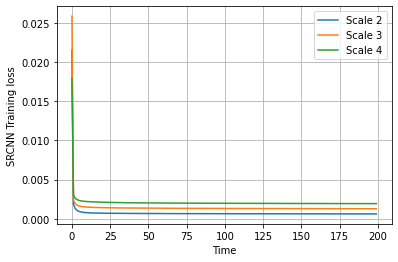

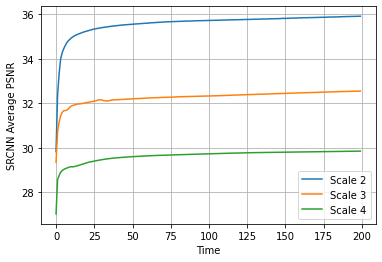

In [ ]:
time = list(range(epochs))

plt.plot(time,SRCNN_2_loss_log)
plt.plot(time,SRCNN_3_loss_log)
plt.plot(time,SRCNN_4_loss_log)
plt.legend(['Scale 2', 'Scale 3', 'Scale 4'], loc='upper right')
plt.ylabel(u'SRCNN Training loss')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()

plt.plot(time,SRCNN_2_psnr_log)
plt.plot(time,SRCNN_3_psnr_log)
plt.plot(time,SRCNN_4_psnr_log)
plt.legend(['Scale 2', 'Scale 3', 'Scale 4'], loc='lower right')
plt.ylabel(u'SRCNN Average PSNR')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()

In [ ]:
epochs = 100
UNet_2_loss_log = []
UNet_2_psnr_log = []
model = UNet(n_channels, n_classes).to(device)
train(train_loader2,eval_loader2,2,model,'UNet',UNet_2_loss_log,UNet_2_psnr_log)

UNet_3_loss_log = []
UNet_3_psnr_log = []
model = UNet(n_channels, n_classes).to(device)
train(train_loader3,eval_loader3,3,model,'UNet',UNet_3_loss_log,UNet_3_psnr_log)

UNet_4_loss_log = []
UNet_4_psnr_log = []
model = UNet(n_channels, n_classes).to(device)
train(train_loader4,eval_loader4,4,model,'UNet',UNet_4_loss_log,UNet_4_psnr_log)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.027774221422666626



  1%|          | 1/100 [00:32<53:13, 32.26s/it]

Average PSNR: 16.65220913576659 dB.
Epoch 1. Training loss: 0.015511838038914916



  2%|▏         | 2/100 [01:04<52:33, 32.18s/it]

Average PSNR: 16.18519266287623 dB.
Epoch 2. Training loss: 0.014561927055331821



  3%|▎         | 3/100 [01:36<52:01, 32.18s/it]

Average PSNR: 17.671195042816166 dB.
Epoch 3. Training loss: 0.013941942668165577



  4%|▍         | 4/100 [02:08<51:24, 32.13s/it]

Average PSNR: 18.398578475560466 dB.
Epoch 4. Training loss: 0.01486015684513033



  5%|▌         | 5/100 [02:40<50:47, 32.08s/it]

Average PSNR: 18.596421427363676 dB.
Epoch 5. Training loss: 0.01302619753010047



  6%|▌         | 6/100 [03:12<50:10, 32.02s/it]

Average PSNR: 18.872953831630163 dB.
Epoch 6. Training loss: 0.012600333300390641



  7%|▋         | 7/100 [03:44<49:34, 31.99s/it]

Average PSNR: 18.745636964230364 dB.
Epoch 7. Training loss: 0.01230413026927153



  8%|▊         | 8/100 [04:16<48:58, 31.94s/it]

Average PSNR: 18.38553207220113 dB.
Epoch 8. Training loss: 0.01116051466228663



  9%|▉         | 9/100 [04:47<48:24, 31.91s/it]

Average PSNR: 17.772690610943158 dB.
Epoch 9. Training loss: 0.010375447738433729



 10%|█         | 10/100 [05:19<47:51, 31.91s/it]

Average PSNR: 18.250605395606645 dB.
Epoch 10. Training loss: 0.010148355076255808



 11%|█         | 11/100 [05:51<47:15, 31.86s/it]

Average PSNR: 17.873510020933516 dB.
Epoch 11. Training loss: 0.009889169185797062



 12%|█▏        | 12/100 [06:23<46:39, 31.82s/it]

Average PSNR: 18.357386437792172 dB.
Epoch 12. Training loss: 0.009741435000542606



 13%|█▎        | 13/100 [06:54<46:05, 31.78s/it]

Average PSNR: 18.423931476071505 dB.
Epoch 13. Training loss: 0.009620487601217968



 14%|█▍        | 14/100 [07:26<45:28, 31.73s/it]

Average PSNR: 18.27631736590836 dB.
Epoch 14. Training loss: 0.009743994381041171



 15%|█▌        | 15/100 [07:58<44:52, 31.68s/it]

Average PSNR: 18.21824576313378 dB.
Epoch 15. Training loss: 0.009332936204177036



 16%|█▌        | 16/100 [08:29<44:19, 31.66s/it]

Average PSNR: 18.379422128980945 dB.
Epoch 16. Training loss: 0.008916576498333342



 17%|█▋        | 17/100 [09:01<43:43, 31.61s/it]

Average PSNR: 18.367711786626433 dB.
Epoch 17. Training loss: 0.008962912175467689



 18%|█▊        | 18/100 [09:32<43:10, 31.60s/it]

Average PSNR: 17.924468037236714 dB.
Epoch 18. Training loss: 0.008613944809670688



 19%|█▉        | 19/100 [10:04<42:36, 31.57s/it]

Average PSNR: 18.055861247871615 dB.
Epoch 19. Training loss: 0.008362364741676941



 20%|██        | 20/100 [10:35<42:05, 31.57s/it]

Average PSNR: 17.75170417364624 dB.
Epoch 20. Training loss: 0.008223032212949224



 21%|██        | 21/100 [11:07<41:38, 31.62s/it]

Average PSNR: 17.673677839822524 dB.
Epoch 21. Training loss: 0.008105147213189057



 22%|██▏       | 22/100 [11:39<41:13, 31.71s/it]

Average PSNR: 17.65419001165649 dB.
Epoch 22. Training loss: 0.00812345699345389



 23%|██▎       | 23/100 [12:11<40:49, 31.82s/it]

Average PSNR: 17.677136991906497 dB.
Epoch 23. Training loss: 0.007989486654149232



 24%|██▍       | 24/100 [12:43<40:20, 31.85s/it]

Average PSNR: 17.884474006299147 dB.
Epoch 24. Training loss: 0.007779162919994595



 25%|██▌       | 25/100 [13:15<39:43, 31.78s/it]

Average PSNR: 17.948013994726626 dB.
Epoch 25. Training loss: 0.007721690693021679



 26%|██▌       | 26/100 [13:46<39:04, 31.69s/it]

Average PSNR: 17.97752752285633 dB.
Epoch 26. Training loss: 0.007823734733604612



 27%|██▋       | 27/100 [14:18<38:37, 31.74s/it]

Average PSNR: 18.173079646801074 dB.
Epoch 27. Training loss: 0.007646693114623015



 28%|██▊       | 28/100 [14:49<37:55, 31.61s/it]

Average PSNR: 17.994844988174474 dB.
Epoch 28. Training loss: 0.0075413824234540645



 29%|██▉       | 29/100 [15:20<37:15, 31.48s/it]

Average PSNR: 17.871330035432578 dB.
Epoch 29. Training loss: 0.007456571277626043



 30%|███       | 30/100 [15:52<36:38, 31.41s/it]

Average PSNR: 17.996680000682954 dB.
Epoch 30. Training loss: 0.007381729324621151



 31%|███       | 31/100 [16:23<36:05, 31.39s/it]

Average PSNR: 17.8127057820308 dB.
Epoch 31. Training loss: 0.007284285741112855



 32%|███▏      | 32/100 [16:54<35:30, 31.33s/it]

Average PSNR: 17.886309393500234 dB.
Epoch 32. Training loss: 0.007187855014178369



 33%|███▎      | 33/100 [17:25<34:56, 31.29s/it]

Average PSNR: 17.87010408915582 dB.
Epoch 33. Training loss: 0.007156079372495641



 34%|███▍      | 34/100 [17:57<34:31, 31.38s/it]

Average PSNR: 17.848414957092906 dB.
Epoch 34. Training loss: 0.007138138354054052



 35%|███▌      | 35/100 [18:28<33:57, 31.34s/it]

Average PSNR: 17.74538209184016 dB.
Epoch 35. Training loss: 0.006966678344297736



 36%|███▌      | 36/100 [19:00<33:30, 31.42s/it]

Average PSNR: 17.79481856270765 dB.
Epoch 36. Training loss: 0.006912984958841023



 37%|███▋      | 37/100 [19:31<32:54, 31.35s/it]

Average PSNR: 17.826598246368796 dB.
Epoch 37. Training loss: 0.006866570204562906



 38%|███▊      | 38/100 [20:02<32:22, 31.33s/it]

Average PSNR: 17.731893228886666 dB.
Epoch 38. Training loss: 0.006892896861309028



 39%|███▉      | 39/100 [20:34<31:48, 31.29s/it]

Average PSNR: 17.85861984336545 dB.
Epoch 39. Training loss: 0.006829478693263925



 40%|████      | 40/100 [21:05<31:16, 31.28s/it]

Average PSNR: 17.59090368640063 dB.
Epoch 40. Training loss: 0.006817293303995597



 41%|████      | 41/100 [21:36<30:44, 31.26s/it]

Average PSNR: 17.65878512013398 dB.
Epoch 41. Training loss: 0.006723634869643587



 42%|████▏     | 42/100 [22:07<30:11, 31.23s/it]

Average PSNR: 17.622475963396454 dB.
Epoch 42. Training loss: 0.006694533856234



 43%|████▎     | 43/100 [22:38<29:38, 31.20s/it]

Average PSNR: 17.777463806402757 dB.
Epoch 43. Training loss: 0.0066118489357957794



 44%|████▍     | 44/100 [23:09<29:06, 31.18s/it]

Average PSNR: 17.833961338500682 dB.
Epoch 44. Training loss: 0.006500205243058617



 45%|████▌     | 45/100 [23:40<28:32, 31.14s/it]

Average PSNR: 17.953414729194566 dB.
Epoch 45. Training loss: 0.006568129866624267



 46%|████▌     | 46/100 [24:12<28:00, 31.13s/it]

Average PSNR: 18.005783704988655 dB.
Epoch 46. Training loss: 0.006405069609342344



 47%|████▋     | 47/100 [24:43<27:29, 31.13s/it]

Average PSNR: 18.17310035964714 dB.
Epoch 47. Training loss: 0.006383862176539415



 48%|████▊     | 48/100 [25:14<27:00, 31.16s/it]

Average PSNR: 18.325874062936826 dB.
Epoch 48. Training loss: 0.006363532372883388



 49%|████▉     | 49/100 [25:45<26:28, 31.16s/it]

Average PSNR: 18.47209314420073 dB.
Epoch 49. Training loss: 0.006321533544921742



 50%|█████     | 50/100 [26:16<25:57, 31.15s/it]

Average PSNR: 18.559604151710364 dB.
Epoch 50. Training loss: 0.0063374495940179765



 51%|█████     | 51/100 [26:47<25:26, 31.15s/it]

Average PSNR: 18.335765056163087 dB.
Epoch 51. Training loss: 0.006198612073675319



 52%|█████▏    | 52/100 [27:19<24:55, 31.16s/it]

Average PSNR: 18.412445776625763 dB.
Epoch 52. Training loss: 0.0061874613019912



 53%|█████▎    | 53/100 [27:50<24:24, 31.16s/it]

Average PSNR: 18.424068676699026 dB.
Epoch 53. Training loss: 0.006211690073011513



 54%|█████▍    | 54/100 [28:21<23:52, 31.13s/it]

Average PSNR: 18.327359502031193 dB.
Epoch 54. Training loss: 0.006257976961265109



 55%|█████▌    | 55/100 [28:52<23:21, 31.13s/it]

Average PSNR: 18.319921374254275 dB.
Epoch 55. Training loss: 0.006170565153658119



 56%|█████▌    | 56/100 [29:23<22:50, 31.14s/it]

Average PSNR: 18.27065401939756 dB.
Epoch 56. Training loss: 0.006173077024995965



 57%|█████▋    | 57/100 [29:54<22:20, 31.16s/it]

Average PSNR: 18.301215525455138 dB.
Epoch 57. Training loss: 0.006244238885187438



 58%|█████▊    | 58/100 [30:26<21:49, 31.17s/it]

Average PSNR: 18.199529141521175 dB.
Epoch 58. Training loss: 0.006213050352106734



 59%|█████▉    | 59/100 [30:57<21:17, 31.16s/it]

Average PSNR: 18.17206851609634 dB.
Epoch 59. Training loss: 0.006160783912523571



 60%|██████    | 60/100 [31:28<20:46, 31.16s/it]

Average PSNR: 18.202518851520967 dB.
Epoch 60. Training loss: 0.006190422836164387



 61%|██████    | 61/100 [31:59<20:15, 31.17s/it]

Average PSNR: 18.217102103963075 dB.
Epoch 61. Training loss: 0.006061494664041971



 62%|██████▏   | 62/100 [32:30<19:45, 31.19s/it]

Average PSNR: 18.258020030909897 dB.
Epoch 62. Training loss: 0.006008864841498597



 63%|██████▎   | 63/100 [33:01<19:13, 31.17s/it]

Average PSNR: 18.263145490287584 dB.
Epoch 63. Training loss: 0.005988903625721639



 64%|██████▍   | 64/100 [33:33<18:42, 31.19s/it]

Average PSNR: 18.319328452178347 dB.
Epoch 64. Training loss: 0.0059112019057293306



 65%|██████▌   | 65/100 [34:04<18:11, 31.17s/it]

Average PSNR: 18.354837563653945 dB.
Epoch 65. Training loss: 0.005869754069449473



 66%|██████▌   | 66/100 [34:35<17:41, 31.22s/it]

Average PSNR: 18.302033315179994 dB.
Epoch 66. Training loss: 0.005820356515261993



 67%|██████▋   | 67/100 [35:06<17:10, 31.22s/it]

Average PSNR: 18.26832557131744 dB.
Epoch 67. Training loss: 0.005781102445792494



 68%|██████▊   | 68/100 [35:38<16:39, 31.25s/it]

Average PSNR: 18.08027314210029 dB.
Epoch 68. Training loss: 0.00570643829207585



 69%|██████▉   | 69/100 [36:09<16:07, 31.21s/it]

Average PSNR: 18.00317787526706 dB.
Epoch 69. Training loss: 0.005717416178691676



 70%|███████   | 70/100 [36:40<15:35, 31.19s/it]

Average PSNR: 18.065843658459528 dB.
Epoch 70. Training loss: 0.00559681626009611



 71%|███████   | 71/100 [37:11<15:05, 31.21s/it]

Average PSNR: 18.1258376223524 dB.
Epoch 71. Training loss: 0.005595574251331292



 72%|███████▏  | 72/100 [37:42<14:33, 31.19s/it]

Average PSNR: 18.05323783690654 dB.
Epoch 72. Training loss: 0.005446940232319459



 73%|███████▎  | 73/100 [38:13<14:01, 31.16s/it]

Average PSNR: 17.98669532270557 dB.
Epoch 73. Training loss: 0.00552825599606081



 74%|███████▍  | 74/100 [38:45<13:30, 31.19s/it]

Average PSNR: 17.992302456050282 dB.
Epoch 74. Training loss: 0.00538101200076803



 75%|███████▌  | 75/100 [39:16<13:00, 31.22s/it]

Average PSNR: 17.805580758034594 dB.
Epoch 75. Training loss: 0.005572968833935895



 76%|███████▌  | 76/100 [39:47<12:29, 31.22s/it]

Average PSNR: 17.905432534114393 dB.
Epoch 76. Training loss: 0.005417763337332744



 77%|███████▋  | 77/100 [40:18<11:58, 31.23s/it]

Average PSNR: 17.71797503014197 dB.
Epoch 77. Training loss: 0.005384743849695293



 78%|███████▊  | 78/100 [40:50<11:26, 31.22s/it]

Average PSNR: 17.960363211964925 dB.
Epoch 78. Training loss: 0.005363412665538544



 79%|███████▉  | 79/100 [41:21<10:55, 31.24s/it]

Average PSNR: 17.82633278379659 dB.
Epoch 79. Training loss: 0.005238767093727664



 80%|████████  | 80/100 [41:52<10:24, 31.23s/it]

Average PSNR: 17.903474904977045 dB.
Epoch 80. Training loss: 0.0053534200158765755



 81%|████████  | 81/100 [42:23<09:52, 31.21s/it]

Average PSNR: 17.907682862423247 dB.
Epoch 81. Training loss: 0.005310669799305433



 82%|████████▏ | 82/100 [42:54<09:21, 31.19s/it]

Average PSNR: 17.96092145893867 dB.
Epoch 82. Training loss: 0.005158109230474018



 83%|████████▎ | 83/100 [43:25<08:49, 31.17s/it]

Average PSNR: 18.072106195808466 dB.
Epoch 83. Training loss: 0.006183288891497



 84%|████████▍ | 84/100 [43:57<08:18, 31.17s/it]

Average PSNR: 18.131475605800908 dB.
Epoch 84. Training loss: 0.0056384787141310145



 85%|████████▌ | 85/100 [44:28<07:46, 31.13s/it]

Average PSNR: 17.959582342994896 dB.
Epoch 85. Training loss: 0.0055827189791124885



 86%|████████▌ | 86/100 [44:59<07:16, 31.15s/it]

Average PSNR: 17.689604078035778 dB.
Epoch 86. Training loss: 0.005448633109480034



 87%|████████▋ | 87/100 [45:31<06:49, 31.47s/it]

Average PSNR: 17.619049196103077 dB.
Epoch 87. Training loss: 0.005435331039328899



 88%|████████▊ | 88/100 [46:02<06:16, 31.39s/it]

Average PSNR: 17.503741250537935 dB.
Epoch 88. Training loss: 0.005377177271242566



 89%|████████▉ | 89/100 [46:34<05:44, 31.36s/it]

Average PSNR: 17.756643508250377 dB.
Epoch 89. Training loss: 0.00526020909356138



 90%|█████████ | 90/100 [47:05<05:12, 31.29s/it]

Average PSNR: 17.794962155036494 dB.
Epoch 90. Training loss: 0.005260721557032393



 91%|█████████ | 91/100 [47:36<04:41, 31.24s/it]

Average PSNR: 17.83537819963114 dB.
Epoch 91. Training loss: 0.005358691775286163



 92%|█████████▏| 92/100 [48:07<04:09, 31.22s/it]

Average PSNR: 17.984376399312076 dB.
Epoch 92. Training loss: 0.005262014139939165



 93%|█████████▎| 93/100 [48:38<03:38, 31.20s/it]

Average PSNR: 18.117813952435903 dB.
Epoch 93. Training loss: 0.004886045216537915



 94%|█████████▍| 94/100 [49:09<03:07, 31.17s/it]

Average PSNR: 18.023685714678 dB.
Epoch 94. Training loss: 0.005186158415838349



 95%|█████████▌| 95/100 [49:40<02:35, 31.16s/it]

Average PSNR: 18.01213291063607 dB.
Epoch 95. Training loss: 0.0052175509002475124



 96%|█████████▌| 96/100 [50:11<02:04, 31.13s/it]

Average PSNR: 18.083639127911525 dB.
Epoch 96. Training loss: 0.004977364962361889



 97%|█████████▋| 97/100 [50:43<01:33, 31.12s/it]

Average PSNR: 17.81639491230817 dB.
Epoch 97. Training loss: 0.004917688600402651



 98%|█████████▊| 98/100 [51:14<01:02, 31.10s/it]

Average PSNR: 17.685775516434884 dB.
Epoch 98. Training loss: 0.0049110677486296425



 99%|█████████▉| 99/100 [51:45<00:31, 31.07s/it]

Average PSNR: 17.506648480828396 dB.
Epoch 99. Training loss: 0.005000579420089553



100%|██████████| 100/100 [52:16<00:00, 31.36s/it]

Average PSNR: 17.433385961987888 dB.
5



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.026857843392117397



  1%|          | 1/100 [00:32<54:04, 32.77s/it]

Average PSNR: 17.843971277573395 dB.
Epoch 1. Training loss: 0.015150057749308058



  2%|▏         | 2/100 [01:04<53:14, 32.59s/it]

Average PSNR: 16.72643119959159 dB.
Epoch 2. Training loss: 0.01522898828006235



  3%|▎         | 3/100 [01:37<52:29, 32.47s/it]

Average PSNR: 17.104270246753067 dB.
Epoch 3. Training loss: 0.014220335891494821



  4%|▍         | 4/100 [02:09<51:48, 32.39s/it]

Average PSNR: 17.522539814699865 dB.
Epoch 4. Training loss: 0.013353174359997876



  5%|▌         | 5/100 [02:41<51:07, 32.29s/it]

Average PSNR: 17.648307218450093 dB.
Epoch 5. Training loss: 0.011522666304726262



  6%|▌         | 6/100 [03:13<50:28, 32.22s/it]

Average PSNR: 17.690928924181836 dB.
Epoch 6. Training loss: 0.010967981595510606



  7%|▋         | 7/100 [03:45<49:56, 32.22s/it]

Average PSNR: 17.75637677285951 dB.
Epoch 7. Training loss: 0.010595660626905977



  8%|▊         | 8/100 [04:17<49:25, 32.23s/it]

Average PSNR: 17.81278161058986 dB.
Epoch 8. Training loss: 0.010271057599375286



  9%|▉         | 9/100 [04:50<48:54, 32.25s/it]

Average PSNR: 17.74005296479358 dB.
Epoch 9. Training loss: 0.010635354140860557



 10%|█         | 10/100 [05:22<48:23, 32.26s/it]

Average PSNR: 17.71899171415192 dB.
Epoch 10. Training loss: 0.010625667341920815



 11%|█         | 11/100 [05:54<47:40, 32.14s/it]

Average PSNR: 17.604378391543925 dB.
Epoch 11. Training loss: 0.00965149672848325



 12%|█▏        | 12/100 [06:25<46:54, 31.98s/it]

Average PSNR: 17.69662836775877 dB.
Epoch 12. Training loss: 0.009539377573865318



 13%|█▎        | 13/100 [06:57<46:10, 31.84s/it]

Average PSNR: 17.813105573885615 dB.
Epoch 13. Training loss: 0.009358374549148125



 14%|█▍        | 14/100 [07:29<45:29, 31.74s/it]

Average PSNR: 17.837969119887667 dB.
Epoch 14. Training loss: 0.009339604979484446



 15%|█▌        | 15/100 [08:00<44:48, 31.63s/it]

Average PSNR: 17.622185448718255 dB.
Epoch 15. Training loss: 0.009417795589430617



 16%|█▌        | 16/100 [08:31<44:12, 31.58s/it]

Average PSNR: 17.840813499147238 dB.
Epoch 16. Training loss: 0.009185178255068671



 17%|█▋        | 17/100 [09:03<43:35, 31.51s/it]

Average PSNR: 17.709667116960606 dB.
Epoch 17. Training loss: 0.009108767636925015



 18%|█▊        | 18/100 [09:34<43:00, 31.47s/it]

Average PSNR: 17.57697509257895 dB.
Epoch 18. Training loss: 0.0089336255099284



 19%|█▉        | 19/100 [10:06<42:37, 31.57s/it]

Average PSNR: 17.4955392187342 dB.
Epoch 19. Training loss: 0.008957958964042757



 20%|██        | 20/100 [10:37<41:57, 31.47s/it]

Average PSNR: 17.53554328284049 dB.
Epoch 20. Training loss: 0.008771733290479077



 21%|██        | 21/100 [11:08<41:20, 31.40s/it]

Average PSNR: 17.500192158193023 dB.
Epoch 21. Training loss: 0.008742767422730974



 22%|██▏       | 22/100 [11:40<40:45, 31.36s/it]

Average PSNR: 17.50184437662036 dB.
Epoch 22. Training loss: 0.008694040345141055



 23%|██▎       | 23/100 [12:11<40:10, 31.31s/it]

Average PSNR: 17.513290451511022 dB.
Epoch 23. Training loss: 0.00864195074118151



 24%|██▍       | 24/100 [12:42<39:36, 31.27s/it]

Average PSNR: 17.483086398799742 dB.
Epoch 24. Training loss: 0.008596673023196656



 25%|██▌       | 25/100 [13:16<40:07, 32.10s/it]

Average PSNR: 17.450976753130057 dB.
Epoch 25. Training loss: 0.008544803608436279



 26%|██▌       | 26/100 [13:47<39:13, 31.81s/it]

Average PSNR: 17.444053046836665 dB.
Epoch 26. Training loss: 0.008533481384249001



 27%|██▋       | 27/100 [14:18<38:27, 31.61s/it]

Average PSNR: 17.425700950006707 dB.
Epoch 27. Training loss: 0.008492842900916684



 28%|██▊       | 28/100 [14:49<37:46, 31.47s/it]

Average PSNR: 17.38851612411268 dB.
Epoch 28. Training loss: 0.008457142752132307



 29%|██▉       | 29/100 [15:20<37:04, 31.33s/it]

Average PSNR: 17.35642795753821 dB.
Epoch 29. Training loss: 0.008416401916244803



 30%|███       | 30/100 [15:52<36:27, 31.26s/it]

Average PSNR: 17.371556522256398 dB.
Epoch 30. Training loss: 0.008753720928958415



 31%|███       | 31/100 [16:23<35:52, 31.20s/it]

Average PSNR: 17.61069874425042 dB.
Epoch 31. Training loss: 0.008333651368010637



 32%|███▏      | 32/100 [16:54<35:17, 31.14s/it]

Average PSNR: 17.37731429195913 dB.
Epoch 32. Training loss: 0.008340880662653519



 33%|███▎      | 33/100 [17:25<34:43, 31.09s/it]

Average PSNR: 17.365424056315092 dB.
Epoch 33. Training loss: 0.008316066397431618



 34%|███▍      | 34/100 [17:55<34:07, 31.02s/it]

Average PSNR: 17.401785714141198 dB.
Epoch 34. Training loss: 0.008315001980317158



 35%|███▌      | 35/100 [18:27<33:39, 31.07s/it]

Average PSNR: 17.34568293882358 dB.
Epoch 35. Training loss: 0.008237792461176474



 36%|███▌      | 36/100 [18:58<33:05, 31.02s/it]

Average PSNR: 17.332678453040423 dB.
Epoch 36. Training loss: 0.008197751173467719



 37%|███▋      | 37/100 [19:28<32:32, 30.99s/it]

Average PSNR: 17.292461673968866 dB.
Epoch 37. Training loss: 0.008154317292068915



 38%|███▊      | 38/100 [19:59<32:00, 30.98s/it]

Average PSNR: 17.274467134717405 dB.
Epoch 38. Training loss: 0.008153304532721737



 39%|███▉      | 39/100 [20:30<31:30, 30.99s/it]

Average PSNR: 17.240649664703607 dB.
Epoch 39. Training loss: 0.00812446936755305



 40%|████      | 40/100 [21:01<30:59, 31.00s/it]

Average PSNR: 17.261939076408268 dB.
Epoch 40. Training loss: 0.008078080908005937



 41%|████      | 41/100 [21:32<30:27, 30.97s/it]

Average PSNR: 17.299110623892695 dB.
Epoch 41. Training loss: 0.008074950465962443



 42%|████▏     | 42/100 [22:03<29:55, 30.95s/it]

Average PSNR: 17.275473162381118 dB.
Epoch 42. Training loss: 0.008057303589834064



 43%|████▎     | 43/100 [22:34<29:24, 30.96s/it]

Average PSNR: 17.300393838412404 dB.
Epoch 43. Training loss: 0.008023943142742136



 44%|████▍     | 44/100 [23:05<28:53, 30.96s/it]

Average PSNR: 17.31075748985449 dB.
Epoch 44. Training loss: 0.008002222137463044



 45%|████▌     | 45/100 [23:36<28:21, 30.94s/it]

Average PSNR: 17.348837086528764 dB.
Epoch 45. Training loss: 0.007924891246158673



 46%|████▌     | 46/100 [24:07<27:50, 30.94s/it]

Average PSNR: 17.308696309819624 dB.
Epoch 46. Training loss: 0.007861807709389601



 47%|████▋     | 47/100 [24:38<27:19, 30.94s/it]

Average PSNR: 17.271819626478106 dB.
Epoch 47. Training loss: 0.0077792973113273494



 48%|████▊     | 48/100 [25:09<26:49, 30.94s/it]

Average PSNR: 17.245783248879807 dB.
Epoch 48. Training loss: 0.0077343156240602725



 49%|████▉     | 49/100 [25:40<26:17, 30.94s/it]

Average PSNR: 17.18753204554427 dB.
Epoch 49. Training loss: 0.007669663475758304



 50%|█████     | 50/100 [26:11<25:48, 30.96s/it]

Average PSNR: 17.146639496385884 dB.
Epoch 50. Training loss: 0.007623657544023678



 51%|█████     | 51/100 [26:42<25:20, 31.02s/it]

Average PSNR: 17.08120391083018 dB.
Epoch 51. Training loss: 0.007586600915910077



 52%|█████▏    | 52/100 [27:13<24:53, 31.12s/it]

Average PSNR: 17.066700071180918 dB.
Epoch 52. Training loss: 0.007556960567401733



 53%|█████▎    | 53/100 [27:45<24:25, 31.19s/it]

Average PSNR: 17.01388804122005 dB.
Epoch 53. Training loss: 0.007519206251541959



 54%|█████▍    | 54/100 [28:16<23:54, 31.19s/it]

Average PSNR: 17.02685947777555 dB.
Epoch 54. Training loss: 0.007485130611345531



 55%|█████▌    | 55/100 [28:47<23:21, 31.14s/it]

Average PSNR: 17.028725095563463 dB.
Epoch 55. Training loss: 0.007438013228153462



 56%|█████▌    | 56/100 [29:18<22:47, 31.08s/it]

Average PSNR: 17.01044516618699 dB.
Epoch 56. Training loss: 0.007380327227190463



 57%|█████▋    | 57/100 [29:49<22:13, 31.02s/it]

Average PSNR: 16.959899345194152 dB.
Epoch 57. Training loss: 0.007346711573204603



 58%|█████▊    | 58/100 [30:20<21:41, 30.99s/it]

Average PSNR: 16.961716060578677 dB.
Epoch 58. Training loss: 0.00732894439171259



 59%|█████▉    | 59/100 [30:51<21:14, 31.08s/it]

Average PSNR: 16.9778109517164 dB.
Epoch 59. Training loss: 0.007294805229257531



 60%|██████    | 60/100 [31:22<20:42, 31.07s/it]

Average PSNR: 16.95720429741935 dB.
Epoch 60. Training loss: 0.0072525799000766455



 61%|██████    | 61/100 [31:53<20:10, 31.05s/it]

Average PSNR: 16.923612706999833 dB.
Epoch 61. Training loss: 0.007194682774651382



 62%|██████▏   | 62/100 [32:24<19:39, 31.04s/it]

Average PSNR: 16.89599415267926 dB.
Epoch 62. Training loss: 0.007135049200498319



 63%|██████▎   | 63/100 [32:55<19:08, 31.04s/it]

Average PSNR: 16.89823810985597 dB.
Epoch 63. Training loss: 0.0070766995869282825



 64%|██████▍   | 64/100 [33:26<18:37, 31.03s/it]

Average PSNR: 16.929781812717557 dB.
Epoch 64. Training loss: 0.006991762192531799



 65%|██████▌   | 65/100 [33:57<18:06, 31.03s/it]

Average PSNR: 16.953318659205657 dB.
Epoch 65. Training loss: 0.006905302721925341



 66%|██████▌   | 66/100 [34:28<17:35, 31.05s/it]

Average PSNR: 16.970235986147753 dB.
Epoch 66. Training loss: 0.0068310795949938115



 67%|██████▋   | 67/100 [34:59<17:04, 31.04s/it]

Average PSNR: 16.961426210229778 dB.
Epoch 67. Training loss: 0.006742213232502646



 68%|██████▊   | 68/100 [35:30<16:33, 31.03s/it]

Average PSNR: 16.942352847228204 dB.
Epoch 68. Training loss: 0.006673513197344156



 69%|██████▉   | 69/100 [36:01<16:02, 31.04s/it]

Average PSNR: 16.907030801983634 dB.
Epoch 69. Training loss: 0.006623373969392688



 70%|███████   | 70/100 [36:32<15:31, 31.04s/it]

Average PSNR: 16.870889764480598 dB.
Epoch 70. Training loss: 0.006579203675814212



 71%|███████   | 71/100 [37:03<15:00, 31.05s/it]

Average PSNR: 16.848378673662687 dB.
Epoch 71. Training loss: 0.006537467244180595



 72%|███████▏  | 72/100 [37:34<14:28, 31.02s/it]

Average PSNR: 16.86154342796815 dB.
Epoch 72. Training loss: 0.006479249890159805



 73%|███████▎  | 73/100 [38:05<13:57, 31.02s/it]

Average PSNR: 16.914422084035657 dB.
Epoch 73. Training loss: 0.006417599150792516



 74%|███████▍  | 74/100 [38:36<13:26, 31.03s/it]

Average PSNR: 16.96376806751742 dB.
Epoch 74. Training loss: 0.006355240578185876



 75%|███████▌  | 75/100 [39:07<12:55, 31.01s/it]

Average PSNR: 16.92994897207703 dB.
Epoch 75. Training loss: 0.006335501736935435



 76%|███████▌  | 76/100 [39:38<12:23, 30.99s/it]

Average PSNR: 16.92603739546154 dB.
Epoch 76. Training loss: 0.006349172252359697



 77%|███████▋  | 77/100 [40:09<11:53, 31.00s/it]

Average PSNR: 16.867305502110373 dB.
Epoch 77. Training loss: 0.006361325864907496



 78%|███████▊  | 78/100 [40:40<11:22, 31.01s/it]

Average PSNR: 16.8542714573601 dB.
Epoch 78. Training loss: 0.006342864689983602



 79%|███████▉  | 79/100 [41:12<10:51, 31.04s/it]

Average PSNR: 16.786044742581034 dB.
Epoch 79. Training loss: 0.006309186051394082



 80%|████████  | 80/100 [41:43<10:21, 31.05s/it]

Average PSNR: 16.801014780806987 dB.
Epoch 80. Training loss: 0.00635395702080153



 81%|████████  | 81/100 [42:14<09:50, 31.06s/it]

Average PSNR: 16.707306510315014 dB.
Epoch 81. Training loss: 0.006291328006041405



 82%|████████▏ | 82/100 [42:45<09:18, 31.05s/it]

Average PSNR: 16.72252945137118 dB.
Epoch 82. Training loss: 0.006236379539624009



 83%|████████▎ | 83/100 [43:16<08:48, 31.06s/it]

Average PSNR: 16.72752593554735 dB.
Epoch 83. Training loss: 0.006205476427992686



 84%|████████▍ | 84/100 [43:47<08:16, 31.05s/it]

Average PSNR: 16.754778248579804 dB.
Epoch 84. Training loss: 0.006153983295635097



 85%|████████▌ | 85/100 [44:18<07:45, 31.06s/it]

Average PSNR: 16.763132953417415 dB.
Epoch 85. Training loss: 0.006104851261306179



 86%|████████▌ | 86/100 [44:49<07:15, 31.08s/it]

Average PSNR: 16.72755595178819 dB.
Epoch 86. Training loss: 0.006086746488060606



 87%|████████▋ | 87/100 [45:20<06:43, 31.02s/it]

Average PSNR: 16.695561532566938 dB.
Epoch 87. Training loss: 0.006034524391210578



 88%|████████▊ | 88/100 [45:51<06:12, 31.01s/it]

Average PSNR: 16.687598281643083 dB.
Epoch 88. Training loss: 0.005978088593110442



 89%|████████▉ | 89/100 [46:22<05:41, 31.06s/it]

Average PSNR: 16.744055056059636 dB.
Epoch 89. Training loss: 0.005969903631559954



 90%|█████████ | 90/100 [46:53<05:10, 31.07s/it]

Average PSNR: 16.639159465591995 dB.
Epoch 90. Training loss: 0.00589194842420208



 91%|█████████ | 91/100 [47:24<04:39, 31.06s/it]

Average PSNR: 16.780208439205676 dB.
Epoch 91. Training loss: 0.005848566245162391



 92%|█████████▏| 92/100 [47:55<04:08, 31.07s/it]

Average PSNR: 16.723698441277822 dB.
Epoch 92. Training loss: 0.0058282712503058606



 93%|█████████▎| 93/100 [48:26<03:37, 31.06s/it]

Average PSNR: 16.73209751414884 dB.
Epoch 93. Training loss: 0.00584213366958024



 94%|█████████▍| 94/100 [48:57<03:06, 31.06s/it]

Average PSNR: 16.598718864767825 dB.
Epoch 94. Training loss: 0.005759632706094794



 95%|█████████▌| 95/100 [49:29<02:35, 31.09s/it]

Average PSNR: 16.619256429115627 dB.
Epoch 95. Training loss: 0.005674940481174694



 96%|█████████▌| 96/100 [50:00<02:04, 31.08s/it]

Average PSNR: 16.605290065171765 dB.
Epoch 96. Training loss: 0.005578825746990376



 97%|█████████▋| 97/100 [50:31<01:33, 31.07s/it]

Average PSNR: 16.822856020149906 dB.
Epoch 97. Training loss: 0.005624749422279644



 98%|█████████▊| 98/100 [51:02<01:02, 31.06s/it]

Average PSNR: 16.70712318744252 dB.
Epoch 98. Training loss: 0.005627007649075213



 99%|█████████▉| 99/100 [51:33<00:31, 31.05s/it]

Average PSNR: 16.7911429133069 dB.
Epoch 99. Training loss: 0.00555521215365625



100%|██████████| 100/100 [52:04<00:00, 31.24s/it]

Average PSNR: 16.815541212637676 dB.
0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.0296442897282295



  1%|          | 1/100 [00:32<54:17, 32.90s/it]

Average PSNR: 17.497808723656345 dB.
Epoch 1. Training loss: 0.01748055910051164



  2%|▏         | 2/100 [01:05<53:23, 32.69s/it]

Average PSNR: 18.045106716739646 dB.
Epoch 2. Training loss: 0.01714917020380628



  3%|▎         | 3/100 [01:37<52:34, 32.52s/it]

Average PSNR: 17.432940750102052 dB.
Epoch 3. Training loss: 0.015535037049646776



  4%|▍         | 4/100 [02:09<51:52, 32.42s/it]

Average PSNR: 17.799911007409065 dB.
Epoch 4. Training loss: 0.013989225092079064



  5%|▌         | 5/100 [02:41<51:10, 32.33s/it]

Average PSNR: 17.096203280416724 dB.
Epoch 5. Training loss: 0.014168201152834757



  6%|▌         | 6/100 [03:13<50:27, 32.21s/it]

Average PSNR: 18.08507289481905 dB.
Epoch 6. Training loss: 0.012721141665433793



  7%|▋         | 7/100 [03:45<49:46, 32.11s/it]

Average PSNR: 17.785707195292723 dB.
Epoch 7. Training loss: 0.012162016301833728



  8%|▊         | 8/100 [04:17<49:05, 32.01s/it]

Average PSNR: 17.49329643324409 dB.
Epoch 8. Training loss: 0.011701861683885591



  9%|▉         | 9/100 [04:48<48:26, 31.94s/it]

Average PSNR: 17.546345625720726 dB.
Epoch 9. Training loss: 0.011187585259178692



 10%|█         | 10/100 [05:20<47:45, 31.84s/it]

Average PSNR: 17.81853250339766 dB.
Epoch 10. Training loss: 0.010899317631418775



 11%|█         | 11/100 [05:52<47:11, 31.81s/it]

Average PSNR: 17.572419624837856 dB.
Epoch 11. Training loss: 0.010543192345737766



 12%|█▏        | 12/100 [06:24<46:56, 32.01s/it]

Average PSNR: 17.50714327066285 dB.
Epoch 12. Training loss: 0.010263587516641021



 13%|█▎        | 13/100 [06:56<46:18, 31.94s/it]

Average PSNR: 17.262381244210104 dB.
Epoch 13. Training loss: 0.01005984866879662



 14%|█▍        | 14/100 [07:28<45:40, 31.87s/it]

Average PSNR: 17.61056507807623 dB.
Epoch 14. Training loss: 0.010163726752126847



 15%|█▌        | 15/100 [07:59<45:07, 31.85s/it]

Average PSNR: 17.649939804794588 dB.
Epoch 15. Training loss: 0.009734039246432395



 16%|█▌        | 16/100 [08:31<44:33, 31.82s/it]

Average PSNR: 18.91286556922467 dB.
Epoch 16. Training loss: 0.009654739254551648



 17%|█▋        | 17/100 [09:03<44:00, 31.81s/it]

Average PSNR: 18.327669377541564 dB.
Epoch 17. Training loss: 0.009518841266853303



 18%|█▊        | 18/100 [09:35<43:23, 31.75s/it]

Average PSNR: 16.81786918566572 dB.
Epoch 18. Training loss: 0.009506862739113343



 19%|█▉        | 19/100 [10:06<42:49, 31.73s/it]

Average PSNR: 16.965847696405056 dB.
Epoch 19. Training loss: 0.009271515982602436



 20%|██        | 20/100 [10:38<42:17, 31.72s/it]

Average PSNR: 16.939703440272993 dB.
Epoch 20. Training loss: 0.009184559854293717



 21%|██        | 21/100 [11:10<41:44, 31.71s/it]

Average PSNR: 16.793492600686793 dB.
Epoch 21. Training loss: 0.009219269468612925



 22%|██▏       | 22/100 [11:41<41:11, 31.69s/it]

Average PSNR: 17.16452246807964 dB.
Epoch 22. Training loss: 0.009055990091787208



 23%|██▎       | 23/100 [12:13<40:39, 31.68s/it]

Average PSNR: 16.975111374777185 dB.
Epoch 23. Training loss: 0.009005749383579415



 24%|██▍       | 24/100 [12:45<40:05, 31.65s/it]

Average PSNR: 16.92787914743591 dB.
Epoch 24. Training loss: 0.008934993551541502



 25%|██▌       | 25/100 [13:17<39:46, 31.82s/it]

Average PSNR: 17.251813651906424 dB.
Epoch 25. Training loss: 0.008829815068781988



 26%|██▌       | 26/100 [13:48<39:09, 31.76s/it]

Average PSNR: 16.94813964738025 dB.
Epoch 26. Training loss: 0.008765488131213497



 27%|██▋       | 27/100 [14:20<38:32, 31.68s/it]

Average PSNR: 17.095733256583664 dB.
Epoch 27. Training loss: 0.00884397422397766



 28%|██▊       | 28/100 [14:51<37:57, 31.64s/it]

Average PSNR: 16.241177768208658 dB.
Epoch 28. Training loss: 0.008748653254852716



 29%|██▉       | 29/100 [15:23<37:22, 31.58s/it]

Average PSNR: 16.65706669913045 dB.
Epoch 29. Training loss: 0.00895756601780664



 30%|███       | 30/100 [15:54<36:48, 31.56s/it]

Average PSNR: 18.808078093061816 dB.
Epoch 30. Training loss: 0.008870503700118446



 31%|███       | 31/100 [16:26<36:14, 31.51s/it]

Average PSNR: 18.678299004625636 dB.
Epoch 31. Training loss: 0.008802000130219466



 32%|███▏      | 32/100 [16:57<35:39, 31.47s/it]

Average PSNR: 18.58899859171973 dB.
Epoch 32. Training loss: 0.008652161929040841



 33%|███▎      | 33/100 [17:29<35:06, 31.43s/it]

Average PSNR: 18.62620491797314 dB.
Epoch 33. Training loss: 0.008629775044673512



 34%|███▍      | 34/100 [18:00<34:33, 31.41s/it]

Average PSNR: 18.481944399444238 dB.
Epoch 34. Training loss: 0.00852096264142696



 35%|███▌      | 35/100 [18:31<34:00, 31.40s/it]

Average PSNR: 18.68618830598479 dB.
Epoch 35. Training loss: 0.008541382977751267



 36%|███▌      | 36/100 [19:03<33:28, 31.39s/it]

Average PSNR: 18.725398533642206 dB.
Epoch 36. Training loss: 0.008489933471561375



 37%|███▋      | 37/100 [19:34<33:00, 31.43s/it]

Average PSNR: 18.872445695461312 dB.
Epoch 37. Training loss: 0.00841814017024361



 38%|███▊      | 38/100 [20:06<32:31, 31.47s/it]

Average PSNR: 18.233157783385824 dB.
Epoch 38. Training loss: 0.008382934475757312



 39%|███▉      | 39/100 [20:37<32:02, 31.51s/it]

Average PSNR: 18.79697385710276 dB.
Epoch 39. Training loss: 0.008408128246364574



 40%|████      | 40/100 [21:09<31:32, 31.53s/it]

Average PSNR: 18.621786070595682 dB.
Epoch 40. Training loss: 0.008314420372832162



 41%|████      | 41/100 [21:40<30:59, 31.51s/it]

Average PSNR: 18.504045938369114 dB.
Epoch 41. Training loss: 0.008200398773805694



 42%|████▏     | 42/100 [22:12<30:31, 31.58s/it]

Average PSNR: 18.476459589647213 dB.
Epoch 42. Training loss: 0.00838447707794645



 43%|████▎     | 43/100 [22:43<29:53, 31.46s/it]

Average PSNR: 18.646759510778786 dB.
Epoch 43. Training loss: 0.008224550391208719



 44%|████▍     | 44/100 [23:15<29:31, 31.63s/it]

Average PSNR: 18.57693784278047 dB.
Epoch 44. Training loss: 0.007997601294563674



 45%|████▌     | 45/100 [23:46<28:51, 31.48s/it]

Average PSNR: 18.36695445079826 dB.
Epoch 45. Training loss: 0.008084412563463832



 46%|████▌     | 46/100 [24:17<28:13, 31.35s/it]

Average PSNR: 18.620800785625452 dB.
Epoch 46. Training loss: 0.007984176979337402



 47%|████▋     | 47/100 [24:49<27:37, 31.27s/it]

Average PSNR: 18.400043335281694 dB.
Epoch 47. Training loss: 0.007988375339853712



 48%|████▊     | 48/100 [25:20<27:03, 31.22s/it]

Average PSNR: 18.200514561119697 dB.
Epoch 48. Training loss: 0.008369070618267272



 49%|████▉     | 49/100 [25:51<26:30, 31.19s/it]

Average PSNR: 18.865537058290755 dB.
Epoch 49. Training loss: 0.00824503926321307



 50%|█████     | 50/100 [26:23<26:21, 31.63s/it]

Average PSNR: 18.546777764149788 dB.
Epoch 50. Training loss: 0.008126819939857834



 51%|█████     | 51/100 [26:55<25:41, 31.47s/it]

Average PSNR: 18.497720718299416 dB.
Epoch 51. Training loss: 0.007855351935270519



 52%|█████▏    | 52/100 [27:26<25:05, 31.36s/it]

Average PSNR: 18.595514443672325 dB.
Epoch 52. Training loss: 0.007968729850938517



 53%|█████▎    | 53/100 [27:57<24:30, 31.29s/it]

Average PSNR: 18.546437720583363 dB.
Epoch 53. Training loss: 0.007987012451513236



 54%|█████▍    | 54/100 [28:28<23:56, 31.22s/it]

Average PSNR: 18.46725012098013 dB.
Epoch 54. Training loss: 0.008638385103269865



 55%|█████▌    | 55/100 [28:59<23:23, 31.18s/it]

Average PSNR: 18.7325660878762 dB.
Epoch 55. Training loss: 0.007988345964103008



 56%|█████▌    | 56/100 [29:30<22:51, 31.16s/it]

Average PSNR: 18.61545147444992 dB.
Epoch 56. Training loss: 0.008019744916143077



 57%|█████▋    | 57/100 [30:01<22:19, 31.14s/it]

Average PSNR: 18.704658255253253 dB.
Epoch 57. Training loss: 0.007850482834904533



 58%|█████▊    | 58/100 [30:32<21:47, 31.12s/it]

Average PSNR: 18.697040783550513 dB.
Epoch 58. Training loss: 0.008014610432541746



 59%|█████▉    | 59/100 [31:03<21:15, 31.10s/it]

Average PSNR: 19.114257336888137 dB.
Epoch 59. Training loss: 0.007712703540783288



 60%|██████    | 60/100 [31:34<20:44, 31.11s/it]

Average PSNR: 18.805802287239022 dB.
Epoch 60. Training loss: 0.007732294506360599



 61%|██████    | 61/100 [32:05<20:13, 31.11s/it]

Average PSNR: 18.77189663768656 dB.
Epoch 61. Training loss: 0.007664710751842554



 62%|██████▏   | 62/100 [32:36<19:40, 31.07s/it]

Average PSNR: 19.100944260656355 dB.
Epoch 62. Training loss: 0.007627506307333085



 63%|██████▎   | 63/100 [33:08<19:09, 31.07s/it]

Average PSNR: 19.24199575150447 dB.
Epoch 63. Training loss: 0.007687157728535852



 64%|██████▍   | 64/100 [33:39<18:39, 31.10s/it]

Average PSNR: 19.01504262981707 dB.
Epoch 64. Training loss: 0.007819869513029392



 65%|██████▌   | 65/100 [34:10<18:08, 31.10s/it]

Average PSNR: 19.131672590904593 dB.
Epoch 65. Training loss: 0.007652265400881128



 66%|██████▌   | 66/100 [34:41<17:36, 31.08s/it]

Average PSNR: 19.046254687414358 dB.
Epoch 66. Training loss: 0.007514469482412949



 67%|██████▋   | 67/100 [35:12<17:05, 31.07s/it]

Average PSNR: 18.896318501548897 dB.
Epoch 67. Training loss: 0.007473871297929491



 68%|██████▊   | 68/100 [35:43<16:34, 31.08s/it]

Average PSNR: 18.619245142904827 dB.
Epoch 68. Training loss: 0.007505549157524476



 69%|██████▉   | 69/100 [36:14<16:03, 31.07s/it]

Average PSNR: 19.284882028349912 dB.
Epoch 69. Training loss: 0.007421993580510255



 70%|███████   | 70/100 [36:45<15:31, 31.06s/it]

Average PSNR: 19.033738804493087 dB.
Epoch 70. Training loss: 0.0074785660276028305



 71%|███████   | 71/100 [37:16<15:00, 31.06s/it]

Average PSNR: 18.923236811341024 dB.
Epoch 71. Training loss: 0.007615559306637524



 72%|███████▏  | 72/100 [37:47<14:29, 31.07s/it]

Average PSNR: 18.837637890258303 dB.
Epoch 72. Training loss: 0.007342699874715492



 73%|███████▎  | 73/100 [38:18<13:58, 31.05s/it]

Average PSNR: 19.065777913664512 dB.
Epoch 73. Training loss: 0.007207245414884067



 74%|███████▍  | 74/100 [38:49<13:26, 31.03s/it]

Average PSNR: 18.820092118326233 dB.
Epoch 74. Training loss: 0.0071703031327291404



 75%|███████▌  | 75/100 [39:20<12:56, 31.06s/it]

Average PSNR: 18.737571574523834 dB.
Epoch 75. Training loss: 0.007781657677408734



 76%|███████▌  | 76/100 [39:51<12:25, 31.06s/it]

Average PSNR: 18.458741224614407 dB.
Epoch 76. Training loss: 0.007192894323084427



 77%|███████▋  | 77/100 [40:23<11:54, 31.08s/it]

Average PSNR: 18.856312592803157 dB.
Epoch 77. Training loss: 0.0072179001862185945



 78%|███████▊  | 78/100 [40:54<11:23, 31.07s/it]

Average PSNR: 18.951135390937395 dB.
Epoch 78. Training loss: 0.00818940638847884



 79%|███████▉  | 79/100 [41:25<10:52, 31.09s/it]

Average PSNR: 18.679257458325452 dB.
Epoch 79. Training loss: 0.008070283522112486



 80%|████████  | 80/100 [41:56<10:21, 31.09s/it]

Average PSNR: 18.886250940276092 dB.
Epoch 80. Training loss: 0.00687639921926825



 81%|████████  | 81/100 [42:27<09:51, 31.14s/it]

Average PSNR: 18.876093116709118 dB.
Epoch 81. Training loss: 0.007267608605509575



 82%|████████▏ | 82/100 [42:59<09:22, 31.23s/it]

Average PSNR: 18.550432079118686 dB.
Epoch 82. Training loss: 0.0071063676543118666



 83%|████████▎ | 83/100 [43:30<08:51, 31.24s/it]

Average PSNR: 18.841101433876005 dB.
Epoch 83. Training loss: 0.0069471049310961775



 84%|████████▍ | 84/100 [44:01<08:20, 31.30s/it]

Average PSNR: 18.23516213603932 dB.
Epoch 84. Training loss: 0.007130108048246294



 85%|████████▌ | 85/100 [44:32<07:48, 31.20s/it]

Average PSNR: 19.03072369818055 dB.
Epoch 85. Training loss: 0.0066448888289769486



 86%|████████▌ | 86/100 [45:03<07:16, 31.19s/it]

Average PSNR: 18.76733963206119 dB.
Epoch 86. Training loss: 0.0073293185821199066



 87%|████████▋ | 87/100 [45:34<06:44, 31.10s/it]

Average PSNR: 19.075617406874827 dB.
Epoch 87. Training loss: 0.006876251441965978



 88%|████████▊ | 88/100 [46:05<06:13, 31.10s/it]

Average PSNR: 19.25001559933832 dB.
Epoch 88. Training loss: 0.006665910871035782



 89%|████████▉ | 89/100 [46:36<05:41, 31.08s/it]

Average PSNR: 19.146913514629667 dB.
Epoch 89. Training loss: 0.006725546194150323



 90%|█████████ | 90/100 [47:07<05:10, 31.03s/it]

Average PSNR: 19.221027668212933 dB.
Epoch 90. Training loss: 0.006701759918069854



 91%|█████████ | 91/100 [47:38<04:39, 31.04s/it]

Average PSNR: 18.17248227921771 dB.
Epoch 91. Training loss: 0.0069562476087372494



 92%|█████████▏| 92/100 [48:09<04:08, 31.06s/it]

Average PSNR: 19.22883681143016 dB.
Epoch 92. Training loss: 0.007346022263021806



 93%|█████████▎| 93/100 [48:41<03:37, 31.07s/it]

Average PSNR: 19.496864945972042 dB.
Epoch 93. Training loss: 0.006643203766183529



 94%|█████████▍| 94/100 [49:12<03:06, 31.05s/it]

Average PSNR: 18.44654532029086 dB.
Epoch 94. Training loss: 0.006729070118715839



 95%|█████████▌| 95/100 [49:43<02:35, 31.06s/it]

Average PSNR: 19.117002796548796 dB.
Epoch 95. Training loss: 0.007023888234529764



 96%|█████████▌| 96/100 [50:14<02:04, 31.04s/it]

Average PSNR: 19.229668746432786 dB.
Epoch 96. Training loss: 0.007394657321779544



 97%|█████████▋| 97/100 [50:45<01:33, 31.03s/it]

Average PSNR: 18.853914793397504 dB.
Epoch 97. Training loss: 0.006620515231282076



 98%|█████████▊| 98/100 [51:16<01:01, 31.00s/it]

Average PSNR: 18.060240673190645 dB.
Epoch 98. Training loss: 0.006382711578564734



 99%|█████████▉| 99/100 [51:47<00:31, 31.02s/it]

Average PSNR: 19.941604445820573 dB.
Epoch 99. Training loss: 0.006524236347728417



100%|██████████| 100/100 [52:18<00:00, 31.38s/it]

Average PSNR: 17.890925819203296 dB.
98


In [ ]:
RUNet_2_loss_log = []
RUNet_2_psnr_log = []
model = Res_UNet(n_channels, n_classes).to(device)
train(train_loader2,eval_loader2,2,model,'RUNet',RUNet_2_loss_log,RUNet_2_psnr_log)

RUNet_3_loss_log = []
RUNet_3_psnr_log = []
model = Res_UNet(n_channels, n_classes).to(device)
train(train_loader3,eval_loader3,3,model,'RUNet',RUNet_3_loss_log,RUNet_3_psnr_log)

RUNet_4_loss_log = []
RUNet_4_psnr_log = []
model = Res_UNet(n_channels, n_classes).to(device)
train(train_loader4,eval_loader4,4,model,'RUNet',RUNet_4_loss_log,RUNet_4_psnr_log)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.1206510604532984



  1%|          | 1/100 [00:55<1:30:50, 55.06s/it]

Average PSNR: 15.286033266059345 dB.
Epoch 1. Training loss: 0.017937912564295676



  2%|▏         | 2/100 [01:49<1:29:37, 54.87s/it]

Average PSNR: 17.564120874725212 dB.
Epoch 2. Training loss: 0.01473444352200005



  3%|▎         | 3/100 [02:44<1:28:33, 54.78s/it]

Average PSNR: 18.35041082369805 dB.
Epoch 3. Training loss: 0.014849485349216913



  4%|▍         | 4/100 [03:38<1:27:35, 54.75s/it]

Average PSNR: 18.848630911291107 dB.
Epoch 4. Training loss: 0.015027007927070032



  5%|▌         | 5/100 [04:33<1:26:28, 54.61s/it]

Average PSNR: 19.325915677320488 dB.
Epoch 5. Training loss: 0.014081630388949523



  6%|▌         | 6/100 [05:27<1:25:24, 54.51s/it]

Average PSNR: 19.490397338829155 dB.
Epoch 6. Training loss: 0.015305803211693687



  7%|▋         | 7/100 [06:21<1:24:23, 54.44s/it]

Average PSNR: 19.11656615495503 dB.
Epoch 7. Training loss: 0.019861205719762996



  8%|▊         | 8/100 [07:15<1:23:22, 54.37s/it]

Average PSNR: 18.918226468589133 dB.
Epoch 8. Training loss: 0.012188074661455451



  9%|▉         | 9/100 [08:10<1:22:24, 54.33s/it]

Average PSNR: 19.080186444161377 dB.
Epoch 9. Training loss: 0.013665134226699677



 10%|█         | 10/100 [09:04<1:21:31, 54.35s/it]

Average PSNR: 19.328006626082797 dB.
Epoch 10. Training loss: 0.013656648164567518



 11%|█         | 11/100 [09:59<1:20:45, 54.44s/it]

Average PSNR: 19.549010582755308 dB.
Epoch 11. Training loss: 0.014765719987171005



 12%|█▏        | 12/100 [10:53<1:19:42, 54.35s/it]

Average PSNR: 19.96369317933769 dB.
Epoch 12. Training loss: 0.013453545196473316



 13%|█▎        | 13/100 [11:47<1:18:42, 54.29s/it]

Average PSNR: 19.757085715416906 dB.
Epoch 13. Training loss: 0.013954185277770705



 14%|█▍        | 14/100 [12:41<1:17:45, 54.25s/it]

Average PSNR: 19.736771303355862 dB.
Epoch 14. Training loss: 0.014943742873615506



 15%|█▌        | 15/100 [13:35<1:16:52, 54.26s/it]

Average PSNR: 19.715865105072883 dB.
Epoch 15. Training loss: 0.013428188938394314



 16%|█▌        | 16/100 [14:29<1:15:54, 54.22s/it]

Average PSNR: 19.945258216568746 dB.
Epoch 16. Training loss: 0.013225654492924484



 17%|█▋        | 17/100 [15:24<1:15:01, 54.23s/it]

Average PSNR: 19.558343765023675 dB.
Epoch 17. Training loss: 0.013479127236553699



 18%|█▊        | 18/100 [16:18<1:14:05, 54.21s/it]

Average PSNR: 19.63894465314016 dB.
Epoch 18. Training loss: 0.013320592077789725



 19%|█▉        | 19/100 [17:12<1:13:10, 54.21s/it]

Average PSNR: 19.708653327330573 dB.
Epoch 19. Training loss: 0.012962084882634721



 20%|██        | 20/100 [18:06<1:12:18, 54.23s/it]

Average PSNR: 20.078219159834834 dB.
Epoch 20. Training loss: 0.012997136531572832



 21%|██        | 21/100 [19:01<1:11:28, 54.28s/it]

Average PSNR: 19.42206464576937 dB.
Epoch 21. Training loss: 0.012901684469726676



 22%|██▏       | 22/100 [19:55<1:10:26, 54.19s/it]

Average PSNR: 19.525332408893277 dB.
Epoch 22. Training loss: 0.02105836489535841



 23%|██▎       | 23/100 [20:49<1:09:39, 54.29s/it]

Average PSNR: 18.8621844291164 dB.
Epoch 23. Training loss: 0.010988152156748235



 24%|██▍       | 24/100 [21:44<1:09:00, 54.48s/it]

Average PSNR: 19.061468626090026 dB.
Epoch 24. Training loss: 0.013131550880611954



 25%|██▌       | 25/100 [22:39<1:08:07, 54.50s/it]

Average PSNR: 19.593432742711762 dB.
Epoch 25. Training loss: 0.011216281815472741



 26%|██▌       | 26/100 [23:32<1:06:56, 54.28s/it]

Average PSNR: 19.44912764705189 dB.
Epoch 26. Training loss: 0.013244689703388168



 27%|██▋       | 27/100 [24:26<1:05:50, 54.12s/it]

Average PSNR: 19.830192194594748 dB.
Epoch 27. Training loss: 0.013547219235908903



 28%|██▊       | 28/100 [25:20<1:04:47, 53.99s/it]

Average PSNR: 19.411952342240173 dB.
Epoch 28. Training loss: 0.013254649523080872



 29%|██▉       | 29/100 [26:14<1:03:46, 53.89s/it]

Average PSNR: 19.20610408322192 dB.
Epoch 29. Training loss: 0.012166840413927424



 30%|███       | 30/100 [27:07<1:02:44, 53.78s/it]

Average PSNR: 19.981963318993646 dB.
Epoch 30. Training loss: 0.011756519707932568



 31%|███       | 31/100 [28:01<1:01:45, 53.70s/it]

Average PSNR: 19.490607595594817 dB.
Epoch 31. Training loss: 0.011121311805885742



 32%|███▏      | 32/100 [28:54<1:00:48, 53.66s/it]

Average PSNR: 19.536708548620926 dB.
Epoch 32. Training loss: 0.014538279754746402



 33%|███▎      | 33/100 [29:48<59:51, 53.60s/it]  

Average PSNR: 18.5673488008993 dB.
Epoch 33. Training loss: 0.011051550350910861



 34%|███▍      | 34/100 [30:41<58:55, 53.56s/it]

Average PSNR: 19.503292595288137 dB.
Epoch 34. Training loss: 0.01395733330199229



 35%|███▌      | 35/100 [31:35<57:59, 53.53s/it]

Average PSNR: 19.89279541250341 dB.
Epoch 35. Training loss: 0.01122431428804342



 36%|███▌      | 36/100 [32:28<57:02, 53.48s/it]

Average PSNR: 18.90204679537677 dB.
Epoch 36. Training loss: 0.012834325605873073



 37%|███▋      | 37/100 [33:21<56:08, 53.47s/it]

Average PSNR: 19.538931891607852 dB.
Epoch 37. Training loss: 0.01130617108248967



 38%|███▊      | 38/100 [34:15<55:11, 53.41s/it]

Average PSNR: 18.510204895773434 dB.
Epoch 38. Training loss: 0.0121732188901883



 39%|███▉      | 39/100 [35:08<54:18, 53.42s/it]

Average PSNR: 18.73965436043119 dB.
Epoch 39. Training loss: 0.012492923435969578



 40%|████      | 40/100 [36:01<53:22, 53.38s/it]

Average PSNR: 19.069140887211915 dB.
Epoch 40. Training loss: 0.011641091706147064



 41%|████      | 41/100 [36:55<52:31, 53.41s/it]

Average PSNR: 19.059076678491692 dB.
Epoch 41. Training loss: 0.012152854103728064



 42%|████▏     | 42/100 [37:49<51:55, 53.71s/it]

Average PSNR: 17.614662142417032 dB.
Epoch 42. Training loss: 0.011608378274051293



 43%|████▎     | 43/100 [38:43<50:56, 53.62s/it]

Average PSNR: 19.69005510706936 dB.
Epoch 43. Training loss: 0.011686421348543637



 44%|████▍     | 44/100 [39:36<49:57, 53.52s/it]

Average PSNR: 19.279627390359984 dB.
Epoch 44. Training loss: 0.01273609838212919



 45%|████▌     | 45/100 [40:29<49:00, 53.46s/it]

Average PSNR: 19.681463623513796 dB.
Epoch 45. Training loss: 0.01183051041004305



 46%|████▌     | 46/100 [41:23<48:05, 53.43s/it]

Average PSNR: 19.40135024564338 dB.
Epoch 46. Training loss: 0.012951898582618407



 47%|████▋     | 47/100 [42:16<47:11, 53.43s/it]

Average PSNR: 19.241419879457748 dB.
Epoch 47. Training loss: 0.01256283427878492



 48%|████▊     | 48/100 [43:10<46:20, 53.46s/it]

Average PSNR: 19.15538206091325 dB.
Epoch 48. Training loss: 0.011353310315025313



 49%|████▉     | 49/100 [44:03<45:23, 53.40s/it]

Average PSNR: 20.043509557150436 dB.
Epoch 49. Training loss: 0.011133896414687417



 50%|█████     | 50/100 [44:56<44:26, 53.33s/it]

Average PSNR: 18.630237532724617 dB.
Epoch 50. Training loss: 0.01245397644449411



 51%|█████     | 51/100 [45:49<43:32, 53.31s/it]

Average PSNR: 19.100674735842478 dB.
Epoch 51. Training loss: 0.01030743145231163



 52%|█████▏    | 52/100 [46:43<42:38, 53.29s/it]

Average PSNR: 20.531391975284173 dB.
Epoch 52. Training loss: 0.010429355335719178



 53%|█████▎    | 53/100 [47:36<41:45, 53.31s/it]

Average PSNR: 19.703412619630804 dB.
Epoch 53. Training loss: 0.011384563544139255



 54%|█████▍    | 54/100 [48:29<40:53, 53.33s/it]

Average PSNR: 19.581279757908398 dB.
Epoch 54. Training loss: 0.012164384445023477



 55%|█████▌    | 55/100 [49:23<39:59, 53.33s/it]

Average PSNR: 19.01150342148958 dB.
Epoch 55. Training loss: 0.009850388397897102



 56%|█████▌    | 56/100 [50:16<39:01, 53.22s/it]

Average PSNR: 18.629077805276633 dB.
Epoch 56. Training loss: 0.013143194075870673



 57%|█████▋    | 57/100 [51:09<38:07, 53.19s/it]

Average PSNR: 18.763576380909953 dB.
Epoch 57. Training loss: 0.010981753176287273



 58%|█████▊    | 58/100 [52:02<37:11, 53.12s/it]

Average PSNR: 19.090807430117724 dB.
Epoch 58. Training loss: 0.01192062883909368



 59%|█████▉    | 59/100 [52:55<36:15, 53.05s/it]

Average PSNR: 18.720185249248413 dB.
Epoch 59. Training loss: 0.011735538141727285



 60%|██████    | 60/100 [53:47<35:20, 53.00s/it]

Average PSNR: 18.851080237439493 dB.
Epoch 60. Training loss: 0.011215492849999838



 61%|██████    | 61/100 [54:40<34:26, 52.98s/it]

Average PSNR: 17.44047355185723 dB.
Epoch 61. Training loss: 0.012617944870344377



 62%|██████▏   | 62/100 [55:33<33:32, 52.96s/it]

Average PSNR: 19.15573825421806 dB.
Epoch 62. Training loss: 0.011461260839692608



 63%|██████▎   | 63/100 [56:26<32:39, 52.95s/it]

Average PSNR: 19.15681362633203 dB.
Epoch 63. Training loss: 0.011489399350567316



 64%|██████▍   | 64/100 [57:19<31:46, 52.95s/it]

Average PSNR: 19.407426485997217 dB.
Epoch 64. Training loss: 0.011225290458517709



 65%|██████▌   | 65/100 [58:12<30:51, 52.91s/it]

Average PSNR: 18.573614120854348 dB.
Epoch 65. Training loss: 0.011237359814462592



 66%|██████▌   | 66/100 [59:05<29:58, 52.91s/it]

Average PSNR: 18.10282813159487 dB.
Epoch 66. Training loss: 0.011125491605358844



 67%|██████▋   | 67/100 [59:58<29:07, 52.94s/it]

Average PSNR: 18.325508500004098 dB.
Epoch 67. Training loss: 0.010455372009348972



 68%|██████▊   | 68/100 [1:00:51<28:20, 53.14s/it]

Average PSNR: 18.44510395710616 dB.
Epoch 68. Training loss: 0.01112184607584719



 69%|██████▉   | 69/100 [1:01:45<27:31, 53.26s/it]

Average PSNR: 18.710907121009036 dB.
Epoch 69. Training loss: 0.010621634421431603



 70%|███████   | 70/100 [1:02:38<26:34, 53.15s/it]

Average PSNR: 18.360025692366495 dB.
Epoch 70. Training loss: 0.010550498284104908



 71%|███████   | 71/100 [1:03:31<25:39, 53.09s/it]

Average PSNR: 18.960730075336937 dB.
Epoch 71. Training loss: 0.010734641786702737



 72%|███████▏  | 72/100 [1:04:24<24:43, 53.00s/it]

Average PSNR: 18.802736747109343 dB.
Epoch 72. Training loss: 0.011650255469214334



 73%|███████▎  | 73/100 [1:05:19<24:08, 53.67s/it]

Average PSNR: 19.19484072182106 dB.
Epoch 73. Training loss: 0.011666509346750025



 74%|███████▍  | 74/100 [1:06:12<23:10, 53.48s/it]

Average PSNR: 19.205969281887178 dB.
Epoch 74. Training loss: 0.010855347212199013



 75%|███████▌  | 75/100 [1:07:05<22:13, 53.34s/it]

Average PSNR: 19.166858835584254 dB.
Epoch 75. Training loss: 0.011005731351957345



 76%|███████▌  | 76/100 [1:07:58<21:18, 53.26s/it]

Average PSNR: 18.2757716668333 dB.
Epoch 76. Training loss: 0.011344462128270569



 77%|███████▋  | 77/100 [1:08:51<20:23, 53.20s/it]

Average PSNR: 18.448731707298027 dB.
Epoch 77. Training loss: 0.010848000497657686



 78%|███████▊  | 78/100 [1:09:44<19:28, 53.13s/it]

Average PSNR: 17.66290207806698 dB.
Epoch 78. Training loss: 0.012425877068174117



 79%|███████▉  | 79/100 [1:10:37<18:35, 53.11s/it]

Average PSNR: 17.78419774795526 dB.
Epoch 79. Training loss: 0.010719834942453467



 80%|████████  | 80/100 [1:11:30<17:40, 53.04s/it]

Average PSNR: 18.029817563914836 dB.
Epoch 80. Training loss: 0.011419461795356961



 81%|████████  | 81/100 [1:12:23<16:47, 53.02s/it]

Average PSNR: 19.398400601120407 dB.
Epoch 81. Training loss: 0.011320454495620939



 82%|████████▏ | 82/100 [1:13:16<15:54, 53.02s/it]

Average PSNR: 18.358497733418137 dB.
Epoch 82. Training loss: 0.010402854929274931



 83%|████████▎ | 83/100 [1:14:09<15:01, 53.05s/it]

Average PSNR: 18.64112863141887 dB.
Epoch 83. Training loss: 0.011430495010984861



 84%|████████▍ | 84/100 [1:15:02<14:08, 53.04s/it]

Average PSNR: 19.218764964144402 dB.
Epoch 84. Training loss: 0.00989122331056217



 85%|████████▌ | 85/100 [1:15:56<13:18, 53.21s/it]

Average PSNR: 19.16445893203734 dB.
Epoch 85. Training loss: 0.011640774599125788



 86%|████████▌ | 86/100 [1:16:49<12:24, 53.16s/it]

Average PSNR: 19.41215290052455 dB.
Epoch 86. Training loss: 0.009634637237871311



 87%|████████▋ | 87/100 [1:17:42<11:30, 53.15s/it]

Average PSNR: 19.349322418413827 dB.
Epoch 87. Training loss: 0.012460450973238188



 88%|████████▊ | 88/100 [1:18:35<10:37, 53.11s/it]

Average PSNR: 19.448034922840858 dB.
Epoch 88. Training loss: 0.010590908462426057



 89%|████████▉ | 89/100 [1:19:28<09:43, 53.08s/it]

Average PSNR: 19.299798836329956 dB.
Epoch 89. Training loss: 0.012766295854435316



 90%|█████████ | 90/100 [1:20:21<08:50, 53.05s/it]

Average PSNR: 18.268462763028857 dB.
Epoch 90. Training loss: 0.010229149795987212



 91%|█████████ | 91/100 [1:21:14<07:56, 52.98s/it]

Average PSNR: 19.147847742897234 dB.
Epoch 91. Training loss: 0.011645974123167585



 92%|█████████▏| 92/100 [1:22:07<07:04, 53.01s/it]

Average PSNR: 18.916186713768333 dB.
Epoch 92. Training loss: 0.010540077143753322



 93%|█████████▎| 93/100 [1:23:00<06:11, 53.07s/it]

Average PSNR: 19.74064991060323 dB.
Epoch 93. Training loss: 0.010381240775956672



 94%|█████████▍| 94/100 [1:23:53<05:18, 53.09s/it]

Average PSNR: 19.500500175765918 dB.
Epoch 94. Training loss: 0.009752871344271916



 95%|█████████▌| 95/100 [1:24:49<04:29, 53.86s/it]

Average PSNR: 18.968551545027204 dB.
Epoch 95. Training loss: 0.012127072166491289



 96%|█████████▌| 96/100 [1:25:42<03:34, 53.63s/it]

Average PSNR: 18.842650226090356 dB.
Epoch 96. Training loss: 0.011791026436434596



 97%|█████████▋| 97/100 [1:26:35<02:40, 53.44s/it]

Average PSNR: 18.224905059812524 dB.
Epoch 97. Training loss: 0.010962781193258875



 98%|█████████▊| 98/100 [1:27:29<01:47, 53.66s/it]

Average PSNR: 18.923268257580297 dB.
Epoch 98. Training loss: 0.01120748110818093



 99%|█████████▉| 99/100 [1:28:23<00:53, 53.59s/it]

Average PSNR: 18.58315902344436 dB.
Epoch 99. Training loss: 0.010732538847771336



100%|██████████| 100/100 [1:29:16<00:00, 53.56s/it]

Average PSNR: 18.925077042257538 dB.
0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.14317636779640197



  1%|          | 1/100 [00:53<1:29:02, 53.96s/it]

Average PSNR: 16.893798641550358 dB.
Epoch 1. Training loss: 0.019295048777065758



  2%|▏         | 2/100 [01:47<1:28:00, 53.88s/it]

Average PSNR: 19.091629493436862 dB.
Epoch 2. Training loss: 0.01770461113968243



  3%|▎         | 3/100 [02:41<1:27:03, 53.85s/it]

Average PSNR: 19.169559912113847 dB.
Epoch 3. Training loss: 0.014929503490753494



  4%|▍         | 4/100 [03:35<1:26:06, 53.81s/it]

Average PSNR: 19.510217967577695 dB.
Epoch 4. Training loss: 0.01378760355142114



  5%|▌         | 5/100 [04:28<1:25:10, 53.79s/it]

Average PSNR: 19.83818058220969 dB.
Epoch 5. Training loss: 0.014735802579351172



  6%|▌         | 6/100 [05:22<1:24:13, 53.76s/it]

Average PSNR: 19.77760370802031 dB.
Epoch 6. Training loss: 0.015153072788536668



  7%|▋         | 7/100 [06:16<1:23:15, 53.72s/it]

Average PSNR: 19.938277094977188 dB.
Epoch 7. Training loss: 0.013953792282389695



  8%|▊         | 8/100 [07:09<1:22:12, 53.62s/it]

Average PSNR: 19.60994945392951 dB.
Epoch 8. Training loss: 0.012721402929212125



  9%|▉         | 9/100 [08:02<1:21:09, 53.51s/it]

Average PSNR: 19.43588958970734 dB.
Epoch 9. Training loss: 0.013838113912780175



 10%|█         | 10/100 [08:56<1:20:14, 53.50s/it]

Average PSNR: 19.560634344411508 dB.
Epoch 10. Training loss: 0.013115286741648087



 11%|█         | 11/100 [09:49<1:19:17, 53.46s/it]

Average PSNR: 20.275376437554932 dB.
Epoch 11. Training loss: 0.012984504733624056



 12%|█▏        | 12/100 [10:43<1:18:25, 53.47s/it]

Average PSNR: 19.65017229430673 dB.
Epoch 12. Training loss: 0.014967589758095545



 13%|█▎        | 13/100 [11:36<1:17:32, 53.47s/it]

Average PSNR: 19.552187981605886 dB.
Epoch 13. Training loss: 0.012855170544322678



 14%|█▍        | 14/100 [12:29<1:16:35, 53.43s/it]

Average PSNR: 19.566435952689247 dB.
Epoch 14. Training loss: 0.013635161893758161



 15%|█▌        | 15/100 [13:23<1:15:44, 53.46s/it]

Average PSNR: 19.34549505602589 dB.
Epoch 15. Training loss: 0.013023527982108273



 16%|█▌        | 16/100 [14:17<1:15:04, 53.62s/it]

Average PSNR: 19.14800434975199 dB.
Epoch 16. Training loss: 0.012164996867306389



 17%|█▋        | 17/100 [15:10<1:14:00, 53.50s/it]

Average PSNR: 19.106416047815866 dB.
Epoch 17. Training loss: 0.01438092661674995



 18%|█▊        | 18/100 [16:04<1:13:04, 53.47s/it]

Average PSNR: 19.054531322106207 dB.
Epoch 18. Training loss: 0.01235324162897948



 19%|█▉        | 19/100 [16:57<1:12:09, 53.45s/it]

Average PSNR: 19.19295252588268 dB.
Epoch 19. Training loss: 0.013464111968199586



 20%|██        | 20/100 [17:50<1:11:16, 53.46s/it]

Average PSNR: 19.860774050819895 dB.
Epoch 20. Training loss: 0.012194767755004223



 21%|██        | 21/100 [18:44<1:10:25, 53.49s/it]

Average PSNR: 19.31569920715066 dB.
Epoch 21. Training loss: 0.014252864676888499



 22%|██▏       | 22/100 [19:37<1:09:27, 53.43s/it]

Average PSNR: 19.051864284510593 dB.
Epoch 22. Training loss: 0.012623519397903049



 23%|██▎       | 23/100 [20:31<1:08:28, 53.36s/it]

Average PSNR: 18.394381862611887 dB.
Epoch 23. Training loss: 0.012595199143829925



 24%|██▍       | 24/100 [21:24<1:07:42, 53.46s/it]

Average PSNR: 18.795909195343363 dB.
Epoch 24. Training loss: 0.011200852918660551



 25%|██▌       | 25/100 [22:18<1:06:46, 53.42s/it]

Average PSNR: 18.79997183951293 dB.
Epoch 25. Training loss: 0.010388598372453105



 26%|██▌       | 26/100 [23:11<1:05:51, 53.40s/it]

Average PSNR: 18.5617614998254 dB.
Epoch 26. Training loss: 0.012826558389212142



 27%|██▋       | 27/100 [24:04<1:04:57, 53.38s/it]

Average PSNR: 19.45144412354672 dB.
Epoch 27. Training loss: 0.012848260908623154



 28%|██▊       | 28/100 [24:58<1:04:02, 53.37s/it]

Average PSNR: 18.928618844682262 dB.
Epoch 28. Training loss: 0.011475600969905513



 29%|██▉       | 29/100 [25:51<1:03:10, 53.38s/it]

Average PSNR: 18.88373995571054 dB.
Epoch 29. Training loss: 0.012366166166765126



 30%|███       | 30/100 [26:44<1:02:18, 53.40s/it]

Average PSNR: 18.797577591728736 dB.
Epoch 30. Training loss: 0.011595426644035206



 31%|███       | 31/100 [27:38<1:01:20, 53.34s/it]

Average PSNR: 18.433664127425807 dB.
Epoch 31. Training loss: 0.012701629218849632



 32%|███▏      | 32/100 [28:31<1:00:25, 53.31s/it]

Average PSNR: 18.538245651594465 dB.
Epoch 32. Training loss: 0.01117271639400554



 33%|███▎      | 33/100 [29:24<59:27, 53.25s/it]  

Average PSNR: 18.90518085363264 dB.
Epoch 33. Training loss: 0.012212434784939502



 34%|███▍      | 34/100 [30:17<58:34, 53.25s/it]

Average PSNR: 18.917785119928613 dB.
Epoch 34. Training loss: 0.011367553438275115



 35%|███▌      | 35/100 [31:10<57:39, 53.23s/it]

Average PSNR: 18.046217423087292 dB.
Epoch 35. Training loss: 0.011728289484200259



 36%|███▌      | 36/100 [32:04<56:44, 53.19s/it]

Average PSNR: 18.701135786789035 dB.
Epoch 36. Training loss: 0.012316025400735786



 37%|███▋      | 37/100 [32:57<55:48, 53.16s/it]

Average PSNR: 18.897063176524647 dB.
Epoch 37. Training loss: 0.012407768067559336



 38%|███▊      | 38/100 [33:50<54:54, 53.14s/it]

Average PSNR: 19.26511273646826 dB.
Epoch 38. Training loss: 0.012173039309356405



 39%|███▉      | 39/100 [34:43<54:00, 53.12s/it]

Average PSNR: 18.76554392211088 dB.
Epoch 39. Training loss: 0.011718268404791012



 40%|████      | 40/100 [35:36<53:03, 53.05s/it]

Average PSNR: 18.83636579685171 dB.
Epoch 40. Training loss: 0.014312328939763176



 41%|████      | 41/100 [36:29<52:10, 53.06s/it]

Average PSNR: 19.13028496392624 dB.
Epoch 41. Training loss: 0.011820727697340772



 42%|████▏     | 42/100 [37:22<51:16, 53.05s/it]

Average PSNR: 18.49912577325025 dB.
Epoch 42. Training loss: 0.012467530665290133



 43%|████▎     | 43/100 [38:15<50:23, 53.04s/it]

Average PSNR: 18.696909285246342 dB.
Epoch 43. Training loss: 0.01102295724796921



 44%|████▍     | 44/100 [39:08<49:32, 53.08s/it]

Average PSNR: 18.456216281499707 dB.
Epoch 44. Training loss: 0.013523185351824018



 45%|████▌     | 45/100 [40:01<48:46, 53.20s/it]

Average PSNR: 17.91193022360025 dB.
Epoch 45. Training loss: 0.012262780574349175



 46%|████▌     | 46/100 [40:54<47:47, 53.10s/it]

Average PSNR: 19.020835746397943 dB.
Epoch 46. Training loss: 0.014940814307941211



 47%|████▋     | 47/100 [41:47<46:53, 53.08s/it]

Average PSNR: 18.015422991313496 dB.
Epoch 47. Training loss: 0.011159706343719681



 48%|████▊     | 48/100 [42:40<45:58, 53.05s/it]

Average PSNR: 20.078558812481084 dB.
Epoch 48. Training loss: 0.010091442625175846



 49%|████▉     | 49/100 [43:33<45:03, 53.00s/it]

Average PSNR: 18.587164390988175 dB.
Epoch 49. Training loss: 0.011960212443206372



 50%|█████     | 50/100 [44:26<44:08, 52.97s/it]

Average PSNR: 19.080257064714324 dB.
Epoch 50. Training loss: 0.01214864173167445



 51%|█████     | 51/100 [45:19<43:15, 52.97s/it]

Average PSNR: 18.952712924904194 dB.
Epoch 51. Training loss: 0.012755501537096321



 52%|█████▏    | 52/100 [46:12<42:21, 52.96s/it]

Average PSNR: 19.192832693516834 dB.
Epoch 52. Training loss: 0.012748595795182957



 53%|█████▎    | 53/100 [47:05<41:29, 52.96s/it]

Average PSNR: 18.678038420030326 dB.
Epoch 53. Training loss: 0.011416308151058341



 54%|█████▍    | 54/100 [47:58<40:37, 52.99s/it]

Average PSNR: 18.42239084610768 dB.
Epoch 54. Training loss: 0.012432064649333077



 55%|█████▌    | 55/100 [48:51<39:43, 52.97s/it]

Average PSNR: 18.79675811550784 dB.
Epoch 55. Training loss: 0.011782466117884931



 56%|█████▌    | 56/100 [49:44<38:50, 52.95s/it]

Average PSNR: 19.543241352311124 dB.
Epoch 56. Training loss: 0.010928671000993739



 57%|█████▋    | 57/100 [50:37<37:57, 52.96s/it]

Average PSNR: 18.848753591351997 dB.
Epoch 57. Training loss: 0.012428741831480858



 58%|█████▊    | 58/100 [51:30<37:09, 53.08s/it]

Average PSNR: 19.597346401189995 dB.
Epoch 58. Training loss: 0.011399462292847709



 59%|█████▉    | 59/100 [52:23<36:14, 53.03s/it]

Average PSNR: 19.08764510940157 dB.
Epoch 59. Training loss: 0.011523026062110276



 60%|██████    | 60/100 [53:16<35:19, 52.99s/it]

Average PSNR: 20.55222640041027 dB.
Epoch 60. Training loss: 0.010779271802622607



 61%|██████    | 61/100 [54:09<34:26, 52.98s/it]

Average PSNR: 20.150935500428233 dB.
Epoch 61. Training loss: 0.010513592736587222



 62%|██████▏   | 62/100 [55:02<33:35, 53.03s/it]

Average PSNR: 19.617579718016266 dB.
Epoch 62. Training loss: 0.011579439864522499



 63%|██████▎   | 63/100 [55:55<32:39, 52.97s/it]

Average PSNR: 19.490753256569725 dB.
Epoch 63. Training loss: 0.011090841824944507



 64%|██████▍   | 64/100 [56:48<31:45, 52.93s/it]

Average PSNR: 19.127657683630364 dB.
Epoch 64. Training loss: 0.011666143763734147



 65%|██████▌   | 65/100 [57:41<30:53, 52.96s/it]

Average PSNR: 19.008830660932013 dB.
Epoch 65. Training loss: 0.012211613585472608



 66%|██████▌   | 66/100 [58:34<30:00, 52.95s/it]

Average PSNR: 20.40239303105246 dB.
Epoch 66. Training loss: 0.011183590235049721



 67%|██████▋   | 67/100 [59:27<29:06, 52.93s/it]

Average PSNR: 19.61889081164987 dB.
Epoch 67. Training loss: 0.011231830707146671



 68%|██████▊   | 68/100 [1:00:19<28:12, 52.90s/it]

Average PSNR: 19.709412160223213 dB.
Epoch 68. Training loss: 0.011208699909086498



 69%|██████▉   | 69/100 [1:01:12<27:20, 52.92s/it]

Average PSNR: 19.434113408731335 dB.
Epoch 69. Training loss: 0.01041466050848708



 70%|███████   | 70/100 [1:02:05<26:27, 52.93s/it]

Average PSNR: 19.26962295550051 dB.
Epoch 70. Training loss: 0.010965420647350014



 71%|███████   | 71/100 [1:02:58<25:35, 52.94s/it]

Average PSNR: 18.248267292881224 dB.
Epoch 71. Training loss: 0.0113177923226936



 72%|███████▏  | 72/100 [1:03:52<24:52, 53.29s/it]

Average PSNR: 19.950271556681255 dB.
Epoch 72. Training loss: 0.011439845139025956



 73%|███████▎  | 73/100 [1:04:46<23:57, 53.26s/it]

Average PSNR: 20.045533881277926 dB.
Epoch 73. Training loss: 0.010266740619523549



 74%|███████▍  | 74/100 [1:05:40<23:13, 53.61s/it]

Average PSNR: 19.052548754478217 dB.
Epoch 74. Training loss: 0.0107285040794948



 75%|███████▌  | 75/100 [1:06:33<22:13, 53.35s/it]

Average PSNR: 19.75739510103871 dB.
Epoch 75. Training loss: 0.01074849161399768



 76%|███████▌  | 76/100 [1:07:25<21:15, 53.14s/it]

Average PSNR: 19.971087207821775 dB.
Epoch 76. Training loss: 0.01317859819970415



 77%|███████▋  | 77/100 [1:08:18<20:20, 53.05s/it]

Average PSNR: 19.6045164908924 dB.
Epoch 77. Training loss: 0.01171779740575908



 78%|███████▊  | 78/100 [1:09:11<19:24, 52.93s/it]

Average PSNR: 20.09881780783503 dB.
Epoch 78. Training loss: 0.010173536932241574



 79%|███████▉  | 79/100 [1:10:04<18:29, 52.84s/it]

Average PSNR: 19.99850788870325 dB.
Epoch 79. Training loss: 0.010656280268279139



 80%|████████  | 80/100 [1:10:56<17:35, 52.77s/it]

Average PSNR: 18.939505981969074 dB.
Epoch 80. Training loss: 0.011069304380587668



 81%|████████  | 81/100 [1:11:49<16:41, 52.70s/it]

Average PSNR: 19.62541202101262 dB.
Epoch 81. Training loss: 0.012304721440648802



 82%|████████▏ | 82/100 [1:12:41<15:47, 52.64s/it]

Average PSNR: 18.968020645394642 dB.
Epoch 82. Training loss: 0.011934542446737641



 83%|████████▎ | 83/100 [1:13:34<14:54, 52.59s/it]

Average PSNR: 19.766285063304082 dB.
Epoch 83. Training loss: 0.012088874794579553



 84%|████████▍ | 84/100 [1:14:26<14:00, 52.55s/it]

Average PSNR: 19.49393322348928 dB.
Epoch 84. Training loss: 0.011197199194851381



 85%|████████▌ | 85/100 [1:15:19<13:08, 52.54s/it]

Average PSNR: 19.81594148677042 dB.
Epoch 85. Training loss: 0.012004124523175891



 86%|████████▌ | 86/100 [1:16:11<12:15, 52.52s/it]

Average PSNR: 19.45722304297644 dB.
Epoch 86. Training loss: 0.010999560774486425



 87%|████████▋ | 87/100 [1:17:04<11:23, 52.54s/it]

Average PSNR: 20.070111175181047 dB.
Epoch 87. Training loss: 0.012122911962065084



 88%|████████▊ | 88/100 [1:17:57<10:31, 52.62s/it]

Average PSNR: 20.311837198305778 dB.
Epoch 88. Training loss: 0.010047352601153156



 89%|████████▉ | 89/100 [1:18:49<09:38, 52.62s/it]

Average PSNR: 19.469371364296187 dB.
Epoch 89. Training loss: 0.01093334448881235



 90%|█████████ | 90/100 [1:19:42<08:48, 52.81s/it]

Average PSNR: 19.575050608266928 dB.
Epoch 90. Training loss: 0.012339752269922401



 91%|█████████ | 91/100 [1:20:35<07:54, 52.69s/it]

Average PSNR: 19.92868183112517 dB.
Epoch 91. Training loss: 0.01223548312418909



 92%|█████████▏| 92/100 [1:21:27<07:01, 52.66s/it]

Average PSNR: 19.592231917732672 dB.
Epoch 92. Training loss: 0.010243904329421086



 93%|█████████▎| 93/100 [1:22:20<06:08, 52.62s/it]

Average PSNR: 19.479398841955806 dB.
Epoch 93. Training loss: 0.01154641032372792



 94%|█████████▍| 94/100 [1:23:13<05:15, 52.66s/it]

Average PSNR: 18.84018502240725 dB.
Epoch 94. Training loss: 0.01047979713497923



 95%|█████████▌| 95/100 [1:24:06<04:23, 52.78s/it]

Average PSNR: 20.049717852351403 dB.
Epoch 95. Training loss: 0.013229513558394369



 96%|█████████▌| 96/100 [1:24:59<03:31, 52.94s/it]

Average PSNR: 19.704373990192188 dB.
Epoch 96. Training loss: 0.010497326261264529



 97%|█████████▋| 97/100 [1:25:52<02:38, 52.86s/it]

Average PSNR: 19.500046385780532 dB.
Epoch 97. Training loss: 0.01233979700438199



 98%|█████████▊| 98/100 [1:26:44<01:45, 52.71s/it]

Average PSNR: 18.967853997372245 dB.
Epoch 98. Training loss: 0.011069368604061396



 99%|█████████▉| 99/100 [1:27:37<00:52, 52.65s/it]

Average PSNR: 18.554813688564856 dB.
Epoch 99. Training loss: 0.011643324921463142



100%|██████████| 100/100 [1:28:29<00:00, 53.10s/it]

Average PSNR: 19.172801232022113 dB.
0



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.5444360586672562



  1%|          | 1/100 [00:53<1:28:19, 53.53s/it]

Average PSNR: 13.997895012288845 dB.
Epoch 1. Training loss: 0.022740245057280856



  2%|▏         | 2/100 [01:46<1:27:13, 53.40s/it]

Average PSNR: 17.003051080956503 dB.
Epoch 2. Training loss: 0.020435752283612437



  3%|▎         | 3/100 [02:39<1:26:10, 53.31s/it]

Average PSNR: 17.49837508865523 dB.
Epoch 3. Training loss: 0.016944046550474056



  4%|▍         | 4/100 [03:32<1:25:10, 53.24s/it]

Average PSNR: 18.9891401857408 dB.
Epoch 4. Training loss: 0.01538850774454592



  5%|▌         | 5/100 [04:25<1:24:14, 53.20s/it]

Average PSNR: 19.277644620205105 dB.
Epoch 5. Training loss: 0.015413863224570046



  6%|▌         | 6/100 [05:19<1:23:20, 53.20s/it]

Average PSNR: 19.206384525207945 dB.
Epoch 6. Training loss: 0.013892760364949169



  7%|▋         | 7/100 [06:12<1:22:24, 53.17s/it]

Average PSNR: 19.013559993897577 dB.
Epoch 7. Training loss: 0.01475215457138111



  8%|▊         | 8/100 [07:05<1:21:34, 53.21s/it]

Average PSNR: 19.959144182782744 dB.
Epoch 8. Training loss: 0.014066360418034766



  9%|▉         | 9/100 [07:58<1:20:39, 53.18s/it]

Average PSNR: 19.17735398157771 dB.
Epoch 9. Training loss: 0.01416381129201589



 10%|█         | 10/100 [08:51<1:19:40, 53.12s/it]

Average PSNR: 19.490627477215504 dB.
Epoch 10. Training loss: 0.013606459378603507



 11%|█         | 11/100 [09:44<1:18:40, 53.04s/it]

Average PSNR: 19.319645928622514 dB.
Epoch 11. Training loss: 0.013599581315757057



 12%|█▏        | 12/100 [10:37<1:17:41, 52.98s/it]

Average PSNR: 19.473857171562127 dB.
Epoch 12. Training loss: 0.015379876663083554



 13%|█▎        | 13/100 [11:30<1:16:48, 52.98s/it]

Average PSNR: 19.207500764945046 dB.
Epoch 13. Training loss: 0.013942092701129047



 14%|█▍        | 14/100 [12:23<1:15:53, 52.95s/it]

Average PSNR: 19.305876740068634 dB.
Epoch 14. Training loss: 0.013048431636694589



 15%|█▌        | 15/100 [13:16<1:15:02, 52.97s/it]

Average PSNR: 19.37945171389431 dB.
Epoch 15. Training loss: 0.012597665710127545



 16%|█▌        | 16/100 [14:09<1:14:12, 53.00s/it]

Average PSNR: 19.574464763042307 dB.
Epoch 16. Training loss: 0.01272508451343675



 17%|█▋        | 17/100 [15:02<1:13:15, 52.96s/it]

Average PSNR: 19.157964631705674 dB.
Epoch 17. Training loss: 0.014535475712436146



 18%|█▊        | 18/100 [15:55<1:12:22, 52.96s/it]

Average PSNR: 19.315290137144334 dB.
Epoch 18. Training loss: 0.012293866591267234



 19%|█▉        | 19/100 [16:48<1:11:35, 53.04s/it]

Average PSNR: 19.712653055449834 dB.
Epoch 19. Training loss: 0.012575626359635259



 20%|██        | 20/100 [17:41<1:10:45, 53.07s/it]

Average PSNR: 19.547871380005546 dB.
Epoch 20. Training loss: 0.012571514067253715



 21%|██        | 21/100 [18:35<1:10:12, 53.32s/it]

Average PSNR: 18.695233919916216 dB.
Epoch 21. Training loss: 0.013758282649980809



 22%|██▏       | 22/100 [19:29<1:09:34, 53.52s/it]

Average PSNR: 19.022662580731055 dB.
Epoch 22. Training loss: 0.014162744018194591



 23%|██▎       | 23/100 [20:22<1:08:36, 53.46s/it]

Average PSNR: 18.84586533789293 dB.
Epoch 23. Training loss: 0.012910648801123662



 24%|██▍       | 24/100 [21:15<1:07:34, 53.35s/it]

Average PSNR: 17.428410485335696 dB.
Epoch 24. Training loss: 0.012699653577507417



 25%|██▌       | 25/100 [22:08<1:06:30, 53.21s/it]

Average PSNR: 18.9352815608956 dB.
Epoch 25. Training loss: 0.012547375820030914



 26%|██▌       | 26/100 [23:01<1:05:33, 53.15s/it]

Average PSNR: 18.46606387424723 dB.
Epoch 26. Training loss: 0.012250537041825982



 27%|██▋       | 27/100 [23:54<1:04:37, 53.12s/it]

Average PSNR: 18.631665701174853 dB.
Epoch 27. Training loss: 0.013210366663210302



 28%|██▊       | 28/100 [24:47<1:03:42, 53.09s/it]

Average PSNR: 18.965586847873404 dB.
Epoch 28. Training loss: 0.011434263600612775



 29%|██▉       | 29/100 [25:40<1:02:47, 53.07s/it]

Average PSNR: 18.65132351347362 dB.
Epoch 29. Training loss: 0.012918985753983828



 30%|███       | 30/100 [26:33<1:01:55, 53.08s/it]

Average PSNR: 19.055037283061164 dB.
Epoch 30. Training loss: 0.013668660209664413



 31%|███       | 31/100 [27:26<1:01:00, 53.05s/it]

Average PSNR: 18.804352130821336 dB.
Epoch 31. Training loss: 0.012305607925520122



 32%|███▏      | 32/100 [28:19<1:00:07, 53.05s/it]

Average PSNR: 19.31368511914218 dB.
Epoch 32. Training loss: 0.011690900816044106



 33%|███▎      | 33/100 [29:12<59:11, 53.01s/it]  

Average PSNR: 18.542742681609163 dB.
Epoch 33. Training loss: 0.012648852212426917



 34%|███▍      | 34/100 [30:05<58:13, 52.93s/it]

Average PSNR: 19.293889227176315 dB.
Epoch 34. Training loss: 0.010965091053941329



 35%|███▌      | 35/100 [30:58<57:18, 52.90s/it]

Average PSNR: 18.931413741165315 dB.
Epoch 35. Training loss: 0.012653849915023675



 36%|███▌      | 36/100 [31:51<56:23, 52.87s/it]

Average PSNR: 19.188934673004194 dB.
Epoch 36. Training loss: 0.013348719041283813



 37%|███▋      | 37/100 [32:43<55:27, 52.82s/it]

Average PSNR: 18.895872198293326 dB.
Epoch 37. Training loss: 0.01180268652089175



 38%|███▊      | 38/100 [33:36<54:35, 52.83s/it]

Average PSNR: 18.880146877201184 dB.
Epoch 38. Training loss: 0.011834269107518789



 39%|███▉      | 39/100 [34:29<53:39, 52.78s/it]

Average PSNR: 19.133001385925617 dB.
Epoch 39. Training loss: 0.01328224776933363



 40%|████      | 40/100 [35:22<52:46, 52.78s/it]

Average PSNR: 18.31127654741953 dB.
Epoch 40. Training loss: 0.013470172028595314



 41%|████      | 41/100 [36:14<51:54, 52.78s/it]

Average PSNR: 18.937604185570102 dB.
Epoch 41. Training loss: 0.01126431326482232



 42%|████▏     | 42/100 [37:07<50:59, 52.75s/it]

Average PSNR: 18.951323060515723 dB.
Epoch 42. Training loss: 0.014160025106262296



 43%|████▎     | 43/100 [38:00<50:10, 52.82s/it]

Average PSNR: 19.07761430450596 dB.
Epoch 43. Training loss: 0.012046892738244237



 44%|████▍     | 44/100 [38:53<49:14, 52.75s/it]

Average PSNR: 18.63806939064367 dB.
Epoch 44. Training loss: 0.012441189523002466



 45%|████▌     | 45/100 [39:45<48:20, 52.74s/it]

Average PSNR: 18.76148484838442 dB.
Epoch 45. Training loss: 0.013571790814682393



 46%|████▌     | 46/100 [40:39<47:37, 52.92s/it]

Average PSNR: 19.9099868691401 dB.
Epoch 46. Training loss: 0.01190678579384554



 47%|████▋     | 47/100 [41:32<46:54, 53.11s/it]

Average PSNR: 19.44792384427356 dB.
Epoch 47. Training loss: 0.011986437875332306



 48%|████▊     | 48/100 [42:26<46:05, 53.19s/it]

Average PSNR: 19.17470349214764 dB.
Epoch 48. Training loss: 0.012576583082087152



 49%|████▉     | 49/100 [43:19<45:14, 53.22s/it]

Average PSNR: 19.222465756014497 dB.
Epoch 49. Training loss: 0.014345685428737655



 50%|█████     | 50/100 [44:12<44:12, 53.04s/it]

Average PSNR: 18.92619170411729 dB.
Epoch 50. Training loss: 0.011102290512363036



 51%|█████     | 51/100 [45:04<43:11, 52.88s/it]

Average PSNR: 19.150713832952572 dB.
Epoch 51. Training loss: 0.011386737281892208



 52%|█████▏    | 52/100 [45:57<42:13, 52.78s/it]

Average PSNR: 18.585795119763844 dB.
Epoch 52. Training loss: 0.013491403180737147



 53%|█████▎    | 53/100 [46:49<41:18, 52.73s/it]

Average PSNR: 18.523976880615198 dB.
Epoch 53. Training loss: 0.011973920913585229



 54%|█████▍    | 54/100 [47:42<40:26, 52.74s/it]

Average PSNR: 19.291346098675795 dB.
Epoch 54. Training loss: 0.01278514689352784



 55%|█████▌    | 55/100 [48:35<39:32, 52.73s/it]

Average PSNR: 19.13119440582566 dB.
Epoch 55. Training loss: 0.011831954959882396



 56%|█████▌    | 56/100 [49:27<38:40, 52.75s/it]

Average PSNR: 19.001817152828327 dB.
Epoch 56. Training loss: 0.0124483034902326



 57%|█████▋    | 57/100 [50:20<37:50, 52.79s/it]

Average PSNR: 18.62557693141948 dB.
Epoch 57. Training loss: 0.010177783932621505



 58%|█████▊    | 58/100 [51:13<36:56, 52.76s/it]

Average PSNR: 18.933320291365924 dB.
Epoch 58. Training loss: 0.012344045964987331



 59%|█████▉    | 59/100 [52:06<36:02, 52.74s/it]

Average PSNR: 18.386530923464356 dB.
Epoch 59. Training loss: 0.012134319554012039



 60%|██████    | 60/100 [52:58<35:08, 52.71s/it]

Average PSNR: 17.610568416368483 dB.
Epoch 60. Training loss: 0.012690676946692781



 61%|██████    | 61/100 [53:51<34:16, 52.73s/it]

Average PSNR: 17.632118714829737 dB.
Epoch 61. Training loss: 0.013286907490939612



 62%|██████▏   | 62/100 [54:45<33:35, 53.05s/it]

Average PSNR: 18.688825256359035 dB.
Epoch 62. Training loss: 0.01184900940185593



 63%|██████▎   | 63/100 [55:38<32:41, 53.01s/it]

Average PSNR: 18.059587756954606 dB.
Epoch 63. Training loss: 0.011816425619905



 64%|██████▍   | 64/100 [56:33<32:05, 53.49s/it]

Average PSNR: 18.430434302740586 dB.
Epoch 64. Training loss: 0.011926796448948217



 65%|██████▌   | 65/100 [57:25<31:04, 53.26s/it]

Average PSNR: 18.512458842442015 dB.
Epoch 65. Training loss: 0.012543391791046693



 66%|██████▌   | 66/100 [58:18<30:05, 53.11s/it]

Average PSNR: 18.30921177947686 dB.
Epoch 66. Training loss: 0.012570097397253616



 67%|██████▋   | 67/100 [59:11<29:08, 52.98s/it]

Average PSNR: 19.425395123783556 dB.
Epoch 67. Training loss: 0.011715125191145606



 68%|██████▊   | 68/100 [1:00:05<28:29, 53.41s/it]

Average PSNR: 17.60038766142855 dB.
Epoch 68. Training loss: 0.013553391588657898



 69%|██████▉   | 69/100 [1:00:58<27:27, 53.16s/it]

Average PSNR: 18.09104849427888 dB.
Epoch 69. Training loss: 0.012173945388054786



 70%|███████   | 70/100 [1:01:50<26:29, 52.99s/it]

Average PSNR: 17.690188396482633 dB.
Epoch 70. Training loss: 0.012324320493113041



 71%|███████   | 71/100 [1:02:43<25:34, 52.92s/it]

Average PSNR: 18.554515587599333 dB.
Epoch 71. Training loss: 0.011674084232251577



 72%|███████▏  | 72/100 [1:03:36<24:40, 52.88s/it]

Average PSNR: 17.706297980494963 dB.
Epoch 72. Training loss: 0.011734108407292079



 73%|███████▎  | 73/100 [1:04:29<23:48, 52.91s/it]

Average PSNR: 17.86454748264142 dB.
Epoch 73. Training loss: 0.013562022126621165



 74%|███████▍  | 74/100 [1:05:22<23:00, 53.08s/it]

Average PSNR: 18.55285534861429 dB.
Epoch 74. Training loss: 0.012356804116066447



 75%|███████▌  | 75/100 [1:06:15<22:05, 53.02s/it]

Average PSNR: 18.510522258994524 dB.
Epoch 75. Training loss: 0.010878151247675239



 76%|███████▌  | 76/100 [1:07:08<21:09, 52.88s/it]

Average PSNR: 18.157317554610703 dB.
Epoch 76. Training loss: 0.014462552043094499



 77%|███████▋  | 77/100 [1:08:00<20:14, 52.79s/it]

Average PSNR: 18.23202213730471 dB.
Epoch 77. Training loss: 0.011567300114892641



 78%|███████▊  | 78/100 [1:08:53<19:18, 52.65s/it]

Average PSNR: 18.09730284463702 dB.
Epoch 78. Training loss: 0.012420064875175985



 79%|███████▉  | 79/100 [1:09:45<18:23, 52.55s/it]

Average PSNR: 18.57070907956537 dB.
Epoch 79. Training loss: 0.011065921782382117



 80%|████████  | 80/100 [1:10:37<17:30, 52.52s/it]

Average PSNR: 17.7504798373611 dB.
Epoch 80. Training loss: 0.012088854008393848



 81%|████████  | 81/100 [1:11:30<16:37, 52.49s/it]

Average PSNR: 18.018218110181085 dB.
Epoch 81. Training loss: 0.01163519685575875



 82%|████████▏ | 82/100 [1:12:22<15:45, 52.52s/it]

Average PSNR: 17.961519219755438 dB.
Epoch 82. Training loss: 0.013103121686098644



 83%|████████▎ | 83/100 [1:13:15<14:53, 52.53s/it]

Average PSNR: 18.981316029619848 dB.
Epoch 83. Training loss: 0.010904379170408467



 84%|████████▍ | 84/100 [1:14:07<14:00, 52.51s/it]

Average PSNR: 17.93180412421705 dB.
Epoch 84. Training loss: 0.012381430804597



 85%|████████▌ | 85/100 [1:15:00<13:07, 52.49s/it]

Average PSNR: 18.025956993895186 dB.
Epoch 85. Training loss: 0.014014380102187854



 86%|████████▌ | 86/100 [1:15:52<12:14, 52.48s/it]

Average PSNR: 18.235088635585374 dB.
Epoch 86. Training loss: 0.011921110055668831



 87%|████████▋ | 87/100 [1:16:45<11:21, 52.46s/it]

Average PSNR: 18.026515326825315 dB.
Epoch 87. Training loss: 0.013005744359630797



 88%|████████▊ | 88/100 [1:17:37<10:29, 52.49s/it]

Average PSNR: 18.11590367497689 dB.
Epoch 88. Training loss: 0.012755574218456325



 89%|████████▉ | 89/100 [1:18:30<09:37, 52.49s/it]

Average PSNR: 17.850408643969008 dB.
Epoch 89. Training loss: 0.012603490973230113



 90%|█████████ | 90/100 [1:19:22<08:45, 52.53s/it]

Average PSNR: 16.877204261619532 dB.
Epoch 90. Training loss: 0.013549511960661176



 91%|█████████ | 91/100 [1:20:15<07:53, 52.56s/it]

Average PSNR: 17.598774308030563 dB.
Epoch 91. Training loss: 0.01141920042479591



 92%|█████████▏| 92/100 [1:21:08<07:00, 52.59s/it]

Average PSNR: 17.970327390306657 dB.
Epoch 92. Training loss: 0.01227923681177035



 93%|█████████▎| 93/100 [1:22:00<06:08, 52.65s/it]

Average PSNR: 18.502221526712805 dB.
Epoch 93. Training loss: 0.012443185166682491



 94%|█████████▍| 94/100 [1:22:53<05:15, 52.63s/it]

Average PSNR: 18.206032758275335 dB.
Epoch 94. Training loss: 0.011714360140376011



 95%|█████████▌| 95/100 [1:23:46<04:23, 52.63s/it]

Average PSNR: 18.999083870614346 dB.
Epoch 95. Training loss: 0.011581107601079587



 96%|█████████▌| 96/100 [1:24:38<03:30, 52.55s/it]

Average PSNR: 17.126232461055828 dB.
Epoch 96. Training loss: 0.011372884611709759



 97%|█████████▋| 97/100 [1:25:31<02:38, 52.76s/it]

Average PSNR: 17.769387329051785 dB.
Epoch 97. Training loss: 0.01201703921871948



 98%|█████████▊| 98/100 [1:26:24<01:45, 52.74s/it]

Average PSNR: 16.640757898816183 dB.
Epoch 98. Training loss: 0.012620815559347704



 99%|█████████▉| 99/100 [1:27:17<00:52, 52.84s/it]

Average PSNR: 18.69249919426016 dB.
Epoch 99. Training loss: 0.012966197219614454



100%|██████████| 100/100 [1:28:10<00:00, 52.91s/it]

Average PSNR: 17.75645379546549 dB.
0


In [ ]:
bilinear = True
UNet_2_loss_log_bilinear = []
UNet_2_psnr_log_bilinear = []
model = UNet(n_channels, n_classes).to(device)
train(train_loader2,eval_loader2,2,model,'UNet',UNet_2_loss_log_bilinear,UNet_2_psnr_log_bilinear)

UNet_3_loss_log_bilinear = []
UNet_3_psnr_log_bilinear = []
model = UNet(n_channels, n_classes).to(device)
train(train_loader3,eval_loader3,3,model,'UNet',UNet_3_loss_log_bilinear,UNet_3_psnr_log_bilinear)

UNet_4_loss_log_bilinear = []
UNet_4_psnr_log_bilinear = []
model = UNet(n_channels, n_classes).to(device)
train(train_loader4,eval_loader4,4,model,'UNet',UNet_4_loss_log_bilinear,UNet_4_psnr_log_bilinear)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.02736209908299387



  1%|          | 1/100 [00:38<1:03:38, 38.57s/it]

Average PSNR: 18.23167522936779 dB.
Epoch 1. Training loss: 0.01625351366110461



  2%|▏         | 2/100 [01:16<1:02:53, 38.51s/it]

Average PSNR: 16.979135869067647 dB.
Epoch 2. Training loss: 0.01609488491120995



  3%|▎         | 3/100 [01:55<1:02:08, 38.44s/it]

Average PSNR: 16.842943413740322 dB.
Epoch 3. Training loss: 0.01567572577240125



  4%|▍         | 4/100 [02:33<1:01:36, 38.51s/it]

Average PSNR: 19.307191438594497 dB.
Epoch 4. Training loss: 0.013325314034447183



  5%|▌         | 5/100 [03:12<1:01:01, 38.55s/it]

Average PSNR: 16.869914930806633 dB.
Epoch 5. Training loss: 0.012467219210881468



  6%|▌         | 6/100 [03:51<1:00:43, 38.76s/it]

Average PSNR: 17.821199175463715 dB.
Epoch 6. Training loss: 0.011939942009805405



  7%|▋         | 7/100 [04:30<59:55, 38.66s/it]  

Average PSNR: 18.60594539328573 dB.
Epoch 7. Training loss: 0.011219829726155098



  8%|▊         | 8/100 [05:08<59:19, 38.69s/it]

Average PSNR: 17.43945966418393 dB.
Epoch 8. Training loss: 0.011363646269737914



  9%|▉         | 9/100 [05:47<58:37, 38.66s/it]

Average PSNR: 19.045954607275043 dB.
Epoch 9. Training loss: 0.010864481783700081



 10%|█         | 10/100 [06:25<57:51, 38.58s/it]

Average PSNR: 19.345817643226194 dB.
Epoch 10. Training loss: 0.012190203498129165



 11%|█         | 11/100 [07:04<57:22, 38.68s/it]

Average PSNR: 17.583124203077347 dB.
Epoch 11. Training loss: 0.010229512417835589



 12%|█▏        | 12/100 [07:43<56:44, 38.69s/it]

Average PSNR: 18.36044613355261 dB.
Epoch 12. Training loss: 0.009720892622848327



 13%|█▎        | 13/100 [08:22<56:04, 38.68s/it]

Average PSNR: 18.10361183508555 dB.
Epoch 13. Training loss: 0.009321060553994084



 14%|█▍        | 14/100 [09:00<55:17, 38.58s/it]

Average PSNR: 17.94930642231664 dB.
Epoch 14. Training loss: 0.008742062878029953



 15%|█▌        | 15/100 [09:38<54:31, 38.49s/it]

Average PSNR: 18.633907059403505 dB.
Epoch 15. Training loss: 0.008480383860118384



 16%|█▌        | 16/100 [10:17<53:59, 38.57s/it]

Average PSNR: 17.544784463296168 dB.
Epoch 16. Training loss: 0.00834433418457972



 17%|█▋        | 17/100 [10:56<53:22, 38.58s/it]

Average PSNR: 18.42223382285929 dB.
Epoch 17. Training loss: 0.008249720836919664



 18%|█▊        | 18/100 [11:34<52:40, 38.54s/it]

Average PSNR: 17.907122150997626 dB.
Epoch 18. Training loss: 0.007915733288685077



 19%|█▉        | 19/100 [12:12<51:56, 38.47s/it]

Average PSNR: 18.28149692761225 dB.
Epoch 19. Training loss: 0.008211556602976728



 20%|██        | 20/100 [12:51<51:24, 38.55s/it]

Average PSNR: 18.0554814417574 dB.
Epoch 20. Training loss: 0.007774741666404389



 21%|██        | 21/100 [13:30<50:48, 38.59s/it]

Average PSNR: 17.959413169169103 dB.
Epoch 21. Training loss: 0.007559262196999722



 22%|██▏       | 22/100 [14:08<50:07, 38.56s/it]

Average PSNR: 17.911175075979354 dB.
Epoch 22. Training loss: 0.007719143895814521



 23%|██▎       | 23/100 [14:47<49:25, 38.52s/it]

Average PSNR: 18.06725552645691 dB.
Epoch 23. Training loss: 0.007766428108954308



 24%|██▍       | 24/100 [15:26<48:54, 38.62s/it]

Average PSNR: 18.449211870058893 dB.
Epoch 24. Training loss: 0.007693454893896459



 25%|██▌       | 25/100 [16:04<48:18, 38.65s/it]

Average PSNR: 17.48657711375871 dB.
Epoch 25. Training loss: 0.007405881666267459



 26%|██▌       | 26/100 [16:43<47:37, 38.62s/it]

Average PSNR: 17.88118910918414 dB.
Epoch 26. Training loss: 0.007376134369465314



 27%|██▋       | 27/100 [17:21<46:54, 38.56s/it]

Average PSNR: 17.52365619617524 dB.
Epoch 27. Training loss: 0.007480628453140791



 28%|██▊       | 28/100 [18:00<46:21, 38.63s/it]

Average PSNR: 17.49985344243477 dB.
Epoch 28. Training loss: 0.007327646551634736



 29%|██▉       | 29/100 [18:39<45:49, 38.72s/it]

Average PSNR: 17.30849567012173 dB.
Epoch 29. Training loss: 0.007267545901137776



 30%|███       | 30/100 [19:18<45:10, 38.72s/it]

Average PSNR: 17.427302315006745 dB.
Epoch 30. Training loss: 0.007432777090432562



 31%|███       | 31/100 [19:56<44:24, 38.62s/it]

Average PSNR: 17.04864559140639 dB.
Epoch 31. Training loss: 0.008952645700507723



 32%|███▏      | 32/100 [20:35<43:49, 38.67s/it]

Average PSNR: 18.019526031821673 dB.
Epoch 32. Training loss: 0.007919795760944617



 33%|███▎      | 33/100 [21:14<43:11, 38.68s/it]

Average PSNR: 17.44995020893943 dB.
Epoch 33. Training loss: 0.007803145832716116



 34%|███▍      | 34/100 [21:52<42:28, 38.61s/it]

Average PSNR: 17.676974222027894 dB.
Epoch 34. Training loss: 0.0075740939723707885



 35%|███▌      | 35/100 [22:31<41:45, 38.55s/it]

Average PSNR: 16.9110552224766 dB.
Epoch 35. Training loss: 0.007256500781534115



 36%|███▌      | 36/100 [23:09<41:11, 38.62s/it]

Average PSNR: 16.83202643579363 dB.
Epoch 36. Training loss: 0.007201434492113873



 37%|███▋      | 37/100 [23:48<40:34, 38.64s/it]

Average PSNR: 16.75896179209462 dB.
Epoch 37. Training loss: 0.007084884150829383



 38%|███▊      | 38/100 [24:26<39:51, 38.57s/it]

Average PSNR: 16.857817347171864 dB.
Epoch 38. Training loss: 0.007162568863832905



 39%|███▉      | 39/100 [25:05<39:09, 38.52s/it]

Average PSNR: 16.71512275085808 dB.
Epoch 39. Training loss: 0.007153513471551142



 40%|████      | 40/100 [25:44<38:35, 38.60s/it]

Average PSNR: 16.77664833151903 dB.
Epoch 40. Training loss: 0.0070977341830010905



 41%|████      | 41/100 [26:22<37:58, 38.62s/it]

Average PSNR: 17.052805725609044 dB.
Epoch 41. Training loss: 0.0069797595177333175



 42%|████▏     | 42/100 [27:01<37:17, 38.58s/it]

Average PSNR: 16.925943621584288 dB.
Epoch 42. Training loss: 0.007063161094710991



 43%|████▎     | 43/100 [27:39<36:36, 38.53s/it]

Average PSNR: 17.010968020205844 dB.
Epoch 43. Training loss: 0.007055005484851859



 44%|████▍     | 44/100 [28:18<36:01, 38.61s/it]

Average PSNR: 16.989941519230136 dB.
Epoch 44. Training loss: 0.00708219291563906



 45%|████▌     | 45/100 [28:57<35:24, 38.63s/it]

Average PSNR: 16.917977011969338 dB.
Epoch 45. Training loss: 0.006965876247991099



 46%|████▌     | 46/100 [29:35<34:42, 38.56s/it]

Average PSNR: 16.840674461759463 dB.
Epoch 46. Training loss: 0.0069266263909404414



 47%|████▋     | 47/100 [30:13<34:01, 38.53s/it]

Average PSNR: 17.058952020782108 dB.
Epoch 47. Training loss: 0.006904517869181991



 48%|████▊     | 48/100 [30:52<33:28, 38.63s/it]

Average PSNR: 16.8941003695734 dB.
Epoch 48. Training loss: 0.006852588043144277



 49%|████▉     | 49/100 [31:31<32:49, 38.62s/it]

Average PSNR: 16.928590279139943 dB.
Epoch 49. Training loss: 0.006818345706820292



 50%|█████     | 50/100 [32:09<32:08, 38.57s/it]

Average PSNR: 17.01362976759357 dB.
Epoch 50. Training loss: 0.006806156751356949



 51%|█████     | 51/100 [32:48<31:24, 38.46s/it]

Average PSNR: 17.14630147540887 dB.
Epoch 51. Training loss: 0.00674297017700028



 52%|█████▏    | 52/100 [33:26<30:49, 38.53s/it]

Average PSNR: 17.09488095030401 dB.
Epoch 52. Training loss: 0.006745586097077535



 53%|█████▎    | 53/100 [34:05<30:11, 38.55s/it]

Average PSNR: 17.20942933971537 dB.
Epoch 53. Training loss: 0.006682039771036248



 54%|█████▍    | 54/100 [34:43<29:31, 38.51s/it]

Average PSNR: 17.152147060226408 dB.
Epoch 54. Training loss: 0.006680287765413686



 55%|█████▌    | 55/100 [35:22<28:51, 38.48s/it]

Average PSNR: 17.137709243081694 dB.
Epoch 55. Training loss: 0.006652937414098814



 56%|█████▌    | 56/100 [36:00<28:17, 38.57s/it]

Average PSNR: 17.05558830623071 dB.
Epoch 56. Training loss: 0.006627526019109989



 57%|█████▋    | 57/100 [36:39<27:38, 38.58s/it]

Average PSNR: 17.0140739870055 dB.
Epoch 57. Training loss: 0.00660151832133909



 58%|█████▊    | 58/100 [37:18<26:58, 38.55s/it]

Average PSNR: 17.04832591786994 dB.
Epoch 58. Training loss: 0.006563389959776334



 59%|█████▉    | 59/100 [37:56<26:16, 38.46s/it]

Average PSNR: 16.81561921230037 dB.
Epoch 59. Training loss: 0.006552830025463422



 60%|██████    | 60/100 [38:35<25:42, 38.55s/it]

Average PSNR: 16.736485850212897 dB.
Epoch 60. Training loss: 0.006513037506026642



 61%|██████    | 61/100 [39:13<25:04, 38.59s/it]

Average PSNR: 16.62466146282579 dB.
Epoch 61. Training loss: 0.006503013717981311



 62%|██████▏   | 62/100 [39:52<24:24, 38.53s/it]

Average PSNR: 16.535576086753927 dB.
Epoch 62. Training loss: 0.0064744364912146515



 63%|██████▎   | 63/100 [40:30<23:43, 38.46s/it]

Average PSNR: 16.512185206207228 dB.
Epoch 63. Training loss: 0.006429594961631739



 64%|██████▍   | 64/100 [41:09<23:08, 38.56s/it]

Average PSNR: 16.295961944498334 dB.
Epoch 64. Training loss: 0.006404952201520503



 65%|██████▌   | 65/100 [41:47<22:31, 38.60s/it]

Average PSNR: 16.261633249538907 dB.
Epoch 65. Training loss: 0.006382537304502491



 66%|██████▌   | 66/100 [42:26<21:51, 38.58s/it]

Average PSNR: 16.164930157147005 dB.
Epoch 66. Training loss: 0.006343283350175551



 67%|██████▋   | 67/100 [43:06<21:31, 39.14s/it]

Average PSNR: 16.083688987004333 dB.
Epoch 67. Training loss: 0.006332724392410699



 68%|██████▊   | 68/100 [43:45<20:48, 39.00s/it]

Average PSNR: 16.193291304605005 dB.
Epoch 68. Training loss: 0.0062537671980833626



 69%|██████▉   | 69/100 [44:24<20:04, 38.86s/it]

Average PSNR: 15.98695914798268 dB.
Epoch 69. Training loss: 0.006243776352095225



 70%|███████   | 70/100 [45:02<19:21, 38.73s/it]

Average PSNR: 15.971341898321167 dB.
Epoch 70. Training loss: 0.006225801477753136



 71%|███████   | 71/100 [45:40<18:39, 38.60s/it]

Average PSNR: 15.858536424499826 dB.
Epoch 71. Training loss: 0.006194001516213901



 72%|███████▏  | 72/100 [46:19<18:02, 38.64s/it]

Average PSNR: 15.866412608185675 dB.
Epoch 72. Training loss: 0.006171180332522791



 73%|███████▎  | 73/100 [46:58<17:22, 38.63s/it]

Average PSNR: 15.737877924720896 dB.
Epoch 73. Training loss: 0.006163691931625464



 74%|███████▍  | 74/100 [47:36<16:42, 38.56s/it]

Average PSNR: 15.709723491833634 dB.
Epoch 74. Training loss: 0.0061316827269516745



 75%|███████▌  | 75/100 [48:14<16:02, 38.49s/it]

Average PSNR: 15.759537808745046 dB.
Epoch 75. Training loss: 0.006084514505812985



 76%|███████▌  | 76/100 [48:53<15:25, 38.56s/it]

Average PSNR: 15.625213363935757 dB.
Epoch 76. Training loss: 0.006112068904761996



 77%|███████▋  | 77/100 [49:32<14:47, 38.57s/it]

Average PSNR: 15.53618597678842 dB.
Epoch 77. Training loss: 0.006083071100408124



 78%|███████▊  | 78/100 [50:10<14:07, 38.52s/it]

Average PSNR: 15.73097630315722 dB.
Epoch 78. Training loss: 0.006074842005328658



 79%|███████▉  | 79/100 [50:49<13:28, 38.49s/it]

Average PSNR: 15.600700710946484 dB.
Epoch 79. Training loss: 0.006037855897157836



 80%|████████  | 80/100 [51:27<12:51, 38.57s/it]

Average PSNR: 15.693009076314686 dB.
Epoch 80. Training loss: 0.006024820714901845



 81%|████████  | 81/100 [52:06<12:13, 38.61s/it]

Average PSNR: 15.72273217228015 dB.
Epoch 81. Training loss: 0.006005956085382502



 82%|████████▏ | 82/100 [52:45<11:35, 38.63s/it]

Average PSNR: 15.663161971330776 dB.
Epoch 82. Training loss: 0.006007803046621746



 83%|████████▎ | 83/100 [53:23<10:55, 38.55s/it]

Average PSNR: 15.696845058158392 dB.
Epoch 83. Training loss: 0.005931117400491703



 84%|████████▍ | 84/100 [54:02<10:17, 38.59s/it]

Average PSNR: 15.686168990335318 dB.
Epoch 84. Training loss: 0.00594413403715903



 85%|████████▌ | 85/100 [54:40<09:39, 38.64s/it]

Average PSNR: 15.686578655152084 dB.
Epoch 85. Training loss: 0.005931733433379854



 86%|████████▌ | 86/100 [55:20<09:03, 38.81s/it]

Average PSNR: 15.553614830562523 dB.
Epoch 86. Training loss: 0.005888950424767765



 87%|████████▋ | 87/100 [55:58<08:22, 38.63s/it]

Average PSNR: 15.877245612930361 dB.
Epoch 87. Training loss: 0.005846204897222508



 88%|████████▊ | 88/100 [56:37<07:45, 38.80s/it]

Average PSNR: 15.977895282734739 dB.
Epoch 88. Training loss: 0.005886095345278919



 89%|████████▉ | 89/100 [57:16<07:06, 38.79s/it]

Average PSNR: 15.677447411744705 dB.
Epoch 89. Training loss: 0.00586808382437779



 90%|█████████ | 90/100 [57:54<06:27, 38.75s/it]

Average PSNR: 15.943925716807403 dB.
Epoch 90. Training loss: 0.00581665361794282



 91%|█████████ | 91/100 [58:33<05:47, 38.61s/it]

Average PSNR: 15.816234916121772 dB.
Epoch 91. Training loss: 0.005806443827995846



 92%|█████████▏| 92/100 [59:12<05:11, 38.90s/it]

Average PSNR: 16.168475562842037 dB.
Epoch 92. Training loss: 0.005819061328198777



 93%|█████████▎| 93/100 [59:51<04:31, 38.80s/it]

Average PSNR: 15.645407354535928 dB.
Epoch 93. Training loss: 0.0057820746308238765



 94%|█████████▍| 94/100 [1:00:29<03:51, 38.66s/it]

Average PSNR: 16.2197545441744 dB.
Epoch 94. Training loss: 0.005769856004556912



 95%|█████████▌| 95/100 [1:01:08<03:12, 38.56s/it]

Average PSNR: 15.870171424828072 dB.
Epoch 95. Training loss: 0.005747972736773204



 96%|█████████▌| 96/100 [1:01:47<02:34, 38.70s/it]

Average PSNR: 16.062620326558115 dB.
Epoch 96. Training loss: 0.005716123690223864



 97%|█████████▋| 97/100 [1:02:25<01:55, 38.66s/it]

Average PSNR: 16.21980511682801 dB.
Epoch 97. Training loss: 0.005702871281219885



 98%|█████████▊| 98/100 [1:03:04<01:17, 38.59s/it]

Average PSNR: 15.994295505551358 dB.
Epoch 98. Training loss: 0.005749168504557624



 99%|█████████▉| 99/100 [1:03:42<00:38, 38.52s/it]

Average PSNR: 15.878894009677586 dB.
Epoch 99. Training loss: 0.005785739953485766



100%|██████████| 100/100 [1:04:22<00:00, 38.62s/it]

Average PSNR: 15.64613994882659 dB.
9



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0. Training loss: 0.024351711406396997



  1%|          | 1/100 [00:39<1:04:43, 39.23s/it]

Average PSNR: 17.723097972803714 dB.
Epoch 1. Training loss: 0.016269708914159423



  2%|▏         | 2/100 [01:17<1:03:44, 39.03s/it]

Average PSNR: 16.994493072174283 dB.
Epoch 2. Training loss: 0.014903831815793675



  3%|▎         | 3/100 [01:56<1:02:46, 38.83s/it]

Average PSNR: 17.44850946118809 dB.
Epoch 3. Training loss: 0.013561615534194838



  4%|▍         | 4/100 [02:34<1:01:55, 38.70s/it]

Average PSNR: 18.638760434087644 dB.
Epoch 4. Training loss: 0.013111799803721768



  5%|▌         | 5/100 [03:13<1:01:10, 38.63s/it]

Average PSNR: 18.70685025488483 dB.
Epoch 5. Training loss: 0.012188882726974437



  6%|▌         | 6/100 [03:51<1:00:27, 38.59s/it]

Average PSNR: 18.314064221734615 dB.
Epoch 6. Training loss: 0.0112871277303985



  7%|▋         | 7/100 [04:30<59:46, 38.56s/it]  

Average PSNR: 17.90004623722285 dB.
Epoch 7. Training loss: 0.011097194096080317



  8%|▊         | 8/100 [05:08<59:12, 38.62s/it]

Average PSNR: 18.226559644393696 dB.
Epoch 8. Training loss: 0.01101027514424028



  9%|▉         | 9/100 [05:47<58:30, 38.58s/it]

Average PSNR: 18.19853269078508 dB.
Epoch 9. Training loss: 0.010536348321427432



 10%|█         | 10/100 [06:25<57:49, 38.55s/it]

Average PSNR: 17.91083270446324 dB.
Epoch 10. Training loss: 0.010256228155636211



 11%|█         | 11/100 [07:04<57:10, 38.54s/it]

Average PSNR: 18.044947889764778 dB.
Epoch 11. Training loss: 0.010081285059354022



 12%|█▏        | 12/100 [07:42<56:28, 38.51s/it]

Average PSNR: 18.134756242121586 dB.
Epoch 12. Training loss: 0.010055155727681458



 13%|█▎        | 13/100 [08:21<56:02, 38.65s/it]

Average PSNR: 18.028289659848515 dB.
Epoch 13. Training loss: 0.009777963148193075



 14%|█▍        | 14/100 [09:00<55:19, 38.60s/it]

Average PSNR: 17.48762650060953 dB.
Epoch 14. Training loss: 0.009696425156251184



 15%|█▌        | 15/100 [09:38<54:39, 38.58s/it]

Average PSNR: 18.17816267006689 dB.
Epoch 15. Training loss: 0.009599787750885937



 16%|█▌        | 16/100 [10:17<53:58, 38.55s/it]

Average PSNR: 18.096833004509005 dB.
Epoch 16. Training loss: 0.00937477871945825



 17%|█▋        | 17/100 [10:55<53:17, 38.52s/it]

Average PSNR: 18.031348559358307 dB.
Epoch 17. Training loss: 0.009309769023621009



 18%|█▊        | 18/100 [11:34<52:38, 38.52s/it]

Average PSNR: 18.019673406342203 dB.
Epoch 18. Training loss: 0.009192890356558958



 19%|█▉        | 19/100 [12:12<51:58, 38.50s/it]

Average PSNR: 18.012108187987927 dB.
Epoch 19. Training loss: 0.009075083641358514



 20%|██        | 20/100 [12:51<51:21, 38.52s/it]

Average PSNR: 17.94359716877633 dB.
Epoch 20. Training loss: 0.009044307490166723



 21%|██        | 21/100 [13:29<50:43, 38.53s/it]

Average PSNR: 17.75124131074394 dB.
Epoch 21. Training loss: 0.008978956370146085



 22%|██▏       | 22/100 [14:08<50:06, 38.54s/it]

Average PSNR: 17.796390959254786 dB.
Epoch 22. Training loss: 0.008869733952451497



 23%|██▎       | 23/100 [14:46<49:28, 38.56s/it]

Average PSNR: 17.900585645306016 dB.
Epoch 23. Training loss: 0.00882157142041251



 24%|██▍       | 24/100 [15:25<48:49, 38.55s/it]

Average PSNR: 17.841289747083287 dB.
Epoch 24. Training loss: 0.008830724211208174



 25%|██▌       | 25/100 [16:03<48:10, 38.55s/it]

Average PSNR: 17.501805814618155 dB.
Epoch 25. Training loss: 0.00870820797186029



 26%|██▌       | 26/100 [16:42<47:33, 38.56s/it]

Average PSNR: 17.85881409650461 dB.
Epoch 26. Training loss: 0.008681172507063468



 27%|██▋       | 27/100 [17:21<46:54, 38.56s/it]

Average PSNR: 17.765452418340292 dB.
Epoch 27. Training loss: 0.008578572393842967



 28%|██▊       | 28/100 [17:59<46:16, 38.56s/it]

Average PSNR: 17.734638815047834 dB.
Epoch 28. Training loss: 0.0085017140553066



 29%|██▉       | 29/100 [18:38<45:38, 38.57s/it]

Average PSNR: 17.69858728462562 dB.
Epoch 29. Training loss: 0.008434167530725312



 30%|███       | 30/100 [19:16<44:58, 38.55s/it]

Average PSNR: 17.7319632111626 dB.
Epoch 30. Training loss: 0.008357251201360077



 31%|███       | 31/100 [19:55<44:19, 38.54s/it]

Average PSNR: 17.69451894718821 dB.
Epoch 31. Training loss: 0.008364811749674097



 32%|███▏      | 32/100 [20:33<43:41, 38.56s/it]

Average PSNR: 17.600098157913663 dB.
Epoch 32. Training loss: 0.008289883312005386



 33%|███▎      | 33/100 [21:12<43:04, 38.58s/it]

Average PSNR: 17.528119090466685 dB.
Epoch 33. Training loss: 0.008230453993640405



 34%|███▍      | 34/100 [21:51<42:26, 38.58s/it]

Average PSNR: 17.455743297165462 dB.
Epoch 34. Training loss: 0.00817406067487849



 35%|███▌      | 35/100 [22:29<41:48, 38.60s/it]

Average PSNR: 17.35810089411263 dB.
Epoch 35. Training loss: 0.00802108019315338



 36%|███▌      | 36/100 [23:08<41:09, 38.58s/it]

Average PSNR: 17.35426832645708 dB.
Epoch 36. Training loss: 0.008004833470991873



 37%|███▋      | 37/100 [23:46<40:29, 38.56s/it]

Average PSNR: 17.236279145330155 dB.
Epoch 37. Training loss: 0.007921869339106866



 38%|███▊      | 38/100 [24:25<39:48, 38.52s/it]

Average PSNR: 17.250005984402904 dB.
Epoch 38. Training loss: 0.00789410468430547



 39%|███▉      | 39/100 [25:03<39:09, 38.52s/it]

Average PSNR: 17.185993008583075 dB.
Epoch 39. Training loss: 0.00784199257848964



 40%|████      | 40/100 [25:42<38:31, 38.52s/it]

Average PSNR: 17.123560084589666 dB.
Epoch 40. Training loss: 0.007815352768694427



 41%|████      | 41/100 [26:20<37:54, 38.54s/it]

Average PSNR: 17.036791429978603 dB.
Epoch 41. Training loss: 0.00778055364148261



 42%|████▏     | 42/100 [26:59<37:16, 38.56s/it]

Average PSNR: 17.048396789876357 dB.
Epoch 42. Training loss: 0.007784262138700701



 43%|████▎     | 43/100 [27:37<36:36, 38.53s/it]

Average PSNR: 16.949768692171936 dB.
Epoch 43. Training loss: 0.007764480697952363



 44%|████▍     | 44/100 [28:16<35:58, 38.55s/it]

Average PSNR: 16.935922015653084 dB.
Epoch 44. Training loss: 0.007712573965784021



 45%|████▌     | 45/100 [28:54<35:19, 38.53s/it]

Average PSNR: 16.797212192532648 dB.
Epoch 45. Training loss: 0.007712399643370664



 46%|████▌     | 46/100 [29:33<34:40, 38.54s/it]

Average PSNR: 16.723439160612728 dB.
Epoch 46. Training loss: 0.0076443221924175665



 47%|████▋     | 47/100 [30:11<34:00, 38.51s/it]

Average PSNR: 16.70637184461328 dB.
Epoch 47. Training loss: 0.007631226530746551



 48%|████▊     | 48/100 [30:50<33:21, 38.50s/it]

Average PSNR: 16.59203961430922 dB.
Epoch 48. Training loss: 0.007600532792752326



 49%|████▉     | 49/100 [31:28<32:42, 38.48s/it]

Average PSNR: 16.695992930490984 dB.
Epoch 49. Training loss: 0.007553370645996837



 50%|█████     | 50/100 [32:07<32:05, 38.51s/it]

Average PSNR: 16.63032125099224 dB.
Epoch 50. Training loss: 0.007544112078520763



 51%|█████     | 51/100 [32:45<31:26, 38.50s/it]

Average PSNR: 16.715154022451294 dB.
Epoch 51. Training loss: 0.007440997552884367



 52%|█████▏    | 52/100 [33:24<30:48, 38.50s/it]

Average PSNR: 16.666969625065896 dB.
Epoch 52. Training loss: 0.007526406863083442



 53%|█████▎    | 53/100 [34:02<30:10, 38.52s/it]

Average PSNR: 16.734475814979906 dB.
Epoch 53. Training loss: 0.007512329649540993



 54%|█████▍    | 54/100 [34:41<29:31, 38.51s/it]

Average PSNR: 16.98018272302337 dB.
Epoch 54. Training loss: 0.007481820833370939



 55%|█████▌    | 55/100 [35:20<28:56, 38.59s/it]

Average PSNR: 16.74096054737132 dB.
Epoch 55. Training loss: 0.00738632066154237



 56%|█████▌    | 56/100 [35:58<28:17, 38.57s/it]

Average PSNR: 16.946653986193446 dB.
Epoch 56. Training loss: 0.0073606988750581975



 57%|█████▋    | 57/100 [36:37<27:37, 38.54s/it]

Average PSNR: 16.973445122119838 dB.
Epoch 57. Training loss: 0.007307332410743972



 58%|█████▊    | 58/100 [37:16<27:01, 38.62s/it]

Average PSNR: 17.040231128484443 dB.
Epoch 58. Training loss: 0.00727212816672209



 59%|█████▉    | 59/100 [37:54<26:23, 38.63s/it]

Average PSNR: 17.068122292715152 dB.
Epoch 59. Training loss: 0.007255789492710232



 60%|██████    | 60/100 [38:33<25:42, 38.57s/it]

Average PSNR: 17.010185919595294 dB.
Epoch 60. Training loss: 0.007227121768260581



 61%|██████    | 61/100 [39:11<25:02, 38.54s/it]

Average PSNR: 17.102363587521317 dB.
Epoch 61. Training loss: 0.007238297612264709



 62%|██████▏   | 62/100 [39:50<24:23, 38.51s/it]

Average PSNR: 17.222700296174857 dB.
Epoch 62. Training loss: 0.007107047151708812



 63%|██████▎   | 63/100 [40:28<23:44, 38.50s/it]

Average PSNR: 17.22450660866967 dB.
Epoch 63. Training loss: 0.007204492597014246



 64%|██████▍   | 64/100 [41:06<23:05, 38.49s/it]

Average PSNR: 17.335749809919648 dB.
Epoch 64. Training loss: 0.00701866999192964



 65%|██████▌   | 65/100 [41:45<22:26, 38.48s/it]

Average PSNR: 17.27992388341602 dB.
Epoch 65. Training loss: 0.007083047912027196



 66%|██████▌   | 66/100 [42:23<21:48, 38.49s/it]

Average PSNR: 17.327537795201376 dB.
Epoch 66. Training loss: 0.007074970009938231



 67%|██████▋   | 67/100 [43:02<21:09, 38.48s/it]

Average PSNR: 17.357922565576985 dB.
Epoch 67. Training loss: 0.006997417694819568



 68%|██████▊   | 68/100 [43:41<20:32, 38.52s/it]

Average PSNR: 17.296531454125205 dB.
Epoch 68. Training loss: 0.007020735748711979



 69%|██████▉   | 69/100 [44:19<19:53, 38.51s/it]

Average PSNR: 17.364167418420458 dB.
Epoch 69. Training loss: 0.007010149826501273



 70%|███████   | 70/100 [44:57<19:14, 38.49s/it]

Average PSNR: 17.385532537784936 dB.
Epoch 70. Training loss: 0.006946856902479276



 71%|███████   | 71/100 [45:36<18:35, 38.48s/it]

Average PSNR: 17.375013865091272 dB.
Epoch 71. Training loss: 0.006944301791168472



 72%|███████▏  | 72/100 [46:14<17:57, 38.49s/it]

Average PSNR: 17.31630932138225 dB.
Epoch 72. Training loss: 0.00689911483484048



 73%|███████▎  | 73/100 [46:53<17:18, 38.47s/it]

Average PSNR: 17.313911876306243 dB.
Epoch 73. Training loss: 0.006889041054861794



 74%|███████▍  | 74/100 [47:31<16:40, 38.46s/it]

Average PSNR: 17.323476597045527 dB.
Epoch 74. Training loss: 0.00695913458720928



 75%|███████▌  | 75/100 [48:10<16:01, 38.46s/it]

Average PSNR: 17.312501515847792 dB.
Epoch 75. Training loss: 0.0068272226353922084



 76%|███████▌  | 76/100 [48:48<15:23, 38.49s/it]

Average PSNR: 17.32828157878443 dB.
Epoch 76. Training loss: 0.006862960061588058



 77%|███████▋  | 77/100 [49:27<14:44, 38.48s/it]

Average PSNR: 17.31838013676652 dB.
Epoch 77. Training loss: 0.006783994942548145



 78%|███████▊  | 78/100 [50:05<14:06, 38.47s/it]

Average PSNR: 17.351831132034146 dB.
Epoch 78. Training loss: 0.00679396736256544



 79%|███████▉  | 79/100 [50:44<13:28, 38.49s/it]

Average PSNR: 17.369091415077413 dB.
Epoch 79. Training loss: 0.006783371726568375



 80%|████████  | 80/100 [51:22<12:49, 38.49s/it]

Average PSNR: 17.399157551246326 dB.
Epoch 80. Training loss: 0.006760248152725671



 81%|████████  | 81/100 [52:01<12:11, 38.52s/it]

Average PSNR: 17.408375802665184 dB.
Epoch 81. Training loss: 0.006724234417656828



 82%|████████▏ | 82/100 [52:39<11:33, 38.52s/it]

Average PSNR: 17.438259917936204 dB.
Epoch 82. Training loss: 0.006721891193890301



 83%|████████▎ | 83/100 [53:18<10:56, 38.61s/it]

Average PSNR: 17.460967711848138 dB.
Epoch 83. Training loss: 0.006694971140077861



 84%|████████▍ | 84/100 [53:57<10:17, 38.62s/it]

Average PSNR: 17.499174405964624 dB.
Epoch 84. Training loss: 0.006698957554198126



 85%|████████▌ | 85/100 [54:35<09:38, 38.58s/it]

Average PSNR: 17.489111114469406 dB.
Epoch 85. Training loss: 0.006652794799621746



 86%|████████▌ | 86/100 [55:14<08:59, 38.54s/it]

Average PSNR: 17.580691688635902 dB.
Epoch 86. Training loss: 0.00670889020323541



 87%|████████▋ | 87/100 [55:52<08:21, 38.60s/it]

Average PSNR: 17.556674037119087 dB.
Epoch 87. Training loss: 0.006622195479559456



 88%|████████▊ | 88/100 [56:32<07:45, 38.83s/it]

Average PSNR: 17.70752183393048 dB.
Epoch 88. Training loss: 0.006622713730787608



 89%|████████▉ | 89/100 [57:10<07:05, 38.73s/it]

Average PSNR: 17.6385808437121 dB.
Epoch 89. Training loss: 0.006613632896574683



 90%|█████████ | 90/100 [57:49<06:27, 38.76s/it]

Average PSNR: 17.686690382007633 dB.
Epoch 90. Training loss: 0.006561239627332901



 91%|█████████ | 91/100 [58:28<05:48, 38.69s/it]

Average PSNR: 17.667912032135163 dB.
Epoch 91. Training loss: 0.006535570825142405



 92%|█████████▏| 92/100 [59:06<05:09, 38.63s/it]

Average PSNR: 17.70988634923478 dB.
Epoch 92. Training loss: 0.006518315014801102



 93%|█████████▎| 93/100 [59:45<04:30, 38.61s/it]

Average PSNR: 17.67657050088818 dB.
Epoch 93. Training loss: 0.006504154202973535



 94%|█████████▍| 94/100 [1:00:23<03:51, 38.56s/it]

Average PSNR: 17.68145064864057 dB.
Epoch 94. Training loss: 0.006488834698725361



 95%|█████████▌| 95/100 [1:01:02<03:12, 38.56s/it]

Average PSNR: 17.73493099137293 dB.
Epoch 95. Training loss: 0.006498796658894069



 96%|█████████▌| 96/100 [1:01:40<02:34, 38.52s/it]

Average PSNR: 17.59696470032841 dB.
Epoch 96. Training loss: 0.006463607589881704



 97%|█████████▋| 97/100 [1:02:19<01:55, 38.50s/it]

Average PSNR: 17.543334617373233 dB.
Epoch 97. Training loss: 0.006500805705671378



 98%|█████████▊| 98/100 [1:02:57<01:17, 38.59s/it]

Average PSNR: 17.41769283671571 dB.
Epoch 98. Training loss: 0.006455895902823155



 99%|█████████▉| 99/100 [1:03:36<00:38, 38.55s/it]

Average PSNR: 17.371078754022818 dB.
Epoch 99. Training loss: 0.006424790656409221



  0%|          | 0/100 [00:00<?, ?it/s]

Average PSNR: 17.378072048310965 dB.
4
Epoch 0. Training loss: 0.024934627483407707



  1%|          | 1/100 [00:39<1:05:02, 39.42s/it]

Average PSNR: 16.790808793208473 dB.
Epoch 1. Training loss: 0.015742073101510465



  2%|▏         | 2/100 [01:17<1:03:55, 39.14s/it]

Average PSNR: 17.692723479507393 dB.
Epoch 2. Training loss: 0.01482614971573746



  3%|▎         | 3/100 [01:56<1:02:56, 38.93s/it]

Average PSNR: 17.379426588980355 dB.
Epoch 3. Training loss: 0.016339634018718015



  4%|▍         | 4/100 [02:34<1:01:56, 38.72s/it]

Average PSNR: 17.044330169510573 dB.
Epoch 4. Training loss: 0.013532675502281035



  5%|▌         | 5/100 [03:13<1:01:11, 38.64s/it]

Average PSNR: 18.127394619949513 dB.
Epoch 5. Training loss: 0.013195785265033545



  6%|▌         | 6/100 [03:51<1:00:20, 38.52s/it]

Average PSNR: 18.130325748136226 dB.
Epoch 6. Training loss: 0.013497834607495863



  7%|▋         | 7/100 [04:29<59:39, 38.49s/it]  

Average PSNR: 18.254108687960972 dB.
Epoch 7. Training loss: 0.012945251575366613



  8%|▊         | 8/100 [05:07<58:51, 38.38s/it]

Average PSNR: 17.584420323254253 dB.
Epoch 8. Training loss: 0.012757258167110734



  9%|▉         | 9/100 [05:46<58:15, 38.41s/it]

Average PSNR: 18.32385055818063 dB.
Epoch 9. Training loss: 0.012608044017434032



 10%|█         | 10/100 [06:24<57:38, 38.43s/it]

Average PSNR: 17.2578830167841 dB.
Epoch 10. Training loss: 0.012041670592539995



 11%|█         | 11/100 [07:03<57:00, 38.44s/it]

Average PSNR: 17.44823950795477 dB.
Epoch 11. Training loss: 0.011913573008359758



 12%|█▏        | 12/100 [07:41<56:11, 38.31s/it]

Average PSNR: 19.309869004721207 dB.
Epoch 12. Training loss: 0.011635570973635835



 13%|█▎        | 13/100 [08:19<55:36, 38.35s/it]

Average PSNR: 17.395304277924275 dB.
Epoch 13. Training loss: 0.011413365917941254



 14%|█▍        | 14/100 [08:57<54:53, 38.30s/it]

Average PSNR: 17.629852172876063 dB.
Epoch 14. Training loss: 0.010951839315041331



 15%|█▌        | 15/100 [09:36<54:30, 38.47s/it]

Average PSNR: 17.730256771286225 dB.
Epoch 15. Training loss: 0.010687722971313292



 16%|█▌        | 16/100 [10:14<53:44, 38.39s/it]

Average PSNR: 17.976412354189954 dB.
Epoch 16. Training loss: 0.010602572521971828



 17%|█▋        | 17/100 [10:53<53:07, 38.40s/it]

Average PSNR: 18.53746216889661 dB.
Epoch 17. Training loss: 0.010732253511399413



 18%|█▊        | 18/100 [11:31<52:20, 38.30s/it]

Average PSNR: 18.00608468035807 dB.
Epoch 18. Training loss: 0.010705001766437015



 19%|█▉        | 19/100 [12:09<51:46, 38.36s/it]

Average PSNR: 18.121774363128658 dB.
Epoch 19. Training loss: 0.01011255226364971



 20%|██        | 20/100 [12:47<51:01, 38.27s/it]

Average PSNR: 18.23235432774276 dB.
Epoch 20. Training loss: 0.009921486179147712



 21%|██        | 21/100 [13:26<50:27, 38.32s/it]

Average PSNR: 18.19636063907121 dB.
Epoch 21. Training loss: 0.010146013588734692



 22%|██▏       | 22/100 [14:04<49:46, 38.29s/it]

Average PSNR: 18.15728062535471 dB.
Epoch 22. Training loss: 0.009690738070921431



 23%|██▎       | 23/100 [14:43<49:11, 38.32s/it]

Average PSNR: 18.112050942046825 dB.
Epoch 23. Training loss: 0.00957509073363262



 24%|██▍       | 24/100 [15:21<48:28, 38.27s/it]

Average PSNR: 18.091947493225906 dB.
Epoch 24. Training loss: 0.009508922685188981



 25%|██▌       | 25/100 [15:59<47:54, 38.32s/it]

Average PSNR: 17.97150001750963 dB.
Epoch 25. Training loss: 0.009391104613527754



 26%|██▌       | 26/100 [16:37<47:12, 38.27s/it]

Average PSNR: 17.99838966827914 dB.
Epoch 26. Training loss: 0.009514629889670159



 27%|██▋       | 27/100 [17:16<46:37, 38.32s/it]

Average PSNR: 17.990567550232647 dB.
Epoch 27. Training loss: 0.009213231334973487



 28%|██▊       | 28/100 [17:54<45:54, 38.25s/it]

Average PSNR: 17.921872865950284 dB.
Epoch 28. Training loss: 0.009205017652795473



 29%|██▉       | 29/100 [18:32<45:21, 38.33s/it]

Average PSNR: 17.861239489766994 dB.
Epoch 29. Training loss: 0.009159565753203782



 30%|███       | 30/100 [19:10<44:37, 38.25s/it]

Average PSNR: 17.935077244005946 dB.
Epoch 30. Training loss: 0.009086295738037884



 31%|███       | 31/100 [19:49<44:03, 38.31s/it]

Average PSNR: 17.945804979217804 dB.
Epoch 31. Training loss: 0.009065742496212623



 32%|███▏      | 32/100 [20:27<43:23, 38.28s/it]

Average PSNR: 17.911818683681116 dB.
Epoch 32. Training loss: 0.009025689029603202



 33%|███▎      | 33/100 [21:06<42:49, 38.34s/it]

Average PSNR: 17.91101590404593 dB.
Epoch 33. Training loss: 0.008978131898204985



 34%|███▍      | 34/100 [21:44<42:05, 38.27s/it]

Average PSNR: 17.83533173655375 dB.
Epoch 34. Training loss: 0.008941455459484387



 35%|███▌      | 35/100 [22:22<41:32, 38.34s/it]

Average PSNR: 17.777541716856216 dB.
Epoch 35. Training loss: 0.008905137275602352



 36%|███▌      | 36/100 [23:00<40:50, 38.29s/it]

Average PSNR: 17.75383482494744 dB.
Epoch 36. Training loss: 0.008888188927759392



 37%|███▋      | 37/100 [23:39<40:14, 38.33s/it]

Average PSNR: 17.764269606446174 dB.
Epoch 37. Training loss: 0.008818418590510345



 38%|███▊      | 38/100 [24:17<39:33, 38.29s/it]

Average PSNR: 17.7072879942165 dB.
Epoch 38. Training loss: 0.008793836862362287



 39%|███▉      | 39/100 [24:55<38:57, 38.32s/it]

Average PSNR: 17.722843030869676 dB.
Epoch 39. Training loss: 0.00875363527193578



 40%|████      | 40/100 [25:34<38:17, 38.29s/it]

Average PSNR: 17.755716030597732 dB.
Epoch 40. Training loss: 0.008715342960041835



 41%|████      | 41/100 [26:12<37:42, 38.35s/it]

Average PSNR: 17.80648176979662 dB.
Epoch 41. Training loss: 0.008677059895826006



 42%|████▏     | 42/100 [26:50<37:01, 38.29s/it]

Average PSNR: 17.775740762625997 dB.
Epoch 42. Training loss: 0.00862376975705383



 43%|████▎     | 43/100 [27:29<36:25, 38.34s/it]

Average PSNR: 17.73535611887686 dB.
Epoch 43. Training loss: 0.00859854016500823



 44%|████▍     | 44/100 [28:07<35:43, 38.28s/it]

Average PSNR: 17.735031774404597 dB.
Epoch 44. Training loss: 0.008544440860204573



 45%|████▌     | 45/100 [28:45<35:08, 38.33s/it]

Average PSNR: 17.806080156521723 dB.
Epoch 45. Training loss: 0.008541989776229383



 46%|████▌     | 46/100 [29:23<34:26, 38.26s/it]

Average PSNR: 17.77911337974488 dB.
Epoch 46. Training loss: 0.008488685202298691



 47%|████▋     | 47/100 [30:02<33:50, 38.32s/it]

Average PSNR: 17.646659034477896 dB.
Epoch 47. Training loss: 0.008498513270538202



 48%|████▊     | 48/100 [30:40<33:10, 38.28s/it]

Average PSNR: 17.800834365728363 dB.
Epoch 48. Training loss: 0.008476191321169394



 49%|████▉     | 49/100 [31:18<32:34, 38.32s/it]

Average PSNR: 17.764190227373994 dB.
Epoch 49. Training loss: 0.008422655336452305



 50%|█████     | 50/100 [31:57<31:53, 38.27s/it]

Average PSNR: 17.546800916693314 dB.
Epoch 50. Training loss: 0.0084311420687193



 51%|█████     | 51/100 [32:35<31:17, 38.32s/it]

Average PSNR: 17.698160953120073 dB.
Epoch 51. Training loss: 0.00842489723336017



 52%|█████▏    | 52/100 [33:13<30:35, 38.25s/it]

Average PSNR: 17.736449332190993 dB.
Epoch 52. Training loss: 0.008376619295159742



 53%|█████▎    | 53/100 [33:52<30:00, 38.31s/it]

Average PSNR: 17.463313293394247 dB.
Epoch 53. Training loss: 0.008424281840119783



 54%|█████▍    | 54/100 [34:30<29:19, 38.25s/it]

Average PSNR: 17.8303182544263 dB.
Epoch 54. Training loss: 0.008346125905475746



 55%|█████▌    | 55/100 [35:08<28:42, 38.29s/it]

Average PSNR: 17.298393870175303 dB.
Epoch 55. Training loss: 0.008350359325951287



 56%|█████▌    | 56/100 [35:46<28:03, 38.27s/it]

Average PSNR: 17.607552208803412 dB.
Epoch 56. Training loss: 0.008323830651744786



 57%|█████▋    | 57/100 [36:25<27:27, 38.31s/it]

Average PSNR: 17.136396376805028 dB.
Epoch 57. Training loss: 0.00829451497425011



 58%|█████▊    | 58/100 [37:03<26:46, 38.26s/it]

Average PSNR: 17.58791576448308 dB.
Epoch 58. Training loss: 0.008268015246832868



 59%|█████▉    | 59/100 [37:41<26:10, 38.31s/it]

Average PSNR: 17.045684178184352 dB.
Epoch 59. Training loss: 0.008231657275880886



 60%|██████    | 60/100 [38:19<25:30, 38.26s/it]

Average PSNR: 17.467014776413173 dB.
Epoch 60. Training loss: 0.008204463526232391



 61%|██████    | 61/100 [38:58<24:56, 38.38s/it]

Average PSNR: 16.968359490241053 dB.
Epoch 61. Training loss: 0.00814951071703446



 62%|██████▏   | 62/100 [39:36<24:15, 38.29s/it]

Average PSNR: 17.150366444720554 dB.
Epoch 62. Training loss: 0.00815825689928142



 63%|██████▎   | 63/100 [40:15<23:38, 38.33s/it]

Average PSNR: 16.867137459255673 dB.
Epoch 63. Training loss: 0.008064159672998186



 64%|██████▍   | 64/100 [40:53<22:57, 38.25s/it]

Average PSNR: 17.154123720845565 dB.
Epoch 64. Training loss: 0.00807201256224465



 65%|██████▌   | 65/100 [41:31<22:19, 38.29s/it]

Average PSNR: 16.814998870413213 dB.
Epoch 65. Training loss: 0.007990686890506664



 66%|██████▌   | 66/100 [42:09<21:40, 38.26s/it]

Average PSNR: 16.877667037931655 dB.
Epoch 66. Training loss: 0.007917110299516764



 67%|██████▋   | 67/100 [42:48<21:04, 38.32s/it]

Average PSNR: 16.775886722659926 dB.
Epoch 67. Training loss: 0.007911783800790868



 68%|██████▊   | 68/100 [43:26<20:24, 38.26s/it]

Average PSNR: 16.771807194213245 dB.
Epoch 68. Training loss: 0.00777923489669529



 69%|██████▉   | 69/100 [44:04<19:47, 38.32s/it]

Average PSNR: 16.78504285849686 dB.
Epoch 69. Training loss: 0.007787074380939351



 70%|███████   | 70/100 [44:42<19:08, 38.29s/it]

Average PSNR: 16.91273968232587 dB.
Epoch 70. Training loss: 0.007729725313408415



 71%|███████   | 71/100 [45:21<18:31, 38.32s/it]

Average PSNR: 16.905152228096203 dB.
Epoch 71. Training loss: 0.007736451627175895



 72%|███████▏  | 72/100 [45:59<17:52, 38.29s/it]

Average PSNR: 16.981082024983955 dB.
Epoch 72. Training loss: 0.007658675258031492



 73%|███████▎  | 73/100 [46:37<17:15, 38.34s/it]

Average PSNR: 16.85516474431956 dB.
Epoch 73. Training loss: 0.007724454608176428



 74%|███████▍  | 74/100 [47:16<16:35, 38.29s/it]

Average PSNR: 16.840532285553287 dB.
Epoch 74. Training loss: 0.0075965477976418175



 75%|███████▌  | 75/100 [47:56<16:10, 38.81s/it]

Average PSNR: 16.831864598535375 dB.
Epoch 75. Training loss: 0.00756875767551439



 76%|███████▌  | 76/100 [48:34<15:26, 38.60s/it]

Average PSNR: 16.795147947885358 dB.
Epoch 76. Training loss: 0.007601316907317473



 77%|███████▋  | 77/100 [49:12<14:46, 38.53s/it]

Average PSNR: 16.740533065458532 dB.
Epoch 77. Training loss: 0.007542994658222362



 78%|███████▊  | 78/100 [49:50<14:04, 38.40s/it]

Average PSNR: 16.717702994478707 dB.
Epoch 78. Training loss: 0.007545490334045328



 79%|███████▉  | 79/100 [50:29<13:26, 38.41s/it]

Average PSNR: 16.682010789959403 dB.
Epoch 79. Training loss: 0.007679751271906355



 80%|████████  | 80/100 [51:07<12:46, 38.34s/it]

Average PSNR: 16.76396210134821 dB.
Epoch 80. Training loss: 0.007597854163612395



 81%|████████  | 81/100 [51:45<12:09, 38.37s/it]

Average PSNR: 16.98313195208484 dB.
Epoch 81. Training loss: 0.007668326153758575



 82%|████████▏ | 82/100 [52:23<11:29, 38.31s/it]

Average PSNR: 17.084992693028607 dB.
Epoch 82. Training loss: 0.0075630515887568596



 83%|████████▎ | 83/100 [53:02<10:52, 38.37s/it]

Average PSNR: 17.116394911878174 dB.
Epoch 83. Training loss: 0.007586886778561251



 84%|████████▍ | 84/100 [53:40<10:12, 38.30s/it]

Average PSNR: 17.1235700995017 dB.
Epoch 84. Training loss: 0.007574388126793517



 85%|████████▌ | 85/100 [54:19<09:35, 38.35s/it]

Average PSNR: 17.10309383610234 dB.
Epoch 85. Training loss: 0.007512650849253944



 86%|████████▌ | 86/100 [54:57<08:56, 38.32s/it]

Average PSNR: 17.13998652791269 dB.
Epoch 86. Training loss: 0.00751150351856177



 87%|████████▋ | 87/100 [55:35<08:18, 38.33s/it]

Average PSNR: 16.975067545023002 dB.
Epoch 87. Training loss: 0.007520963846162355



 88%|████████▊ | 88/100 [56:13<07:39, 38.26s/it]

Average PSNR: 17.429699416211413 dB.
Epoch 88. Training loss: 0.007498076672241081



 89%|████████▉ | 89/100 [56:52<07:01, 38.32s/it]

Average PSNR: 17.227231604112315 dB.
Epoch 89. Training loss: 0.007518931928014279



 90%|█████████ | 90/100 [57:30<06:24, 38.45s/it]

Average PSNR: 17.062135026967724 dB.
Epoch 90. Training loss: 0.007428755228717667



 91%|█████████ | 91/100 [58:09<05:46, 38.46s/it]

Average PSNR: 17.199873380658953 dB.
Epoch 91. Training loss: 0.0074612475232469725



 92%|█████████▏| 92/100 [58:48<05:08, 38.53s/it]

Average PSNR: 17.069736710788863 dB.
Epoch 92. Training loss: 0.007396348740815396



 93%|█████████▎| 93/100 [59:26<04:30, 38.59s/it]

Average PSNR: 17.080272132096912 dB.
Epoch 93. Training loss: 0.007465916205077402



 94%|█████████▍| 94/100 [1:00:05<03:50, 38.46s/it]

Average PSNR: 17.02322529844603 dB.
Epoch 94. Training loss: 0.007414409674839267



 95%|█████████▌| 95/100 [1:00:43<03:12, 38.45s/it]

Average PSNR: 17.019100527473956 dB.
Epoch 95. Training loss: 0.007408504152077843



 96%|█████████▌| 96/100 [1:01:21<02:33, 38.37s/it]

Average PSNR: 17.174284222474387 dB.
Epoch 96. Training loss: 0.007326175875229832



 97%|█████████▋| 97/100 [1:02:00<01:55, 38.37s/it]

Average PSNR: 16.868652616598354 dB.
Epoch 97. Training loss: 0.007393333874847685



 98%|█████████▊| 98/100 [1:02:38<01:16, 38.32s/it]

Average PSNR: 17.11437501420681 dB.
Epoch 98. Training loss: 0.007306160526814437



 99%|█████████▉| 99/100 [1:03:16<00:38, 38.35s/it]

Average PSNR: 16.859217338909982 dB.
Epoch 99. Training loss: 0.007355035832486337



100%|██████████| 100/100 [1:03:55<00:00, 38.35s/it]

Average PSNR: 17.47276986286681 dB.
11


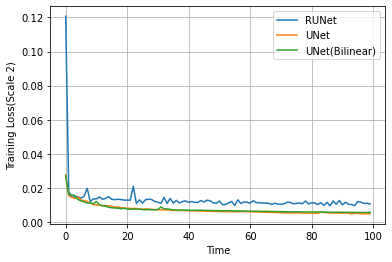

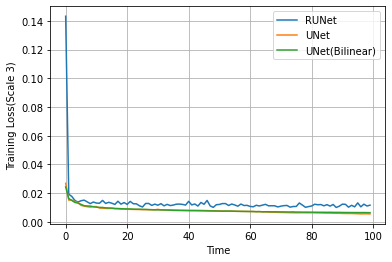

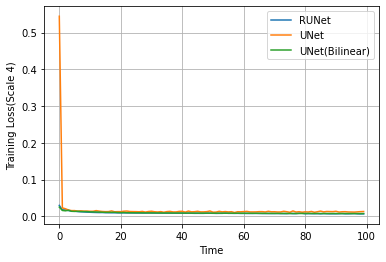

In [ ]:
time = list(range(epochs))

plt.plot(time,RUNet_2_loss_log)
plt.plot(time,UNet_2_loss_log)
plt.plot(time,UNet_2_loss_log_bilinear)
plt.legend(['RUNet', 'UNet', 'UNet(Bilinear)'], loc='upper right')
plt.ylabel(u'Training Loss(Scale 2)')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()

plt.plot(time,RUNet_3_loss_log)
plt.plot(time,UNet_3_loss_log)
plt.plot(time,UNet_3_loss_log_bilinear)
plt.legend(['RUNet', 'UNet', 'UNet(Bilinear)'], loc='upper right')
plt.ylabel(u'Training Loss(Scale 3)')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()

plt.plot(time,UNet_4_loss_log)
plt.plot(time,RUNet_4_loss_log)
plt.plot(time,UNet_4_loss_log_bilinear)
plt.legend(['RUNet', 'UNet', 'UNet(Bilinear)'], loc='upper right')
plt.ylabel(u'Training Loss(Scale 4)')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()

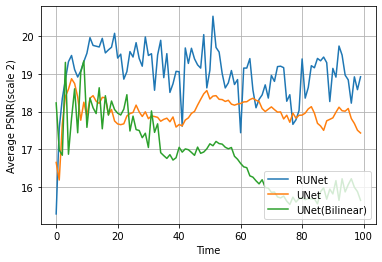

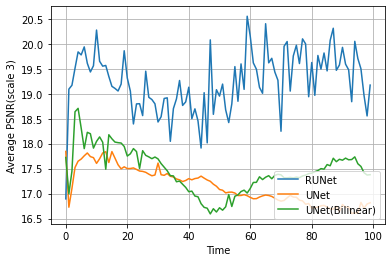

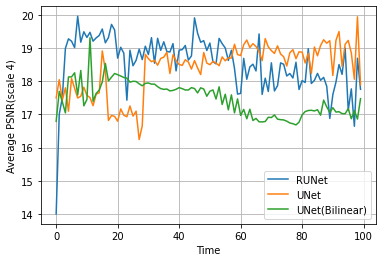

In [ ]:
plt.plot(time,RUNet_2_psnr_log)
plt.plot(time,UNet_2_psnr_log)
plt.plot(time,UNet_2_psnr_log_bilinear)
plt.legend(['RUNet', 'UNet', 'UNet(Bilinear)'], loc='lower right')
plt.ylabel(u'Average PSNR(scale 2)')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()

plt.plot(time,RUNet_3_psnr_log)
plt.plot(time,UNet_3_psnr_log)
plt.plot(time,UNet_3_psnr_log_bilinear)
plt.legend(['RUNet', 'UNet', 'UNet(Bilinear)'], loc='lower right')
plt.ylabel(u'Average PSNR(scale 3)')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()

plt.plot(time,RUNet_4_psnr_log)
plt.plot(time,UNet_4_psnr_log)
plt.plot(time,UNet_4_psnr_log_bilinear)
plt.legend(['RUNet', 'UNet', 'UNet(Bilinear)'], loc='lower right')
plt.ylabel(u'Average PSNR(scale 4)')
plt.xlabel(u'Time')

plt.grid(True)
plt.show()